## Time-derived perfomance metrics calculation (Utilization and Throughput)

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import csv
from tabulate import tabulate

def derived_metrics_calc(num_denum_df, obj, num_denum_dict):
    num_denum_df.to_csv('test.csv', index=False)
    num_denum_df.drop(columns=['stat'], inplace=True)
    metric_list = []
    for key in num_denum_dict.keys():
        value = num_denum_dict[key][0]
        metric = num_denum_dict[key][1]

        num_df = num_denum_df[num_denum_df['metric'] == key]
        denum_df = num_denum_df[num_denum_df['metric'] == value]

        num_df = num_df.rename(columns={'value': key})
        denum_df = denum_df.rename(columns={'value': value})

        num_df = num_df.drop(columns=['metric'])
        denum_df = denum_df.drop(columns=['metric'])

        metric_df = pd.merge(num_df, denum_df, on=['lambda', 'iteration'], how='inner', validate='many_to_one')
        metric_df.rename(columns={'node_x': 'node'}, inplace=True)
        metric_df.drop(columns=['node_y'], inplace=True)
        metric_df[metric] = metric_df[key] / metric_df[value]

        metric_df = metric_df[['iteration','lambda','node',key,value,metric]]
        metric_df.to_csv(os.path.join('output',f'{obj}_rho.csv'), index=False)
        metric_df = metric_df.rename(columns={metric: 'value'})
        metric_df['metric'] = metric
        metric_df.to_csv('test1.csv', index=False)
        curr_list = []
        for node in metric_df['node'].unique():
            node_df = metric_df[metric_df['node'] == node]
            curr_list.append(node_df)
        metric_list.append(curr_list)
    return metric_list

## Preprocessing


All csv files containing run statistics are read and a single dataframe is created with the concatenated csvs by adding a 'lambda' column with the arrival rate values. Three other columns are extracted from the 'statistic' column: 'node' containing the reference node of the statistic or system if it is global, 'metric' indicating the measured metric and finally 'stat' specifying whether the measured value is mean, minimum, maximum or standard deviation.

Finally, a list of dataframes is created one for each metric and node taking only the mean as the statistic.

In [36]:
output_path = os.path.join(".", "output")
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Function to remove outliers based on Z-score
def remove_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    return df[z_scores <= threshold]

def preprocessing(path, obj):
    filenames = os.listdir(path)
    stats_df_list = []
    for i in filenames:
        lambda_val = i.split('=')[1].split('_')[0]
        stats_path = os.path.join(path, i)
        stats_df = pd.read_csv(stats_path)
        stats_df['lambda'] = lambda_val
        stats_df_list.append(stats_df)
    stats_df = pd.concat(stats_df_list)

    stats_df['node'] = stats_df['statistic'].apply(lambda x: x.split('-')[0])
    stats_df['metric'] = stats_df['statistic'].apply(lambda x: x.split('-')[1])
    stats_df['stat'] = stats_df['statistic'].apply(lambda x: x.split('-')[2])
    stats_df.drop(columns=['statistic'], inplace=True)

    stats_df = stats_df[stats_df['stat'].isin(['avg', 'val'])]
    
    # List of one DataFrame for each metric selecting only the average as statistic
    metrics = stats_df['metric'].unique()
    metrics_avg_df_list = []
    metrics = metrics[metrics != 'interarrival']
    metrics = metrics[metrics != 'service']
    metrics = metrics[metrics != 'observation_time']
    metrics = metrics[metrics != 'completions']
    metrics = metrics[metrics != 'busytime']
    
    for i in metrics:
        metrics_avg_df = stats_df[stats_df['metric'] == i]
        
        # Remove outliers for the 'value' column (or other numerical columns)
        if 'value' in metrics_avg_df.columns:
            metrics_avg_df = remove_outliers_zscore(metrics_avg_df, 'value')
        
        metrics_avg_df_list.append(metrics_avg_df)

    metrics_nodes_avg_df_list = []
    for i in metrics_avg_df_list:
        nodes = i['node'].unique()
        node_avg_df_list = []
        for j in nodes:
            node_avg_df = i[i['node'] == j]
            node_avg_df_list.append(node_avg_df)
        metrics_nodes_avg_df_list.append(node_avg_df_list)
    metric_dict = {'busytime':['observation_time', 'utilization'], 'completions':['observation_time', 'throughput']}
    derived_metrics = derived_metrics_calc(stats_df, obj, metric_dict)
    for i in derived_metrics:
        metrics_nodes_avg_df_list.append(i)
        
    return metrics_nodes_avg_df_list


## Boxplot funcion
Boxplots of the average of population number, throughput and response time with arrival rate in a range 0.5, 1.2 job/sec

In [37]:
def boxplot(metrics_nodes_avg_df_list):    
    for metric in metrics_nodes_avg_df_list:
        figure, axis = plt.subplots(2, 2, figsize=(15, 10))
        for i, boxplot_df in enumerate(metric):
            boxplot_df['value'].astype(float)
            boxplot_df['lambda'].astype(float)
            boxplot_df = boxplot_df.sort_values(by='lambda')

            curr_metric = boxplot_df['metric'].unique()[0]
            curr_node = boxplot_df['node'].unique()[0]
            x = i // 2
            y = i % 2

            boxplot_df.boxplot(column='value', by='lambda', ax = axis[x, y], showfliers=False)
            plt.suptitle('')
            axis[x, y].set_title(f'Boxplot of {curr_metric} of the {curr_node} node')

        plt.tight_layout()
        plt.show()

## Confidence interval calculation
Confidence intervals are calculated on the batches of runs made as the lambda parameter changes.

The following formula is used to calculate the interval:

$
CI = \bar{x} \pm z \cdot \frac{\sigma}{\sqrt{n}}
$

Where:
- $\bar{x}$ is the sample mean.
- $z$ is the critical value of the standard normal distribution corresponding to the chosen confidence level (e.g., 1.96 for 95%).
- $\sigma$ is the population standard deviation.
- $n$ is the sample size.

In [38]:
def confidence_interval(metrics_nodes_avg_df_list, critical_value, obj):
    ci_df = []
    for metric in metrics_nodes_avg_df_list:
        metric_list = []
        for node_df in metric:
            curr_metric = node_df['metric'].unique()[0]
            curr_node = node_df['node'].unique()[0]
            
            df = node_df.groupby(["lambda"])['value'].describe()[["count", "mean", "std"]].reset_index()
            df["lower_ci"] = df["mean"] - critical_value*(df["std"]/np.sqrt(df["count"]))
            df["upper_ci"] = df["mean"] + critical_value*(df["std"]/np.sqrt(df["count"]))

            df.to_csv(os.path.join("output", f"{obj}_conf_int_{curr_node}_{curr_metric}.csv"), index=False)
            df['metric'] = curr_metric
            df['node'] = curr_node
            metric_list.append(df)
        ci_df.append(metric_list)
    return ci_df

In [39]:
def plot_confidence_interval(ci_df, analitycal_perf):
    colors = {'A': ['crimson', 'darkred'], 'B': ['darkblue', 'royalblue'], 'P': ['darkgreen', 'limegreen']}
    for metric in ci_df:
        fig, axis = plt.subplots(2, 2, figsize=(15, 10))
        for i, df in enumerate(metric):
            x = i // 2
            y = i % 2

            curr_metric = df['metric'].unique()[0]
            curr_node = df['node'].unique()[0]

            if curr_metric != "utilization" or curr_node != "SYSTEM":
                analitycal_df = analitycal_perf[curr_metric][curr_node]
            else:
                analitycal_df = None
                
            # error bar plot with mean point
            up = df['upper_ci'] - df['mean']
            low = df['mean'] - df['lower_ci']
            df['lambda'] = df['lambda'].astype(float)

            axis[x, y].errorbar(df['lambda'], df['mean'], yerr=[low, up], fmt='o', capsize=5, label='Confidence interval 95%')

            # lineplot of the mean points
            axis[x, y].plot(df['lambda'], df['mean'], linestyle='-', marker='o', color='b', label='simulation run')
            if analitycal_df is not None:
                axis[x, y].plot(analitycal_df['lambda'], analitycal_df['value'], linestyle='-', marker='o', color='r', label='analitycal model')

            axis[x, y].set_xlabel('Lambda')
            axis[x, y].set_ylabel(f"Avg {curr_metric} in {curr_node}")
            axis[x, y].set_title(f"Confidence interval for {curr_node} average {curr_metric}")
            axis[x, y].legend()
        plt.tight_layout()
        plt.show()

        if 'throughput' in df['metric'].values:
            fig, ax = plt.subplots(figsize=(10, 6))

            for df in metric:
                if df['node'].unique()[0] == 'SYSTEM':
                    continue
                base_color = colors[df['node'].unique()[0]][0]
                darker_color = colors[df['node'].unique()[0]][1]
                ax.errorbar(df['lambda'], df['mean'], 
                            yerr=[df['mean'] - df['lower_ci'], df['upper_ci'] - df['mean']], 
                            fmt='o', capsize=5, color = darker_color)

                ax.plot(df['lambda'], df['mean'], linestyle='-', marker='o', label=f'Throughput of {df["node"].unique()[0]}', color = base_color)

            # Aggiunta delle etichette e del titolo
            ax.set_xlabel('Lambda')
            ax.set_ylabel('Avg')
            ax.set_title('Throughput comparison')
            ax.legend()
            # Mostra il grafico
            plt.show()


## Simulation vs. Analitycal model

In [40]:
def analitycal_preprocessing(obj):
    metric_node_analitycal_dict = {}
    servers = ['[A]', '[B]', '[P]', '[S]']
    metrics = {'E[T]': 'response_time', 'E[N]': 'population', 'X': 'throughput', 'rho': 'utilization'} 

    local_perf = pd.read_csv(os.path.join('output', f'{obj}_analitycal_local_performances.csv'))
    global_perf = pd.read_csv(os.path.join('output', f'{obj}_analitycal_global_performances.csv'))
    rho_perf = pd.read_csv(os.path.join('output', f'{obj}_analitycal_rho.csv'))
    analitycal_perf = pd.merge(local_perf, global_perf, on=['gamma'], how='inner', validate='one_to_one')
    analitycal_perf = pd.merge(analitycal_perf, rho_perf, on=['gamma'], how='inner', validate='one_to_one')
    
    for m in metrics.keys():
        metric_columns = [col for col in analitycal_perf.columns if col.startswith(m)]
        metric_df = analitycal_perf[metric_columns].copy()
        metric_df['metric'] = metrics[m]
        node_dict = {}
        for s in servers:
            s_column = [col for col in metric_df.columns if col.endswith(s)]
            if not s_column:
                continue
            s_df = metric_df[s_column].copy()

            s_df = s_df.rename(columns={s_column[0]: 'value'})
            node = s.split('[')[1].split(']')[0]
            node = 'SYSTEM' if node == 'S' else node
            s_df['node'] = node
            s_df['lambda'] = analitycal_perf['gamma'].copy().astype(float)
            s_df['metric'] = metric_df['metric'].unique()[0]
            node_dict[node] = s_df
        metric_node_analitycal_dict[metrics[m]] = node_dict

    return metric_node_analitycal_dict


def average_stats(stats_df, analitycal_perf):
    avg_metric_list = []
    for metric in stats_df:
        average_list_node = []
        for node in metric:
            node_name = node['node'].unique()[0]
            metric_name = node['metric'].unique()[0]
            if metric_name != 'utilization' or node_name != 'SYSTEM':
                node.drop(columns=['iteration'], inplace=True)
                node = node.groupby(['lambda', 'metric', 'node'])['value'].mean().reset_index()
                node['lambda'] = node['lambda'].astype(float)
                merging_df = analitycal_perf[node['metric'].unique()[0]][node['node'].unique()[0]]
                
                node = pd.merge(node, merging_df, on=['lambda', 'metric', 'node'], how='inner', validate='one_to_one')
                node['diff'] = abs(node['value_x'] - node['value_y'])
                node.rename(columns={'value_x': 'simulation_value', 'value_y': 'analitycal_value'}, inplace=True)
                average_list_node.append(node)
        avg_metric_list.append(average_list_node)
    return avg_metric_list

## Objective 1

Implementation of a model to execute the web app workflow to measure response time (R), population number (N) and throughput (X) quantities

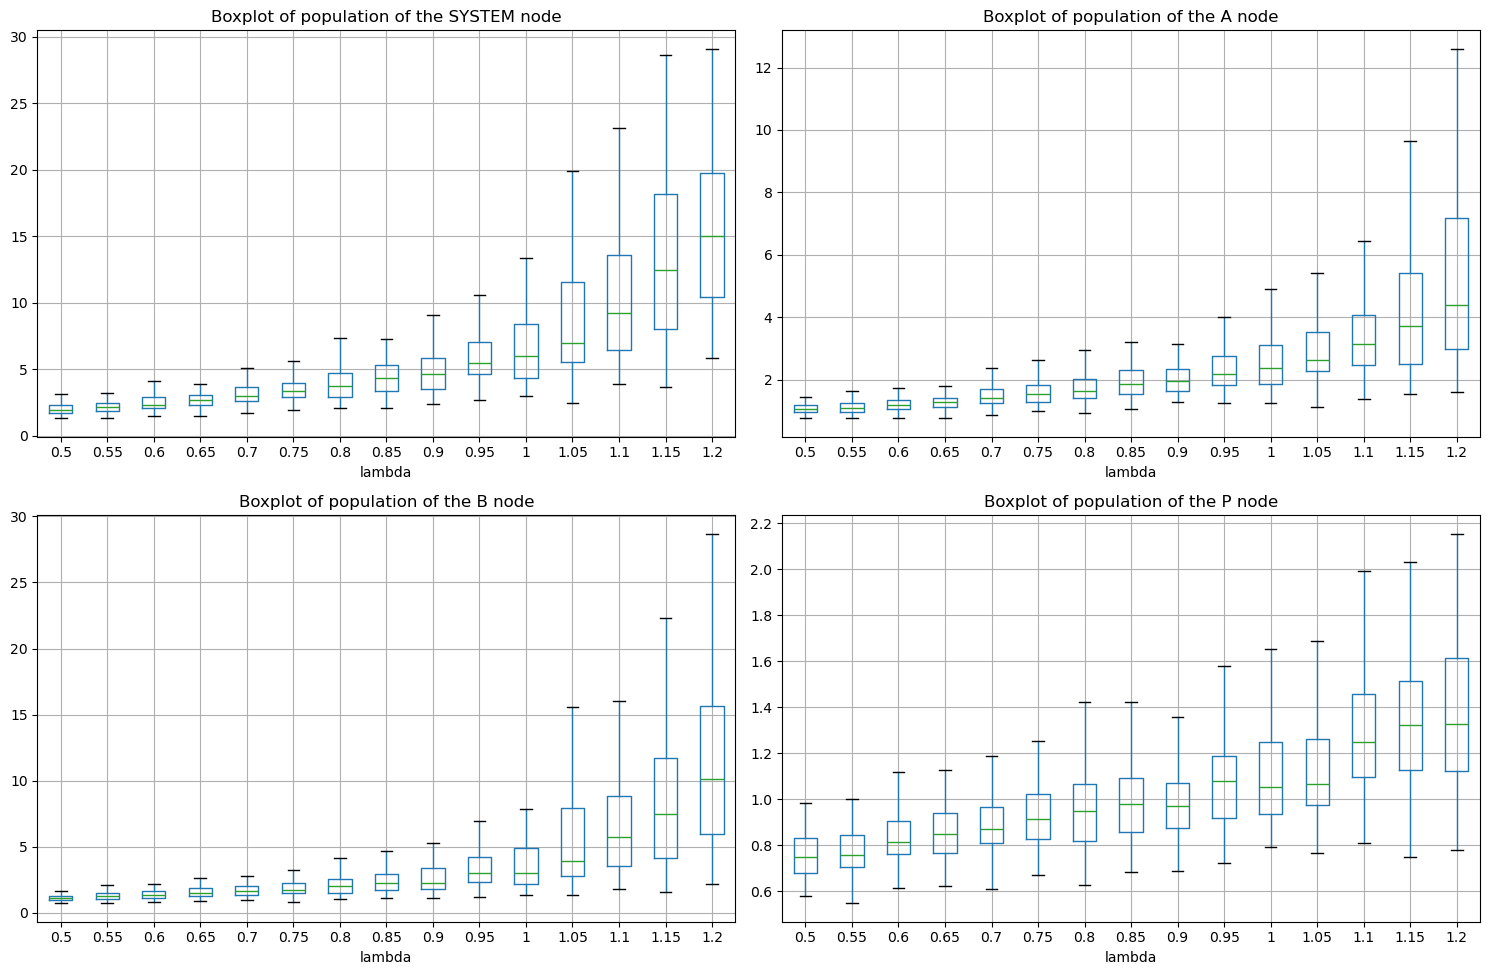

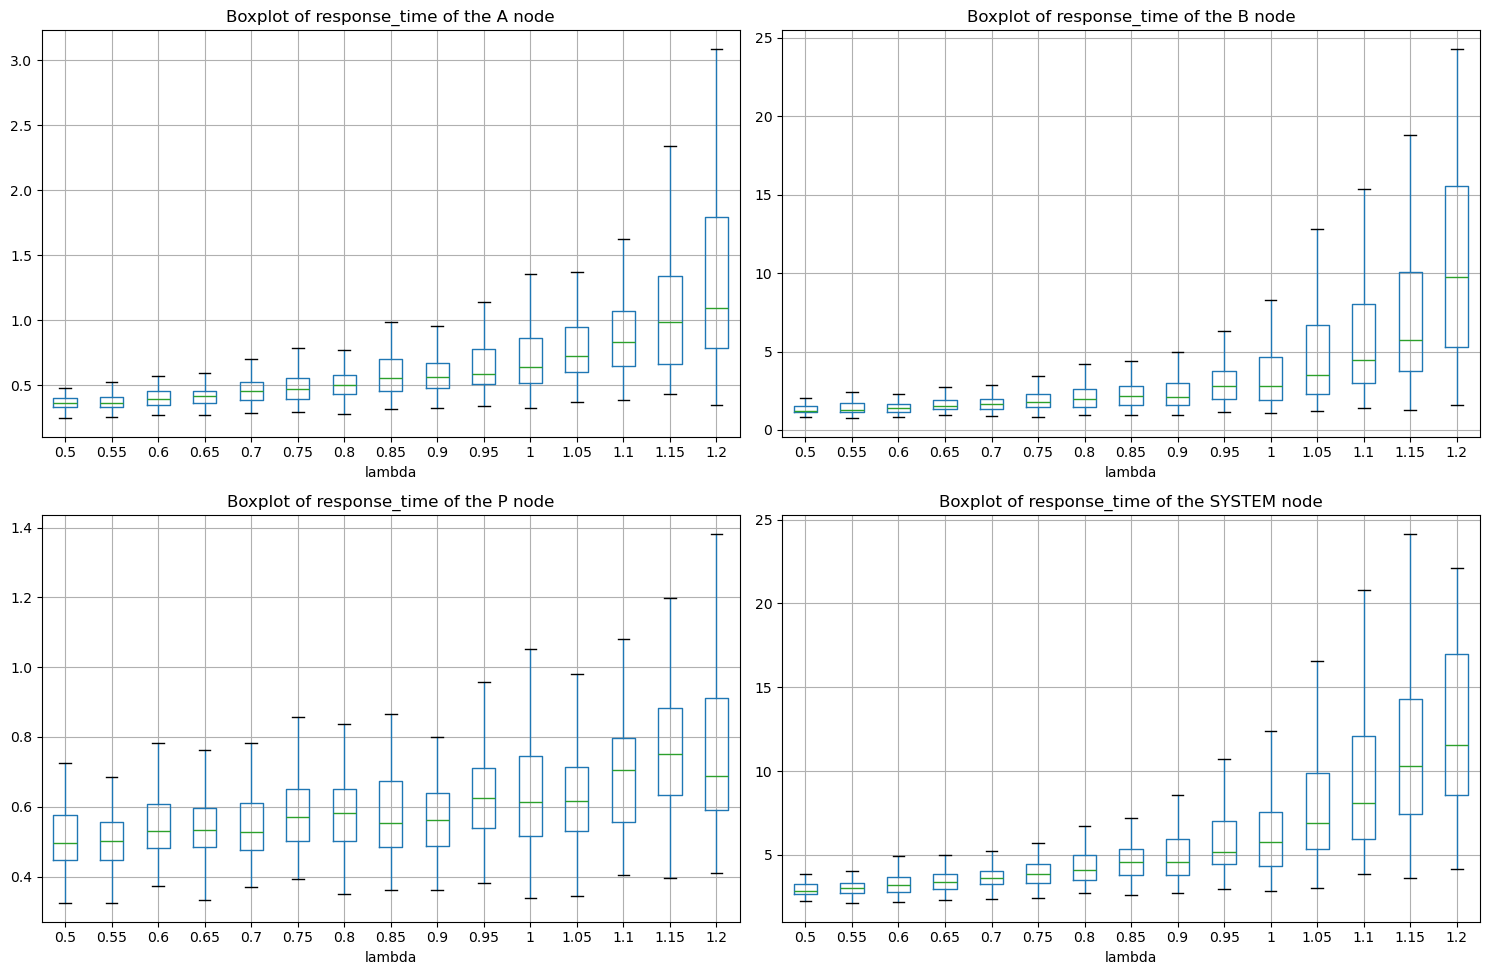

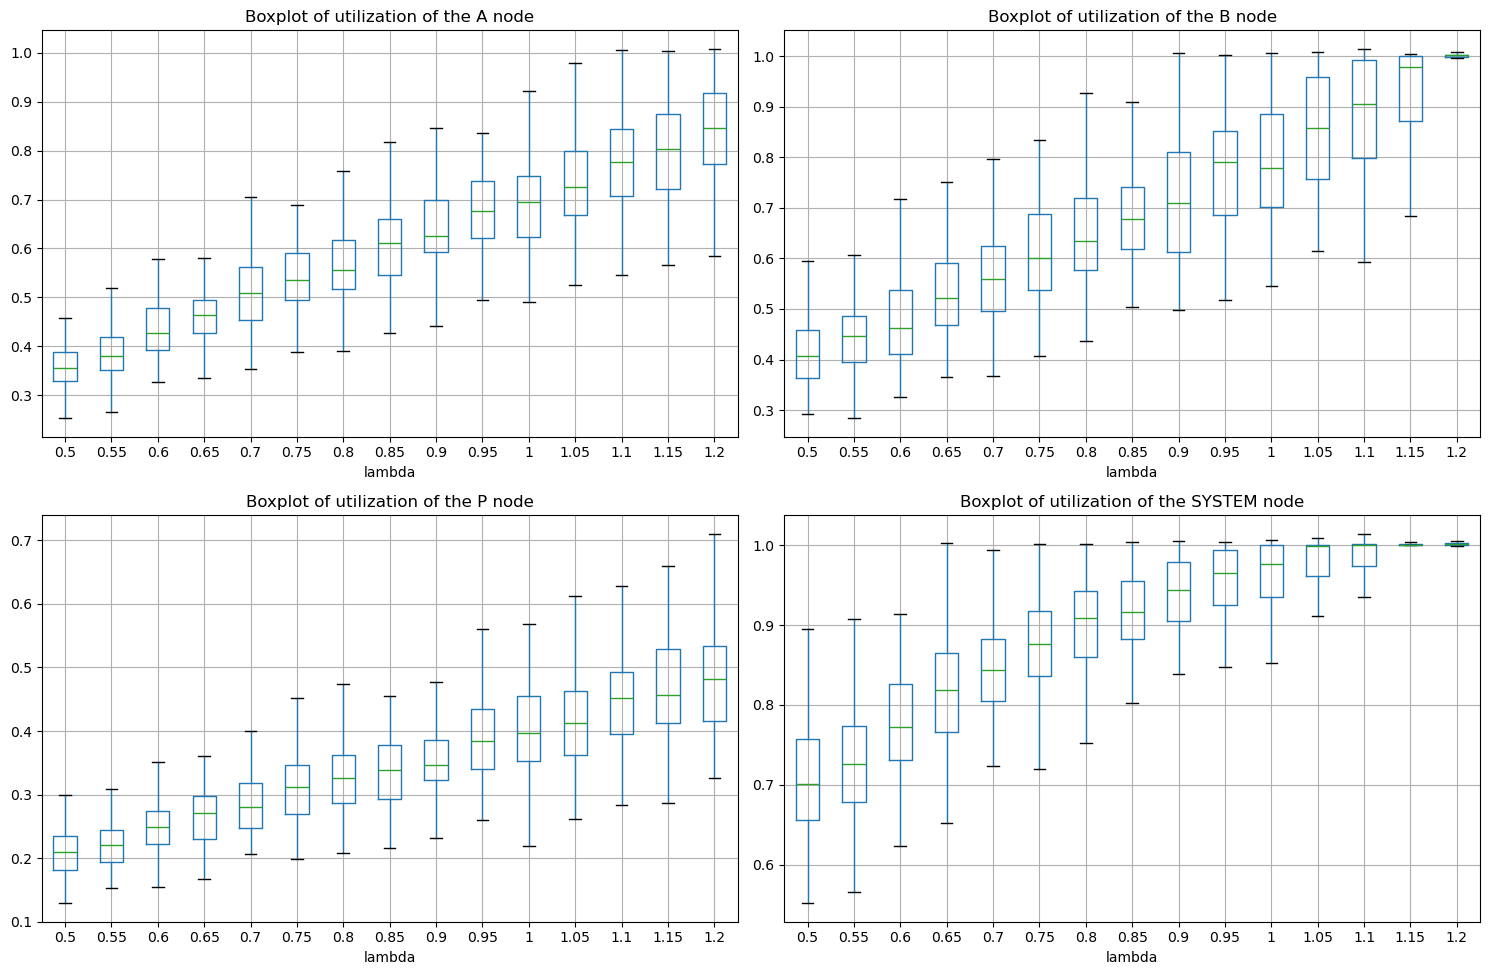

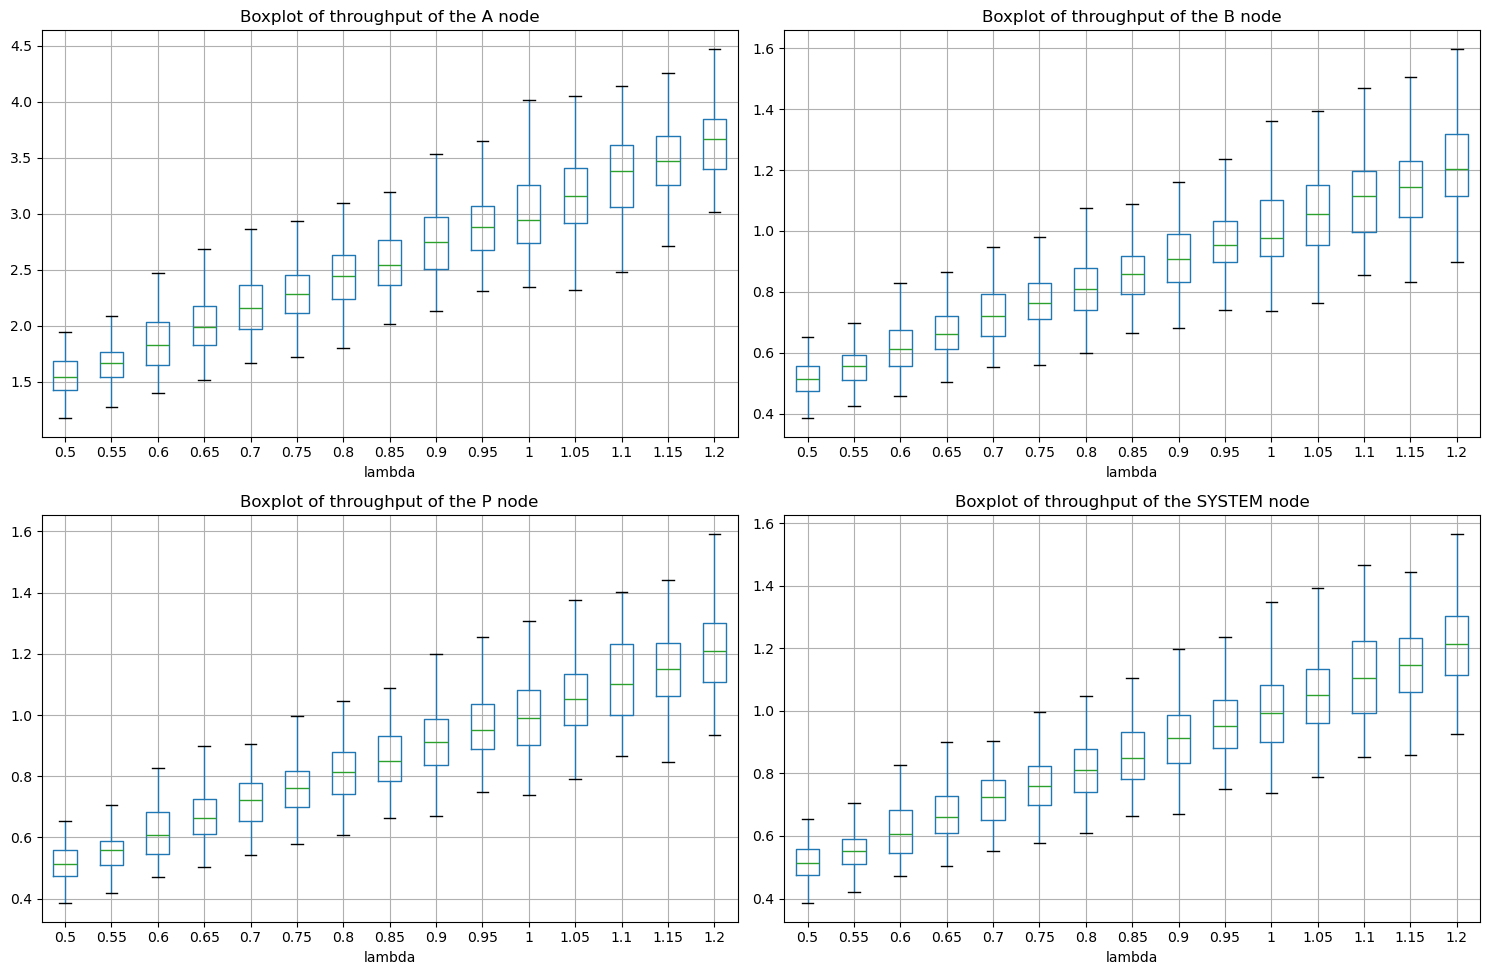

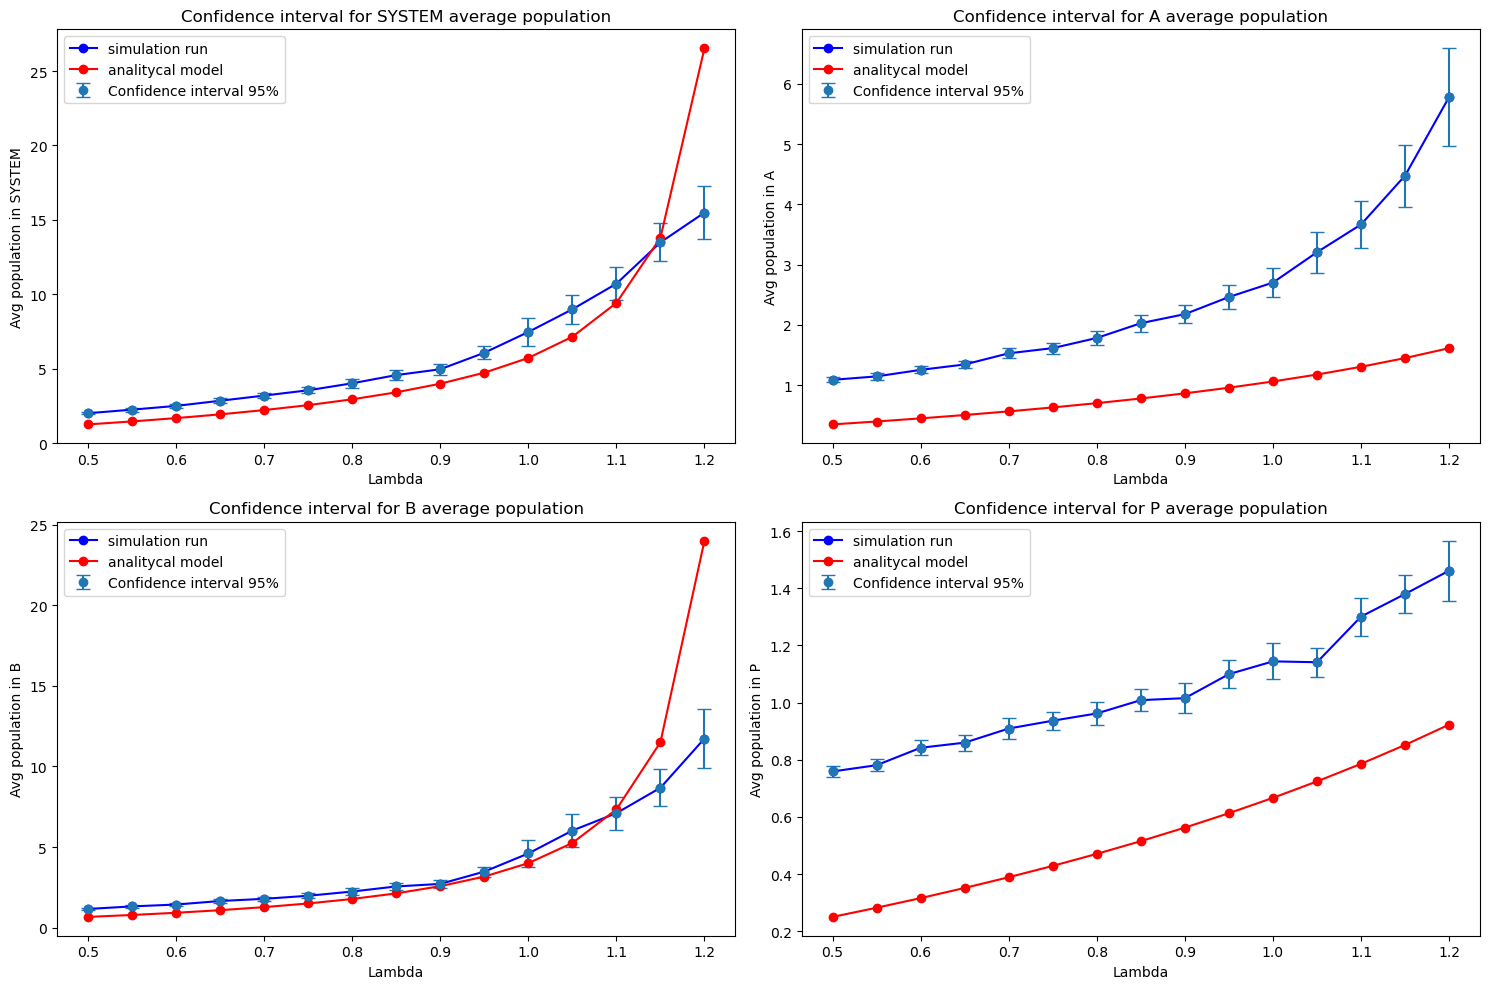

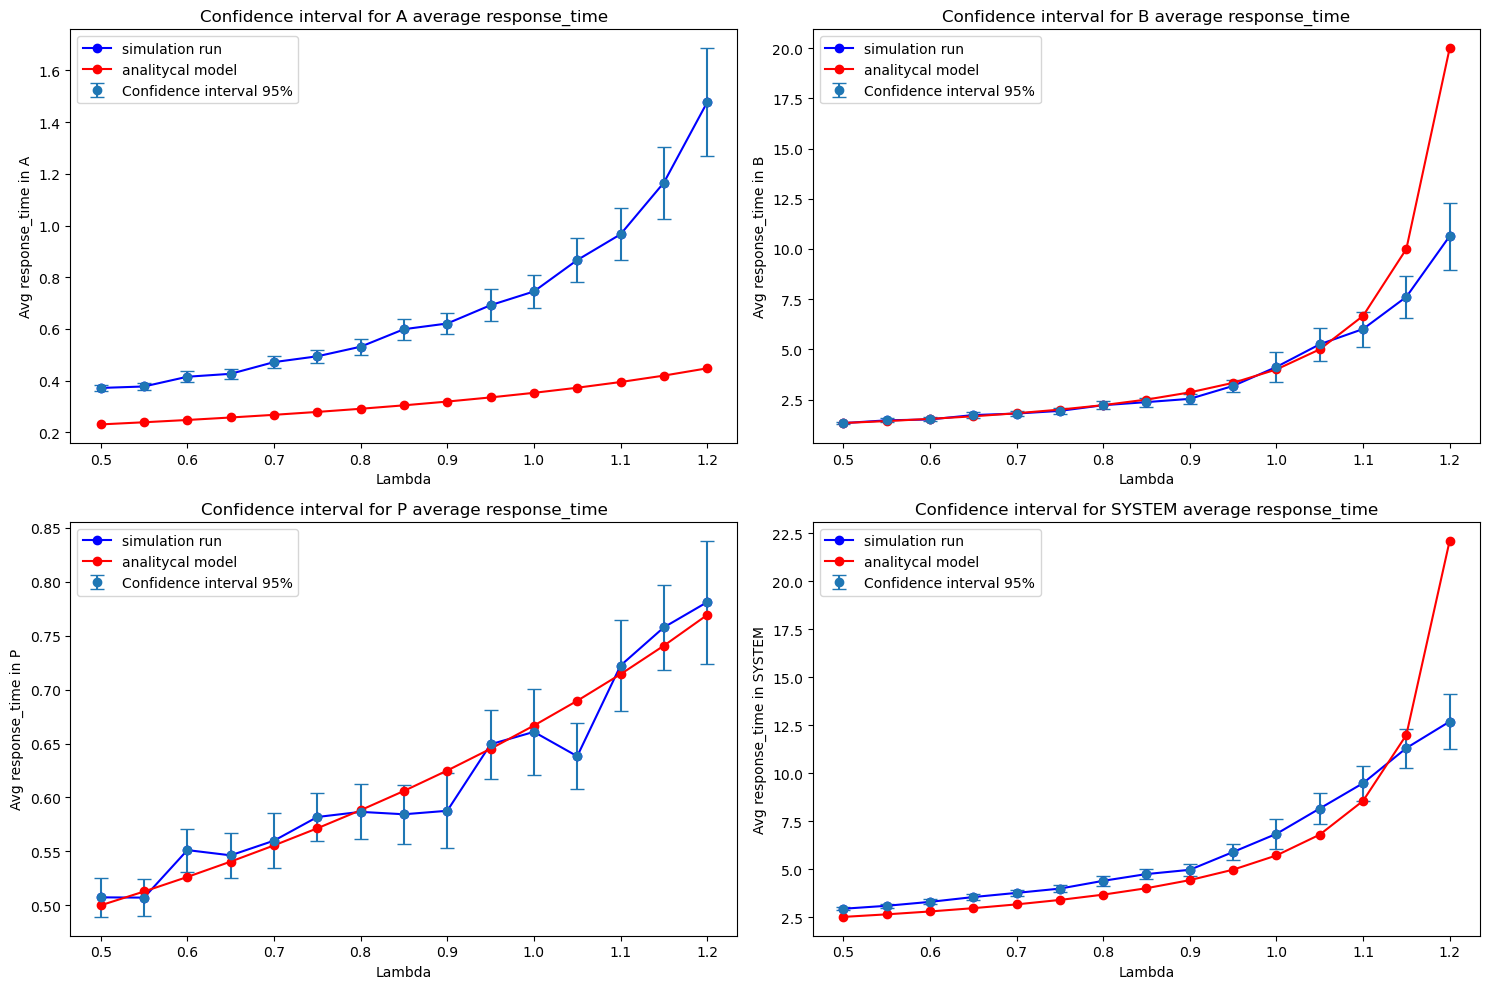

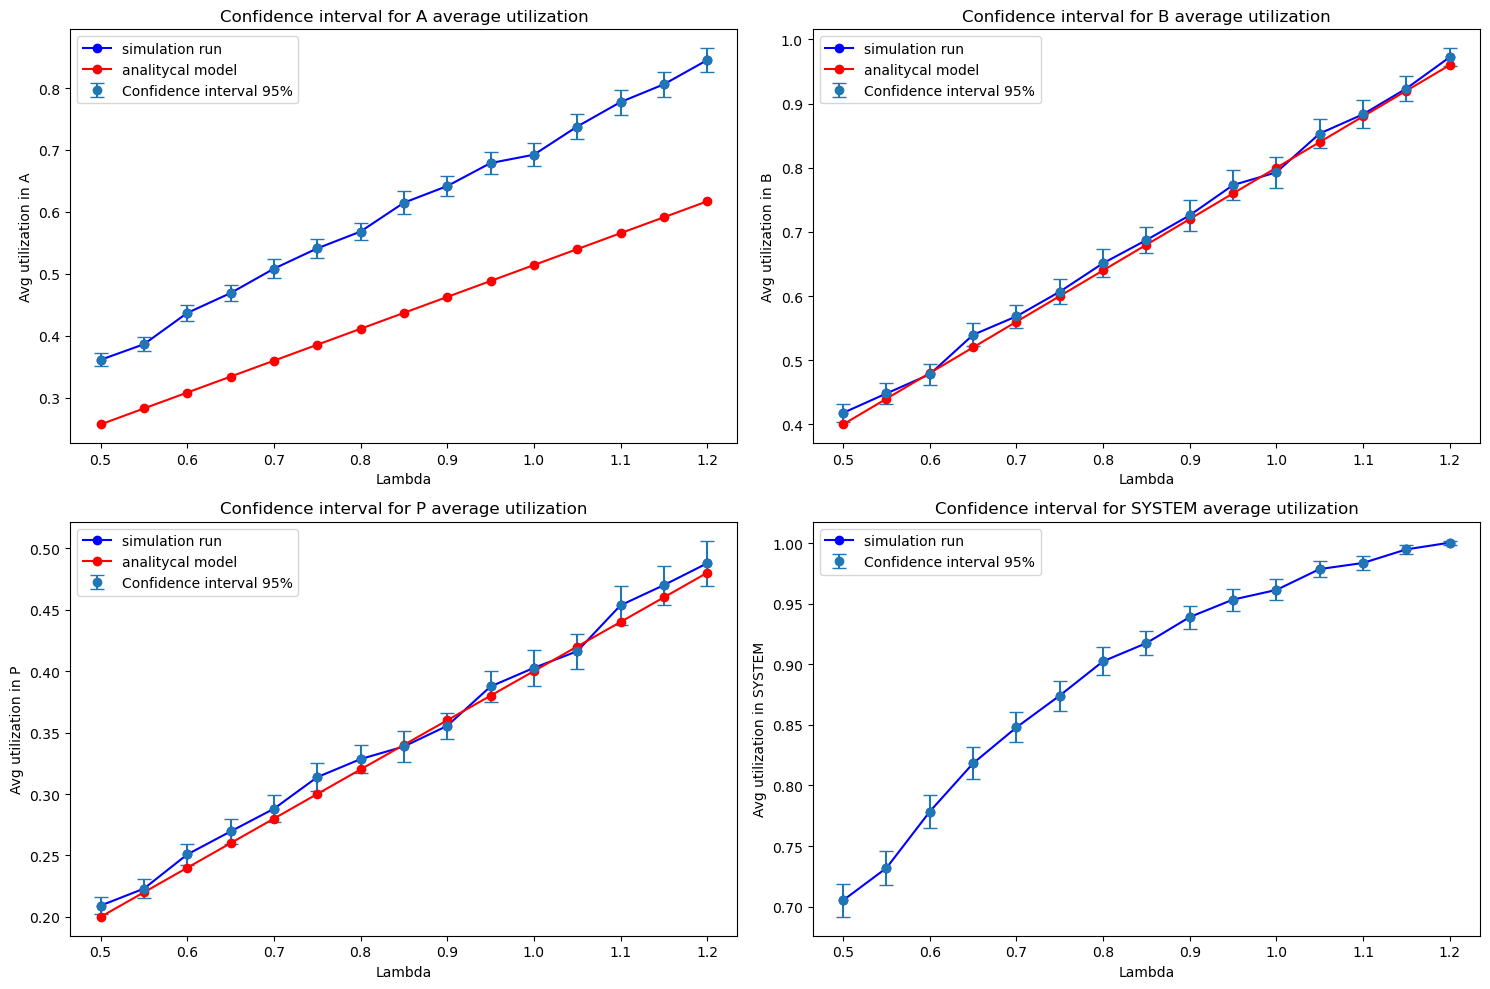

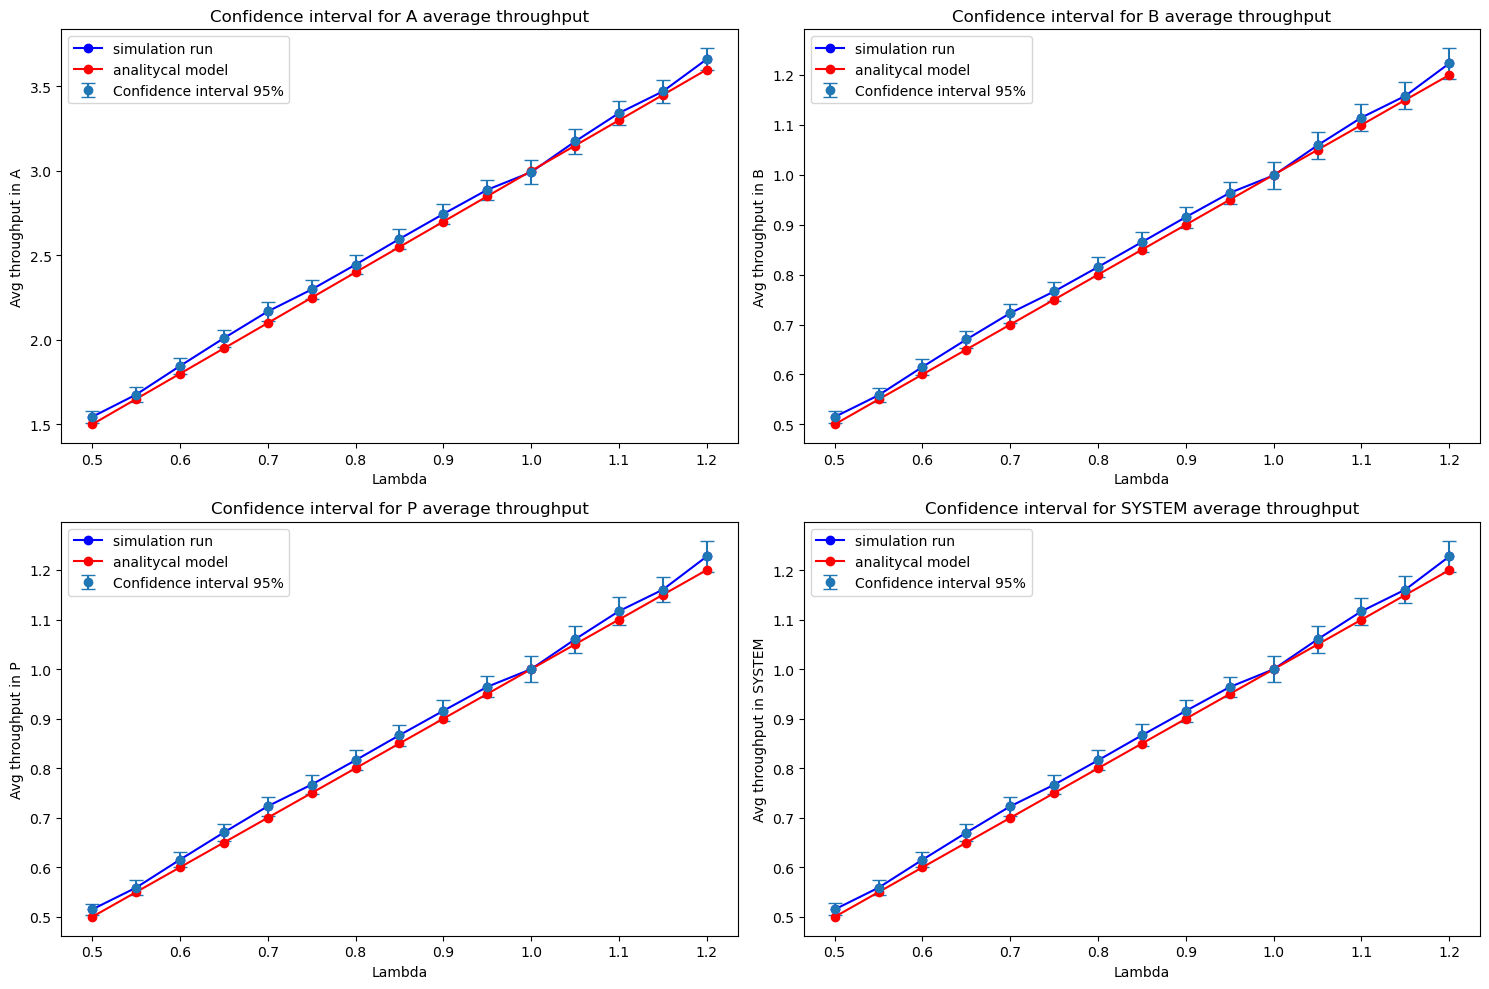

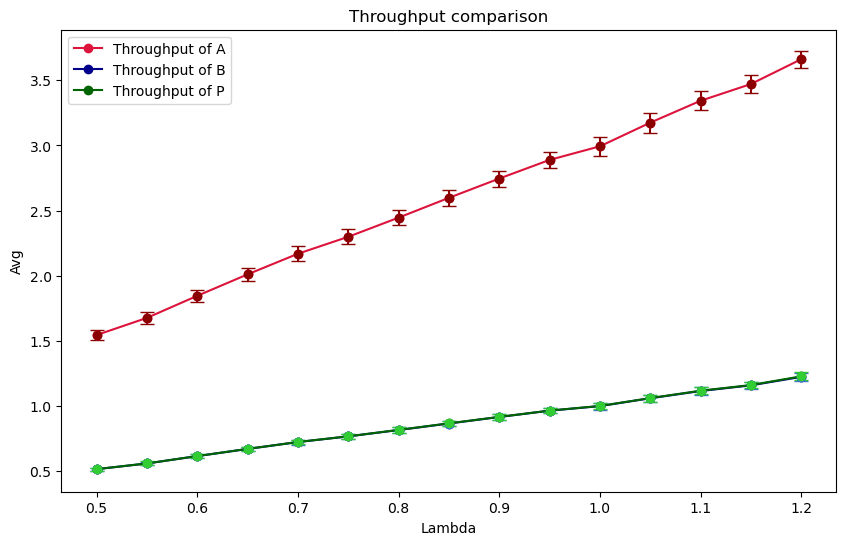

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">     diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           2.0137 </td><td style="text-align: right;">           1.26282</td><td style="text-align: right;"> 0.750875</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           2.25261</td><td style="text-align: right;">           1.46219</td><td style="text-align: right;"> 0.79042 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           2.50487</td><td style="text-align: right;">           1.68515</td><td style="text-align: right;"> 0.819723</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           2.85076</td><td style="text-align: right;">           1.93683</td><td style="text-align: right;"> 0.913928</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           3.19901</td><td style="text-align: right;">           2.22412</td><td style="text-align: right;"> 0.974894</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           3.55338</td><td style="text-align: right;">           2.55648</td><td style="text-align: right;"> 0.996899</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           4.02317</td><td style="text-align: right;">           2.9474 </td><td style="text-align: right;"> 1.07577 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           4.57416</td><td style="text-align: right;">           3.4168 </td><td style="text-align: right;"> 1.15735 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           4.96641</td><td style="text-align: right;">           3.99563</td><td style="text-align: right;"> 0.970783</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           6.07264</td><td style="text-align: right;">           4.73488</td><td style="text-align: right;"> 1.33776 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           7.46859</td><td style="text-align: right;">           5.72549</td><td style="text-align: right;"> 1.7431  </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           8.99486</td><td style="text-align: right;">           7.14805</td><td style="text-align: right;"> 1.84681 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">          10.7125 </td><td style="text-align: right;">           9.42168</td><td style="text-align: right;"> 1.29078 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">          13.4911 </td><td style="text-align: right;">          13.7994 </td><td style="text-align: right;"> 0.308281</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">          15.4895 </td><td style="text-align: right;">          26.535  </td><td style="text-align: right;">11.0456  </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.08599</td><td style="text-align: right;">          0.346154</td><td style="text-align: right;">0.739837</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>A     </td><td style="text-align: right;">           1.14312</td><td style="text-align: right;">          0.394422</td><td style="text-align: right;">0.748701</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.25181</td><td style="text-align: right;">          0.446281</td><td style="text-align: right;">0.805532</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>A     </td><td style="text-align: right;">           1.34092</td><td style="text-align: right;">          0.502146</td><td style="text-align: right;">0.838774</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.52646</td><td style="text-align: right;">          0.5625  </td><td style="text-align: right;">0.963964</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>A     </td><td style="text-align: right;">           1.6123 </td><td style="text-align: right;">          0.627907</td><td style="text-align: right;">0.984396</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.78125</td><td style="text-align: right;">          0.699029</td><td style="text-align: right;">1.08222 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>A     </td><td style="text-align: right;">           2.02639</td><td style="text-align: right;">          0.77665 </td><td style="text-align: right;">1.24974 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>A     </td><td style="text-align: right;">           2.17658</td><td style="text-align: right;">          0.861702</td><td style="text-align: right;">1.31488 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>A     </td><td style="text-align: right;">           2.46114</td><td style="text-align: right;">          0.955307</td><td style="text-align: right;">1.50584 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>A     </td><td style="text-align: right;">           2.70058</td><td style="text-align: right;">          1.05882 </td><td style="text-align: right;">1.64175 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>A     </td><td style="text-align: right;">           3.20469</td><td style="text-align: right;">          1.17391 </td><td style="text-align: right;">2.03078 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>A     </td><td style="text-align: right;">           3.66529</td><td style="text-align: right;">          1.30263 </td><td style="text-align: right;">2.36266 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>A     </td><td style="text-align: right;">           4.47752</td><td style="text-align: right;">          1.44755 </td><td style="text-align: right;">3.02997 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>A     </td><td style="text-align: right;">           5.78237</td><td style="text-align: right;">          1.61194 </td><td style="text-align: right;">4.17043 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">     diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>B     </td><td style="text-align: right;">           1.15858</td><td style="text-align: right;">          0.666667</td><td style="text-align: right;"> 0.491911</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>B     </td><td style="text-align: right;">           1.31864</td><td style="text-align: right;">          0.785714</td><td style="text-align: right;"> 0.532929</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>B     </td><td style="text-align: right;">           1.43242</td><td style="text-align: right;">          0.923077</td><td style="text-align: right;"> 0.509338</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>B     </td><td style="text-align: right;">           1.65209</td><td style="text-align: right;">          1.08333 </td><td style="text-align: right;"> 0.568756</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>B     </td><td style="text-align: right;">           1.78801</td><td style="text-align: right;">          1.27273 </td><td style="text-align: right;"> 0.515287</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>B     </td><td style="text-align: right;">           1.97774</td><td style="text-align: right;">          1.5     </td><td style="text-align: right;"> 0.47774 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>B     </td><td style="text-align: right;">           2.23924</td><td style="text-align: right;">          1.77778 </td><td style="text-align: right;"> 0.461467</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>B     </td><td style="text-align: right;">           2.55535</td><td style="text-align: right;">          2.125   </td><td style="text-align: right;"> 0.430354</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>B     </td><td style="text-align: right;">           2.71235</td><td style="text-align: right;">          2.57143 </td><td style="text-align: right;"> 0.140924</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>B     </td><td style="text-align: right;">           3.47349</td><td style="text-align: right;">          3.16667 </td><td style="text-align: right;"> 0.306821</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>B     </td><td style="text-align: right;">           4.60033</td><td style="text-align: right;">          4       </td><td style="text-align: right;"> 0.600335</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>B     </td><td style="text-align: right;">           6.02122</td><td style="text-align: right;">          5.25    </td><td style="text-align: right;"> 0.771221</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>B     </td><td style="text-align: right;">           7.09822</td><td style="text-align: right;">          7.33333 </td><td style="text-align: right;"> 0.235116</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>B     </td><td style="text-align: right;">           8.67469</td><td style="text-align: right;">         11.5     </td><td style="text-align: right;"> 2.82531 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>B     </td><td style="text-align: right;">          11.7293 </td><td style="text-align: right;">         24       </td><td style="text-align: right;">12.2707  </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>P     </td><td style="text-align: right;">          0.758962</td><td style="text-align: right;">          0.25    </td><td style="text-align: right;">0.508962</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>P     </td><td style="text-align: right;">          0.780884</td><td style="text-align: right;">          0.282051</td><td style="text-align: right;">0.498833</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>P     </td><td style="text-align: right;">          0.841871</td><td style="text-align: right;">          0.315789</td><td style="text-align: right;">0.526081</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>P     </td><td style="text-align: right;">          0.859783</td><td style="text-align: right;">          0.351351</td><td style="text-align: right;">0.508432</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>P     </td><td style="text-align: right;">          0.909188</td><td style="text-align: right;">          0.388889</td><td style="text-align: right;">0.520299</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>P     </td><td style="text-align: right;">          0.936611</td><td style="text-align: right;">          0.428571</td><td style="text-align: right;">0.508039</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>P     </td><td style="text-align: right;">          0.961953</td><td style="text-align: right;">          0.470588</td><td style="text-align: right;">0.491365</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>P     </td><td style="text-align: right;">          1.00859 </td><td style="text-align: right;">          0.515152</td><td style="text-align: right;">0.493441</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>P     </td><td style="text-align: right;">          1.01546 </td><td style="text-align: right;">          0.5625  </td><td style="text-align: right;">0.452963</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>P     </td><td style="text-align: right;">          1.09959 </td><td style="text-align: right;">          0.612903</td><td style="text-align: right;">0.48669 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>P     </td><td style="text-align: right;">          1.14419 </td><td style="text-align: right;">          0.666667</td><td style="text-align: right;">0.477528</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>P     </td><td style="text-align: right;">          1.14117 </td><td style="text-align: right;">          0.724138</td><td style="text-align: right;">0.417032</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>P     </td><td style="text-align: right;">          1.30101 </td><td style="text-align: right;">          0.785714</td><td style="text-align: right;">0.515293</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>P     </td><td style="text-align: right;">          1.38008 </td><td style="text-align: right;">          0.851852</td><td style="text-align: right;">0.528224</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>P     </td><td style="text-align: right;">          1.46178 </td><td style="text-align: right;">          0.923077</td><td style="text-align: right;">0.538706</td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.371833</td><td style="text-align: right;">          0.230769</td><td style="text-align: right;">0.141063</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.377507</td><td style="text-align: right;">          0.239044</td><td style="text-align: right;">0.138463</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.415174</td><td style="text-align: right;">          0.247934</td><td style="text-align: right;">0.16724 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.426498</td><td style="text-align: right;">          0.257511</td><td style="text-align: right;">0.168987</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.471776</td><td style="text-align: right;">          0.267857</td><td style="text-align: right;">0.203919</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.494261</td><td style="text-align: right;">          0.27907 </td><td style="text-align: right;">0.215192</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.531352</td><td style="text-align: right;">          0.291262</td><td style="text-align: right;">0.24009 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.599107</td><td style="text-align: right;">          0.304569</td><td style="text-align: right;">0.294538</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.621134</td><td style="text-align: right;">          0.319149</td><td style="text-align: right;">0.301985</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.692007</td><td style="text-align: right;">          0.335196</td><td style="text-align: right;">0.356812</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.745082</td><td style="text-align: right;">          0.352941</td><td style="text-align: right;">0.392141</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.866535</td><td style="text-align: right;">          0.372671</td><td style="text-align: right;">0.493864</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.966218</td><td style="text-align: right;">          0.394737</td><td style="text-align: right;">0.571481</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>A     </td><td style="text-align: right;">          1.16597 </td><td style="text-align: right;">          0.41958 </td><td style="text-align: right;">0.746388</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          1.47688 </td><td style="text-align: right;">          0.447761</td><td style="text-align: right;">1.02912 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.32774</td><td style="text-align: right;">           1.33333</td><td style="text-align: right;">0.00559564</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.46597</td><td style="text-align: right;">           1.42857</td><td style="text-align: right;">0.0373991 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.51073</td><td style="text-align: right;">           1.53846</td><td style="text-align: right;">0.0277308 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.72808</td><td style="text-align: right;">           1.66667</td><td style="text-align: right;">0.0614094 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.80358</td><td style="text-align: right;">           1.81818</td><td style="text-align: right;">0.0145975 </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.93662</td><td style="text-align: right;">           2      </td><td style="text-align: right;">0.0633776 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           2.21861</td><td style="text-align: right;">           2.22222</td><td style="text-align: right;">0.00360812</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>B     </td><td style="text-align: right;">           2.37343</td><td style="text-align: right;">           2.5    </td><td style="text-align: right;">0.126573  </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           2.53583</td><td style="text-align: right;">           2.85714</td><td style="text-align: right;">0.321317  </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>B     </td><td style="text-align: right;">           3.179  </td><td style="text-align: right;">           3.33333</td><td style="text-align: right;">0.154334  </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>B     </td><td style="text-align: right;">           4.12498</td><td style="text-align: right;">           4      </td><td style="text-align: right;">0.124983  </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>B     </td><td style="text-align: right;">           5.25213</td><td style="text-align: right;">           5      </td><td style="text-align: right;">0.252133  </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           6.01235</td><td style="text-align: right;">           6.66667</td><td style="text-align: right;">0.654317  </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>B     </td><td style="text-align: right;">           7.61458</td><td style="text-align: right;">          10      </td><td style="text-align: right;">2.38542   </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>B     </td><td style="text-align: right;">          10.6409 </td><td style="text-align: right;">          20      </td><td style="text-align: right;">9.35913   </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.50739 </td><td style="text-align: right;">          0.5     </td><td style="text-align: right;">0.00739004</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.507148</td><td style="text-align: right;">          0.512821</td><td style="text-align: right;">0.00567265</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.551204</td><td style="text-align: right;">          0.526316</td><td style="text-align: right;">0.0248879 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.546347</td><td style="text-align: right;">          0.540541</td><td style="text-align: right;">0.00580619</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.559953</td><td style="text-align: right;">          0.555556</td><td style="text-align: right;">0.00439757</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.581899</td><td style="text-align: right;">          0.571429</td><td style="text-align: right;">0.0104703 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.58666 </td><td style="text-align: right;">          0.588235</td><td style="text-align: right;">0.00157549</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.584419</td><td style="text-align: right;">          0.606061</td><td style="text-align: right;">0.0216417 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.587652</td><td style="text-align: right;">          0.625   </td><td style="text-align: right;">0.0373477 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.649323</td><td style="text-align: right;">          0.645161</td><td style="text-align: right;">0.00416125</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.660812</td><td style="text-align: right;">          0.666667</td><td style="text-align: right;">0.00585425</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.638235</td><td style="text-align: right;">          0.689655</td><td style="text-align: right;">0.0514197 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.722308</td><td style="text-align: right;">          0.714286</td><td style="text-align: right;">0.00802257</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.757746</td><td style="text-align: right;">          0.740741</td><td style="text-align: right;">0.0170049 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.78111 </td><td style="text-align: right;">          0.769231</td><td style="text-align: right;">0.0118788 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           2.95018</td><td style="text-align: right;">           2.52564</td><td style="text-align: right;">0.424534</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           3.10416</td><td style="text-align: right;">           2.65852</td><td style="text-align: right;">0.445638</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           3.30757</td><td style="text-align: right;">           2.80858</td><td style="text-align: right;">0.498989</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           3.55804</td><td style="text-align: right;">           2.97974</td><td style="text-align: right;">0.578297</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           3.77572</td><td style="text-align: right;">           3.17731</td><td style="text-align: right;">0.598412</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           3.99813</td><td style="text-align: right;">           3.40864</td><td style="text-align: right;">0.589491</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           4.40407</td><td style="text-align: right;">           3.68424</td><td style="text-align: right;">0.719825</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           4.75556</td><td style="text-align: right;">           4.01977</td><td style="text-align: right;">0.735794</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           4.97693</td><td style="text-align: right;">           4.43959</td><td style="text-align: right;">0.537344</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           5.90452</td><td style="text-align: right;">           4.98408</td><td style="text-align: right;">0.920442</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           6.84905</td><td style="text-align: right;">           5.72549</td><td style="text-align: right;">1.12356 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           8.16883</td><td style="text-align: right;">           6.80767</td><td style="text-align: right;">1.36116 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           9.48592</td><td style="text-align: right;">           8.56516</td><td style="text-align: right;">0.92076 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">          11.3158 </td><td style="text-align: right;">          11.9995 </td><td style="text-align: right;">0.683709</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">          12.6941 </td><td style="text-align: right;">          22.1125 </td><td style="text-align: right;">9.41842 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric     </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.361412</td><td style="text-align: right;">          0.257143</td><td style="text-align: right;">0.104269</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.38654 </td><td style="text-align: right;">          0.282857</td><td style="text-align: right;">0.103683</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.437019</td><td style="text-align: right;">          0.308571</td><td style="text-align: right;">0.128447</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.469097</td><td style="text-align: right;">          0.334286</td><td style="text-align: right;">0.134811</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.50844 </td><td style="text-align: right;">          0.36    </td><td style="text-align: right;">0.14844 </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.5412  </td><td style="text-align: right;">          0.385714</td><td style="text-align: right;">0.155486</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.568396</td><td style="text-align: right;">          0.411429</td><td style="text-align: right;">0.156967</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.614908</td><td style="text-align: right;">          0.437143</td><td style="text-align: right;">0.177765</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.641787</td><td style="text-align: right;">          0.462857</td><td style="text-align: right;">0.17893 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.678912</td><td style="text-align: right;">          0.488571</td><td style="text-align: right;">0.19034 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.69237 </td><td style="text-align: right;">          0.514286</td><td style="text-align: right;">0.178085</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.737817</td><td style="text-align: right;">          0.54    </td><td style="text-align: right;">0.197817</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.777332</td><td style="text-align: right;">          0.565714</td><td style="text-align: right;">0.211618</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.805956</td><td style="text-align: right;">          0.591429</td><td style="text-align: right;">0.214527</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.845089</td><td style="text-align: right;">          0.617143</td><td style="text-align: right;">0.227946</td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric     </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.417963</td><td style="text-align: right;">              0.4 </td><td style="text-align: right;">0.0179633 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.448217</td><td style="text-align: right;">              0.44</td><td style="text-align: right;">0.00821723</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.478129</td><td style="text-align: right;">              0.48</td><td style="text-align: right;">0.00187118</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.539646</td><td style="text-align: right;">              0.52</td><td style="text-align: right;">0.0196461 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.568394</td><td style="text-align: right;">              0.56</td><td style="text-align: right;">0.00839414</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.606808</td><td style="text-align: right;">              0.6 </td><td style="text-align: right;">0.00680841</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.651218</td><td style="text-align: right;">              0.64</td><td style="text-align: right;">0.0112176 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.687302</td><td style="text-align: right;">              0.68</td><td style="text-align: right;">0.00730231</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.72592 </td><td style="text-align: right;">              0.72</td><td style="text-align: right;">0.00591975</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.773014</td><td style="text-align: right;">              0.76</td><td style="text-align: right;">0.0130136 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.792894</td><td style="text-align: right;">              0.8 </td><td style="text-align: right;">0.00710627</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.853342</td><td style="text-align: right;">              0.84</td><td style="text-align: right;">0.0133416 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.883299</td><td style="text-align: right;">              0.88</td><td style="text-align: right;">0.00329874</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.923474</td><td style="text-align: right;">              0.92</td><td style="text-align: right;">0.00347372</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.97233 </td><td style="text-align: right;">              0.96</td><td style="text-align: right;">0.0123296 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric     </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.209211</td><td style="text-align: right;">              0.2 </td><td style="text-align: right;">0.00921146</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.223008</td><td style="text-align: right;">              0.22</td><td style="text-align: right;">0.003008  </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.25083 </td><td style="text-align: right;">              0.24</td><td style="text-align: right;">0.0108304 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.269552</td><td style="text-align: right;">              0.26</td><td style="text-align: right;">0.00955151</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.288001</td><td style="text-align: right;">              0.28</td><td style="text-align: right;">0.00800078</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.313706</td><td style="text-align: right;">              0.3 </td><td style="text-align: right;">0.013706  </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.328423</td><td style="text-align: right;">              0.32</td><td style="text-align: right;">0.00842267</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.338673</td><td style="text-align: right;">              0.34</td><td style="text-align: right;">0.00132672</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.355463</td><td style="text-align: right;">              0.36</td><td style="text-align: right;">0.00453711</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.387484</td><td style="text-align: right;">              0.38</td><td style="text-align: right;">0.00748371</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.402631</td><td style="text-align: right;">              0.4 </td><td style="text-align: right;">0.00263125</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.416164</td><td style="text-align: right;">              0.42</td><td style="text-align: right;">0.00383572</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.45356 </td><td style="text-align: right;">              0.44</td><td style="text-align: right;">0.0135599 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.469949</td><td style="text-align: right;">              0.46</td><td style="text-align: right;">0.00994855</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.48775 </td><td style="text-align: right;">              0.48</td><td style="text-align: right;">0.00775032</td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">     diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           1.54457</td><td style="text-align: right;">              1.5 </td><td style="text-align: right;">0.0445688</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>A     </td><td style="text-align: right;">           1.67614</td><td style="text-align: right;">              1.65</td><td style="text-align: right;">0.026138 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           1.84548</td><td style="text-align: right;">              1.8 </td><td style="text-align: right;">0.045477 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.01026</td><td style="text-align: right;">              1.95</td><td style="text-align: right;">0.0602589</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.16845</td><td style="text-align: right;">              2.1 </td><td style="text-align: right;">0.0684482</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.29854</td><td style="text-align: right;">              2.25</td><td style="text-align: right;">0.0485429</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.44546</td><td style="text-align: right;">              2.4 </td><td style="text-align: right;">0.0454624</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.59757</td><td style="text-align: right;">              2.55</td><td style="text-align: right;">0.04757  </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.74549</td><td style="text-align: right;">              2.7 </td><td style="text-align: right;">0.0454918</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.88855</td><td style="text-align: right;">              2.85</td><td style="text-align: right;">0.03855  </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.993  </td><td style="text-align: right;">              3   </td><td style="text-align: right;">0.0069959</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.17444</td><td style="text-align: right;">              3.15</td><td style="text-align: right;">0.0244405</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.34256</td><td style="text-align: right;">              3.3 </td><td style="text-align: right;">0.0425628</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.4708 </td><td style="text-align: right;">              3.45</td><td style="text-align: right;">0.0208037</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.66145</td><td style="text-align: right;">              3.6 </td><td style="text-align: right;">0.0614481</td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.514923</td><td style="text-align: right;">              0.5 </td><td style="text-align: right;">0.0149226 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.558465</td><td style="text-align: right;">              0.55</td><td style="text-align: right;">0.00846482</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.615122</td><td style="text-align: right;">              0.6 </td><td style="text-align: right;">0.0151222 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.670104</td><td style="text-align: right;">              0.65</td><td style="text-align: right;">0.0201042 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.723002</td><td style="text-align: right;">              0.7 </td><td style="text-align: right;">0.0230018 </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.766419</td><td style="text-align: right;">              0.75</td><td style="text-align: right;">0.0164189 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.815307</td><td style="text-align: right;">              0.8 </td><td style="text-align: right;">0.0153069 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.865271</td><td style="text-align: right;">              0.85</td><td style="text-align: right;">0.0152715 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.915342</td><td style="text-align: right;">              0.9 </td><td style="text-align: right;">0.0153425 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.963843</td><td style="text-align: right;">              0.95</td><td style="text-align: right;">0.0138425 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.998793</td><td style="text-align: right;">              1   </td><td style="text-align: right;">0.00120742</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.05911 </td><td style="text-align: right;">              1.05</td><td style="text-align: right;">0.00910654</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.11469 </td><td style="text-align: right;">              1.1 </td><td style="text-align: right;">0.0146894 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.15818 </td><td style="text-align: right;">              1.15</td><td style="text-align: right;">0.00818198</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.22322 </td><td style="text-align: right;">              1.2 </td><td style="text-align: right;">0.0232222 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">       diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.515028</td><td style="text-align: right;">              0.5 </td><td style="text-align: right;">0.0150276  </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.55899 </td><td style="text-align: right;">              0.55</td><td style="text-align: right;">0.00898961 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.615445</td><td style="text-align: right;">              0.6 </td><td style="text-align: right;">0.0154453  </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.670355</td><td style="text-align: right;">              0.65</td><td style="text-align: right;">0.0203547  </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.723337</td><td style="text-align: right;">              0.7 </td><td style="text-align: right;">0.0233375  </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.767011</td><td style="text-align: right;">              0.75</td><td style="text-align: right;">0.0170109  </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.816165</td><td style="text-align: right;">              0.8 </td><td style="text-align: right;">0.0161646  </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.866649</td><td style="text-align: right;">              0.85</td><td style="text-align: right;">0.0166485  </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.915932</td><td style="text-align: right;">              0.9 </td><td style="text-align: right;">0.0159321  </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.964303</td><td style="text-align: right;">              0.95</td><td style="text-align: right;">0.0143033  </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.999997</td><td style="text-align: right;">              1   </td><td style="text-align: right;">3.47376e-06</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.06017 </td><td style="text-align: right;">              1.05</td><td style="text-align: right;">0.0101718  </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.11698 </td><td style="text-align: right;">              1.1 </td><td style="text-align: right;">0.0169832  </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.1604  </td><td style="text-align: right;">              1.15</td><td style="text-align: right;">0.0103976  </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.22738 </td><td style="text-align: right;">              1.2 </td><td style="text-align: right;">0.0273795  </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">       diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.515024</td><td style="text-align: right;">              0.5 </td><td style="text-align: right;">0.0150237  </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.558978</td><td style="text-align: right;">              0.55</td><td style="text-align: right;">0.00897793 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.615331</td><td style="text-align: right;">              0.6 </td><td style="text-align: right;">0.0153315  </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.670173</td><td style="text-align: right;">              0.65</td><td style="text-align: right;">0.0201732  </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.723268</td><td style="text-align: right;">              0.7 </td><td style="text-align: right;">0.0232675  </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.766828</td><td style="text-align: right;">              0.75</td><td style="text-align: right;">0.0168277  </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.816112</td><td style="text-align: right;">              0.8 </td><td style="text-align: right;">0.0161122  </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.866714</td><td style="text-align: right;">              0.85</td><td style="text-align: right;">0.0167144  </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.915925</td><td style="text-align: right;">              0.9 </td><td style="text-align: right;">0.0159247  </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.964024</td><td style="text-align: right;">              0.95</td><td style="text-align: right;">0.014024   </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.99996 </td><td style="text-align: right;">              1   </td><td style="text-align: right;">4.00895e-05</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.06032 </td><td style="text-align: right;">              1.05</td><td style="text-align: right;">0.010316   </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.11701 </td><td style="text-align: right;">              1.1 </td><td style="text-align: right;">0.0170079  </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.16081 </td><td style="text-align: right;">              1.15</td><td style="text-align: right;">0.010813   </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.2276  </td><td style="text-align: right;">              1.2 </td><td style="text-align: right;">0.0276011  </td></tr>\n</tbody>\n</table>'

In [41]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_1", 'BatchMeansSimulation')
critical_value = scipy.stats.norm.ppf(1-.05/2)
obj = 'obj1'

metrics_nodes_avg_df_list = preprocessing(path, obj)
analitycal_perf = analitycal_preprocessing(obj)

boxplot(metrics_nodes_avg_df_list)
ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, obj)
plot_confidence_interval(ci_df, analitycal_perf)

avg_metrics_list = average_stats(metrics_nodes_avg_df_list, analitycal_perf)
for metric in avg_metrics_list:
    for node in metric:
        df = node.reset_index()
        df.drop(columns=['index'], inplace=True)
        display(tabulate(df, headers='keys', tablefmt='html', showindex=False))

## Objective 1 - Transient state

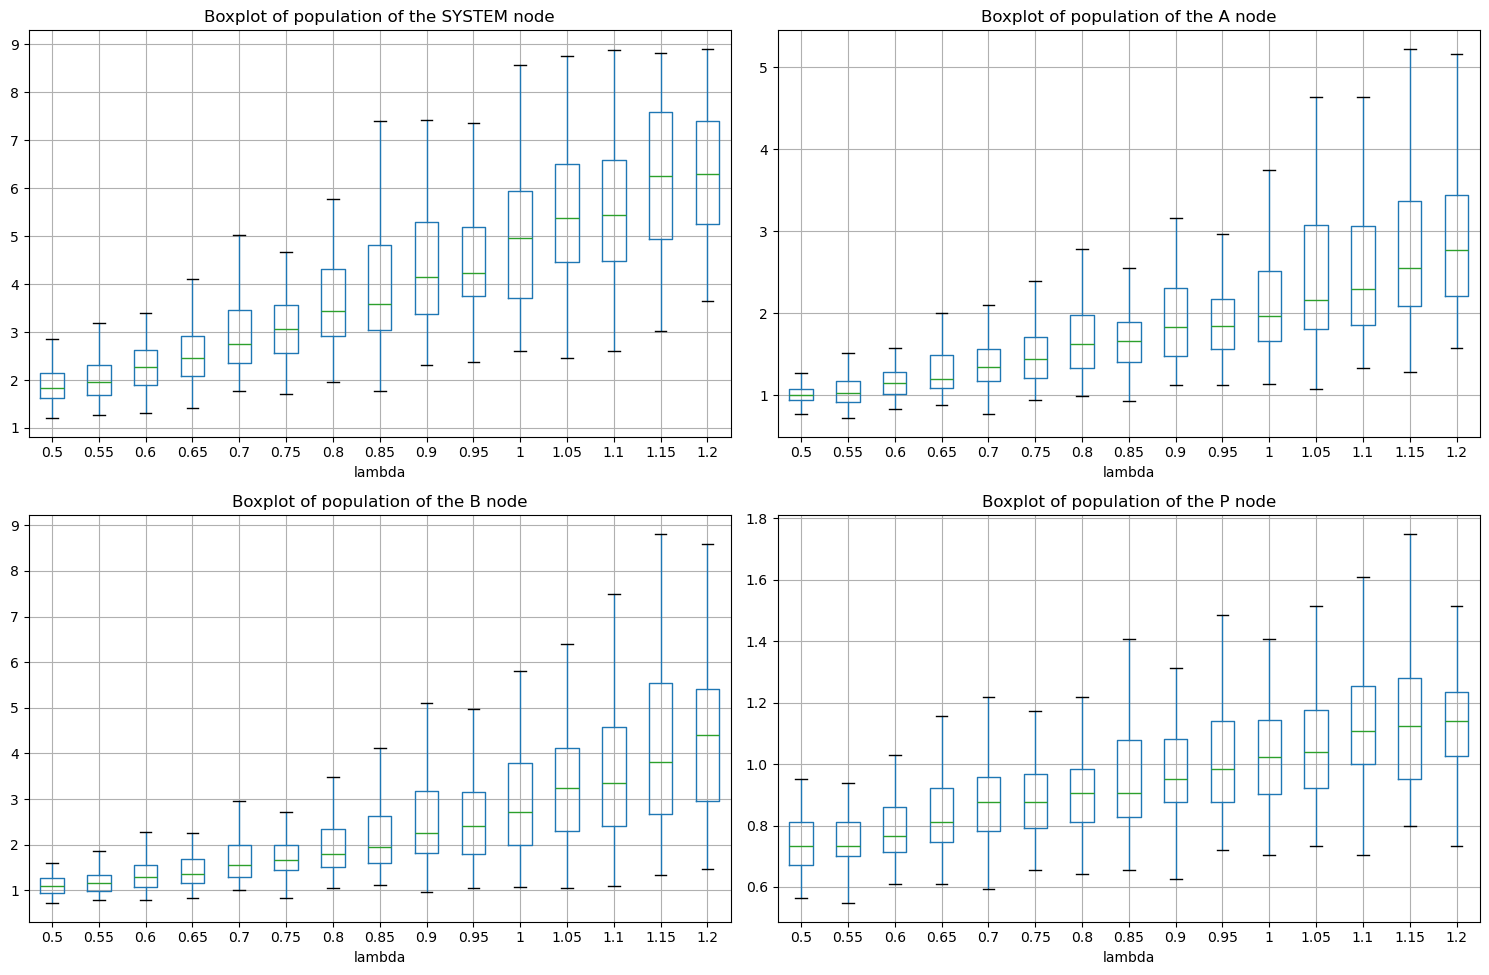

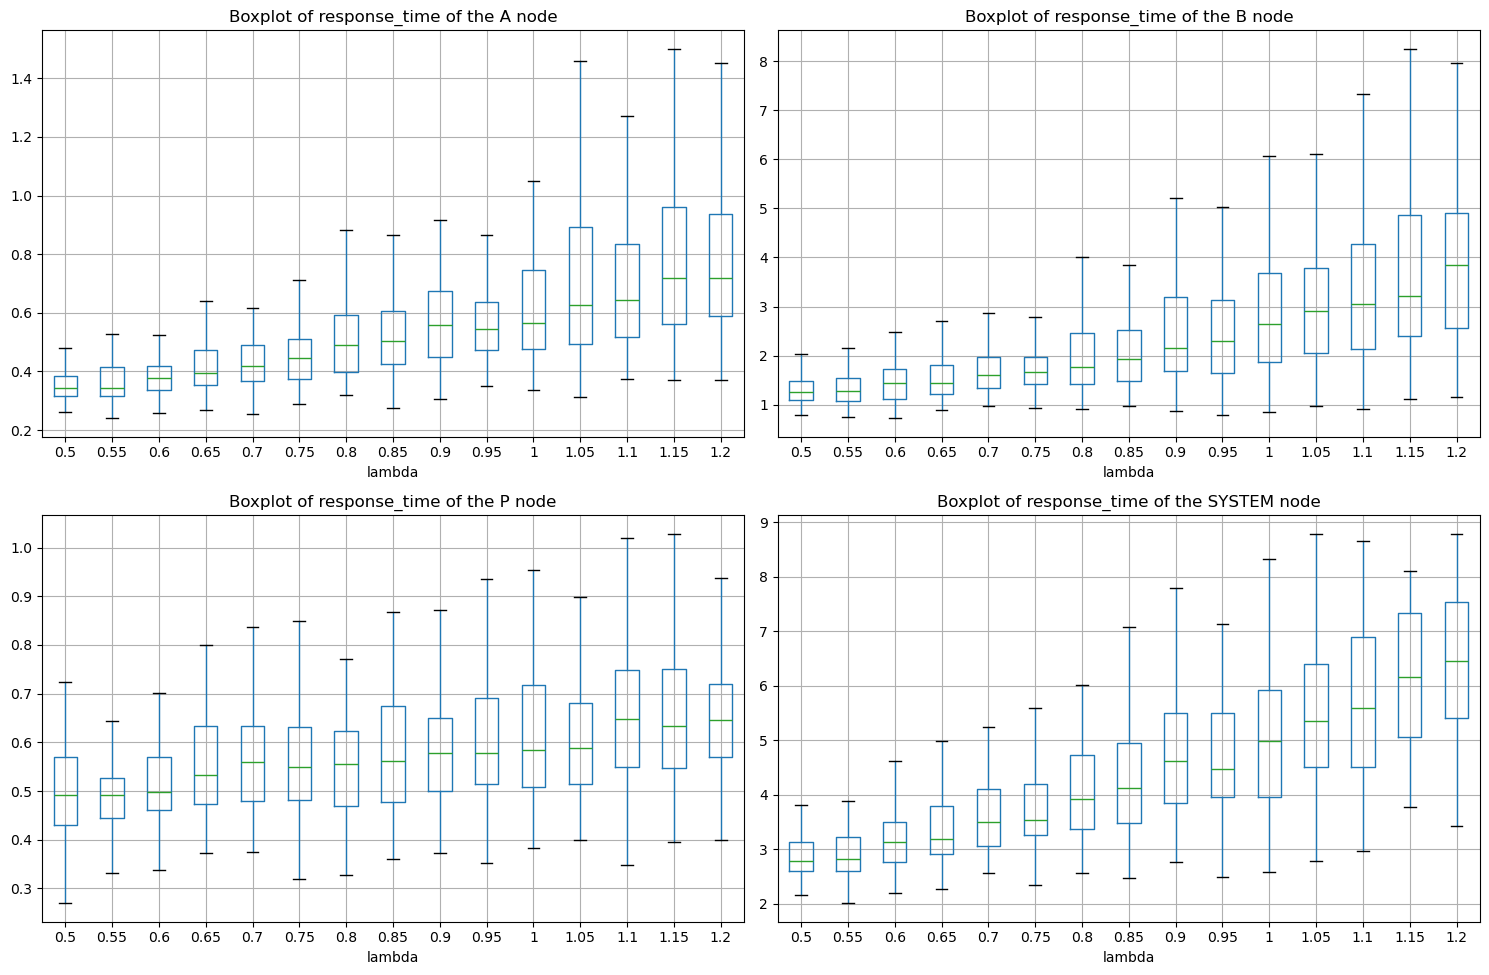

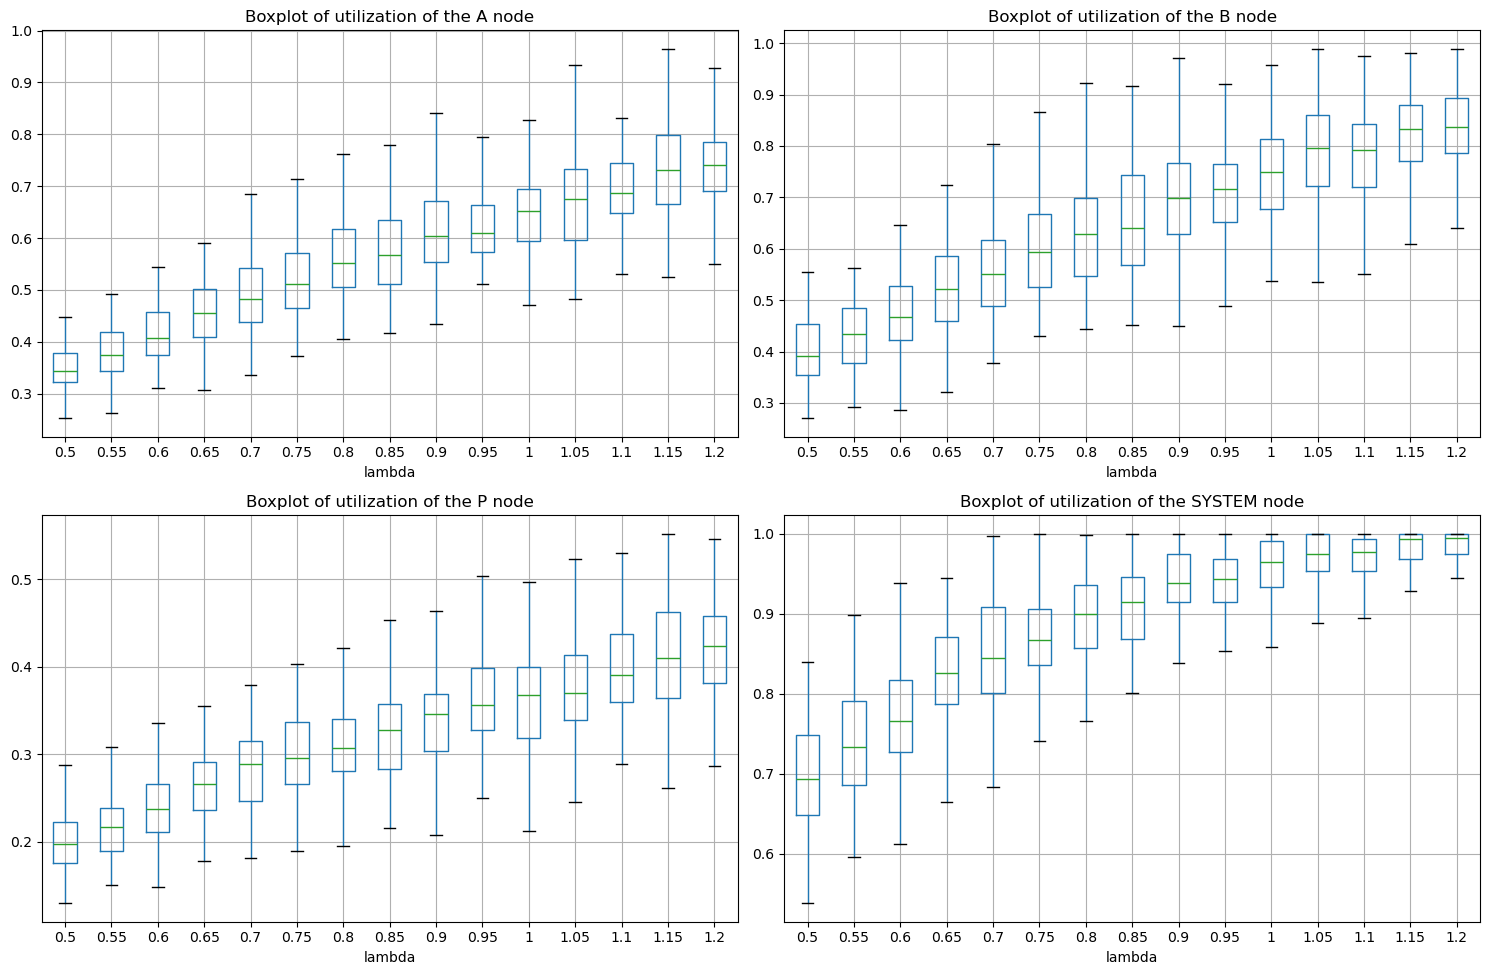

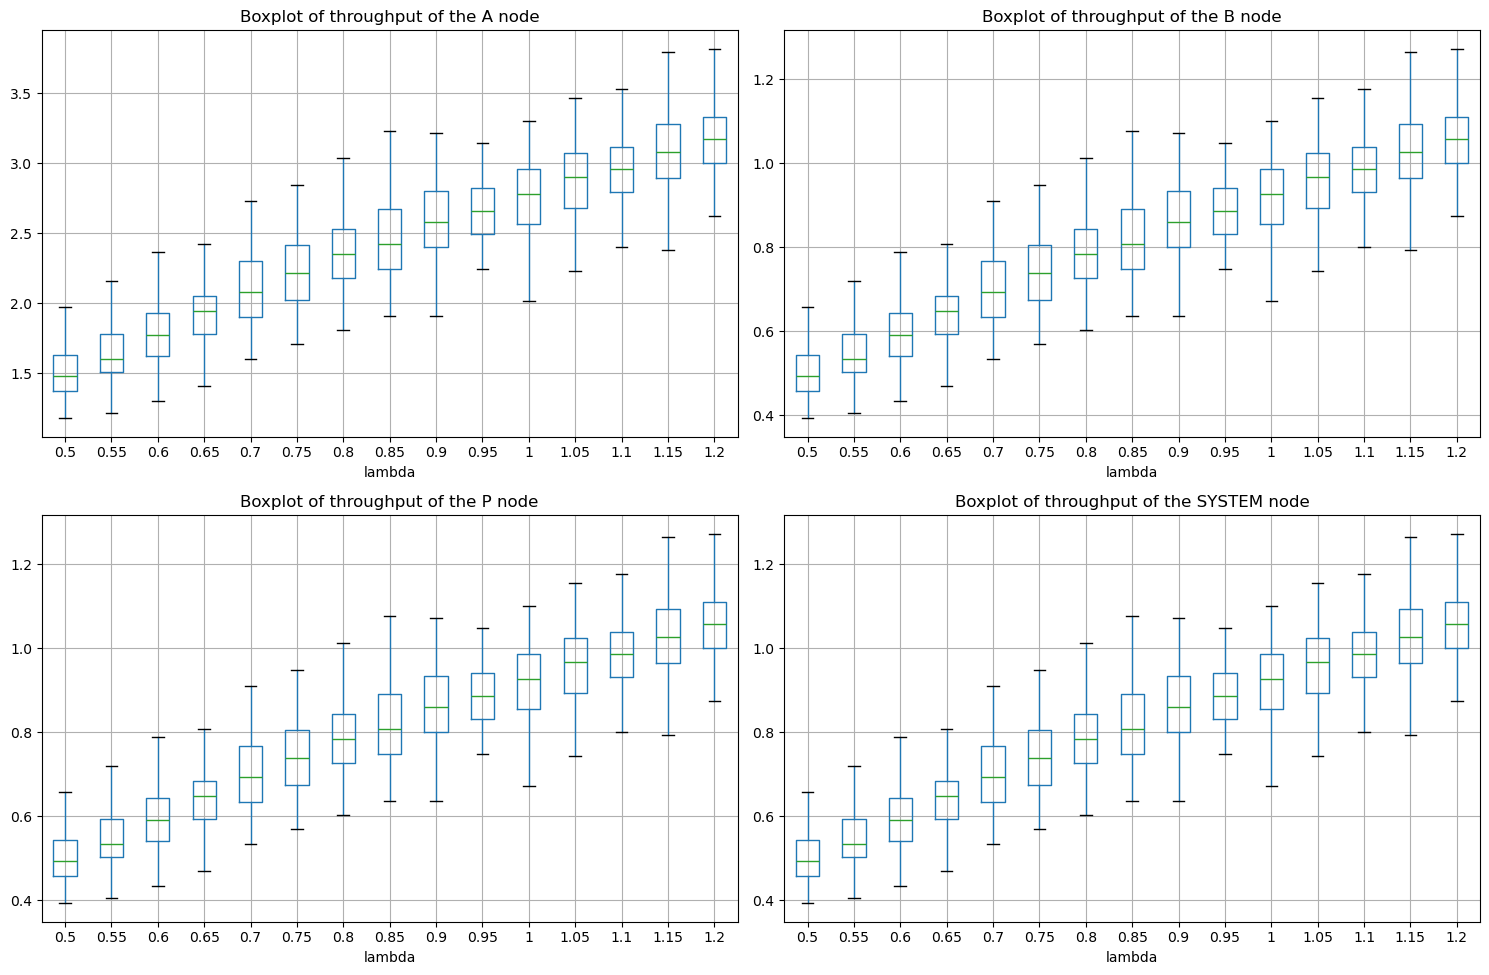

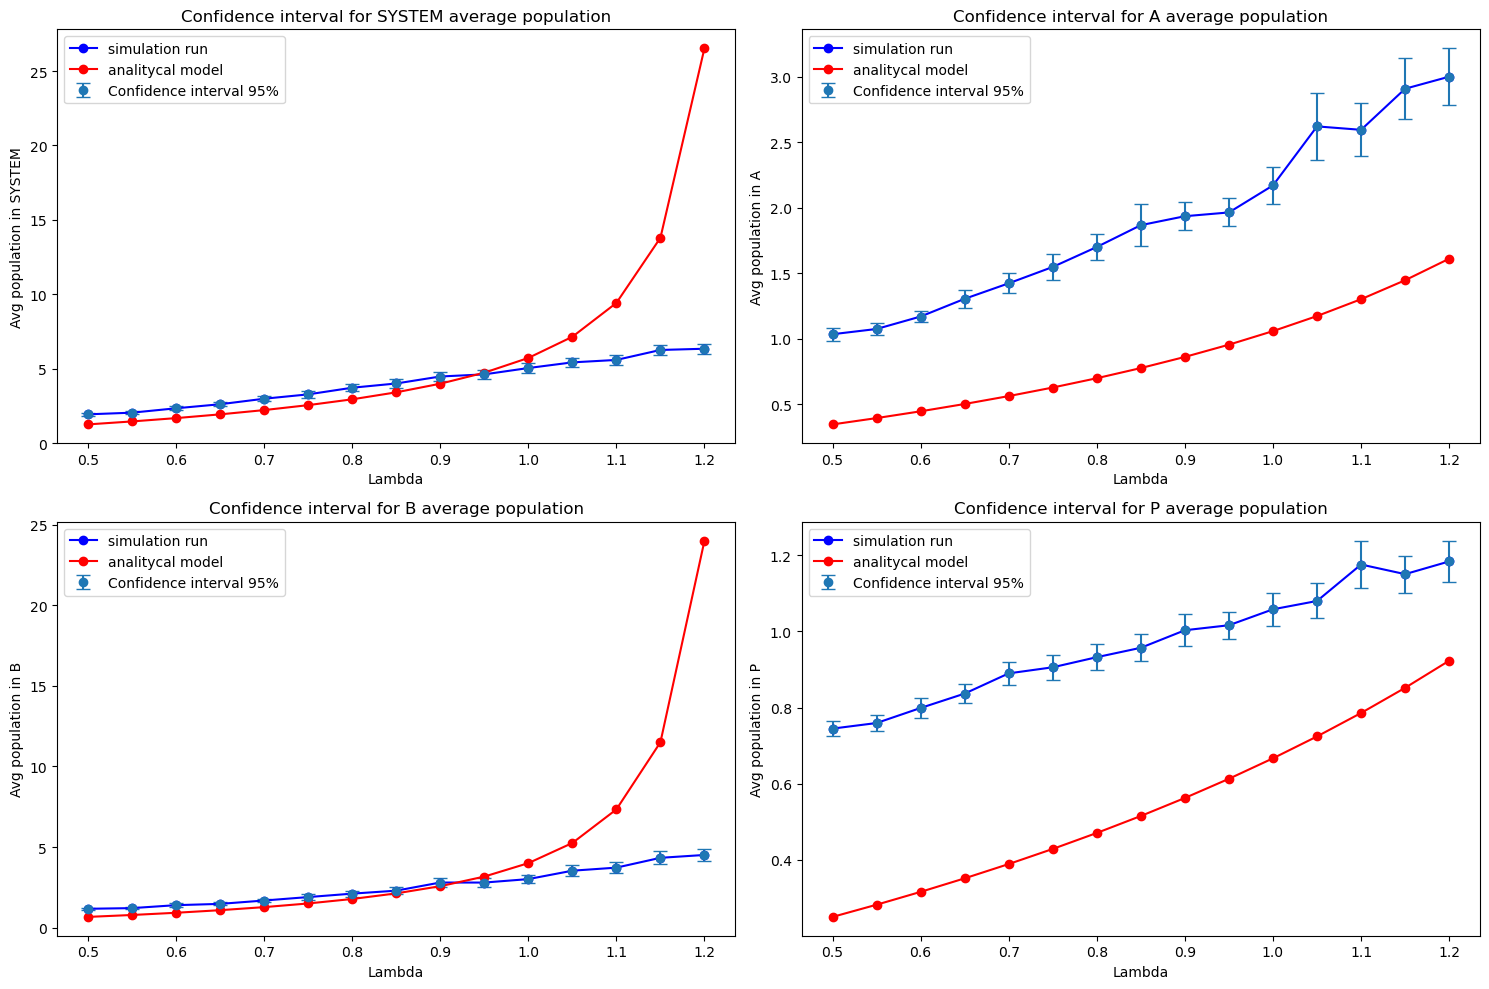

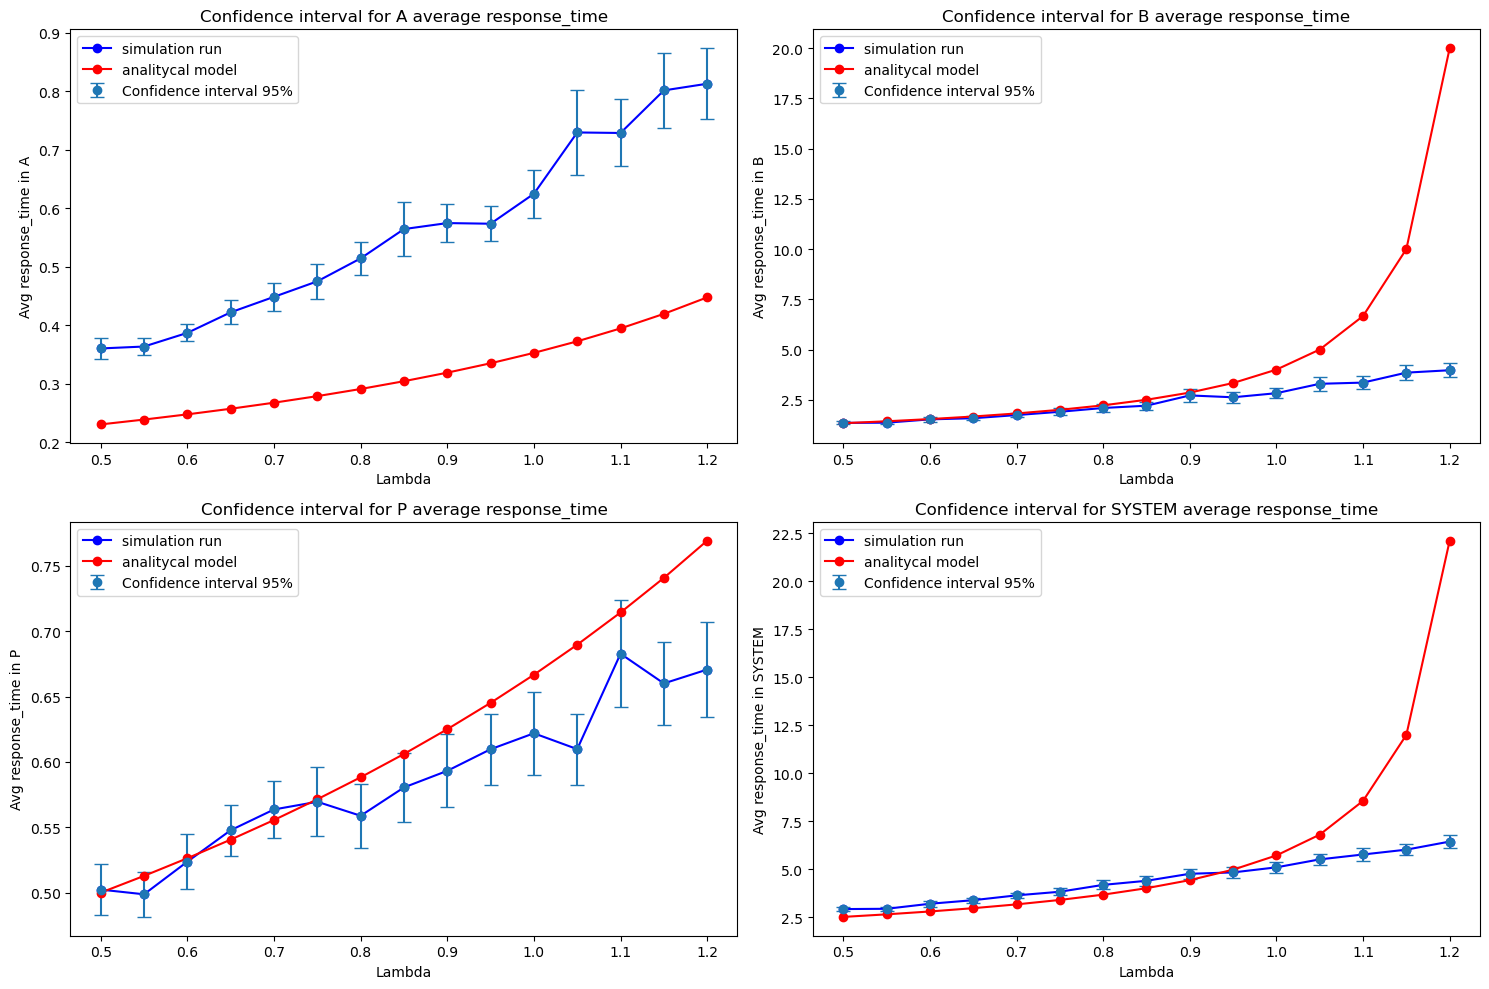

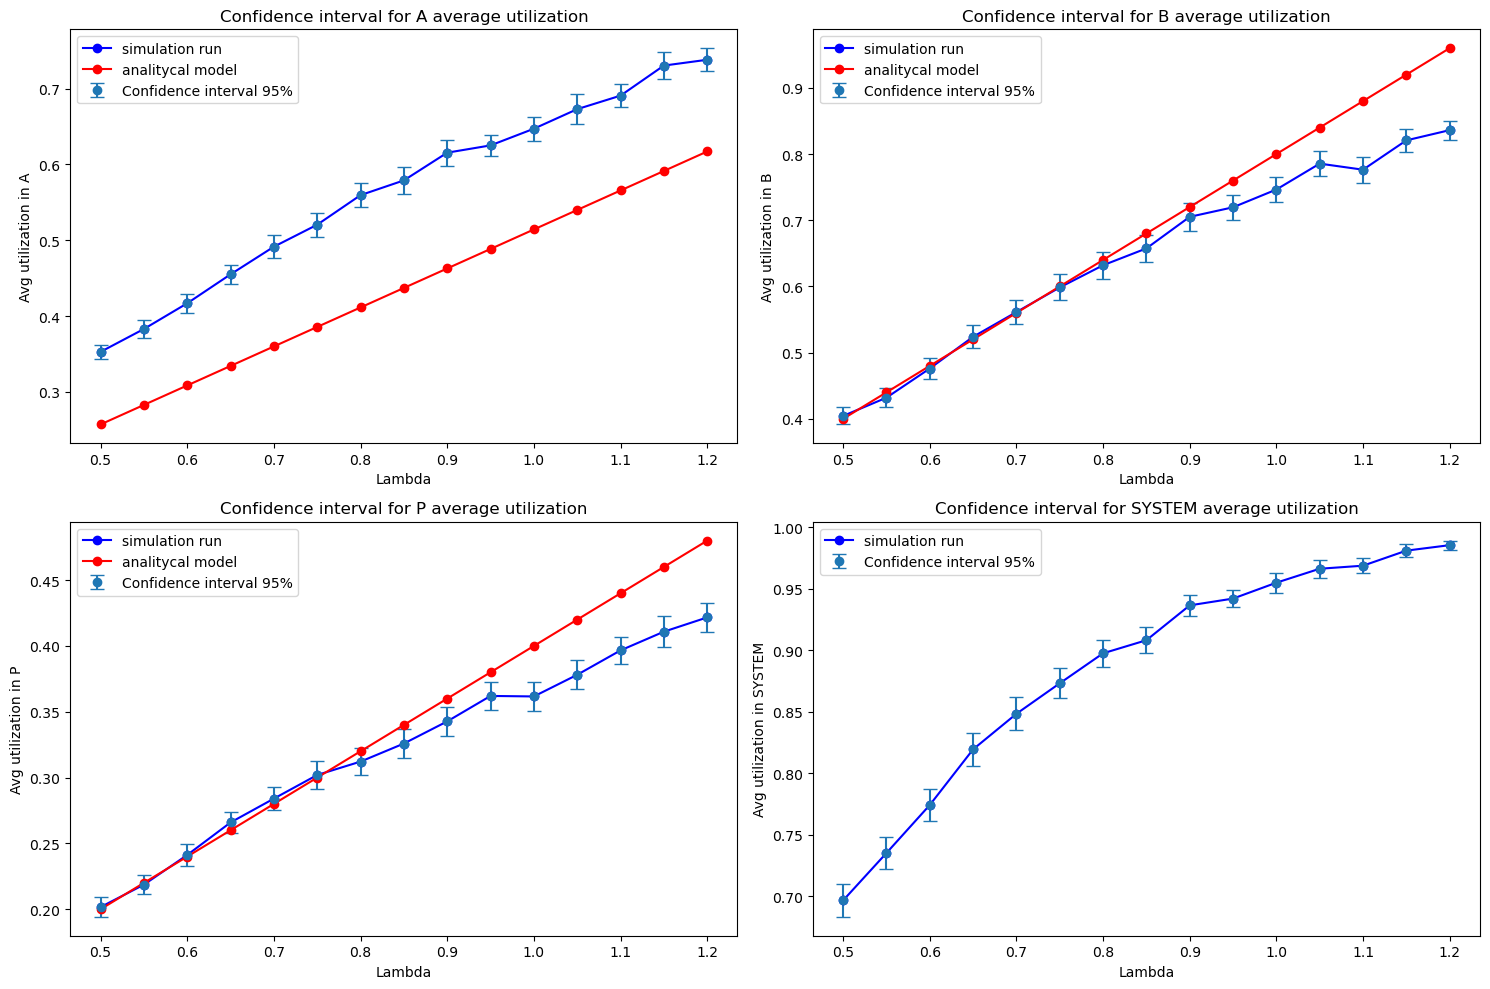

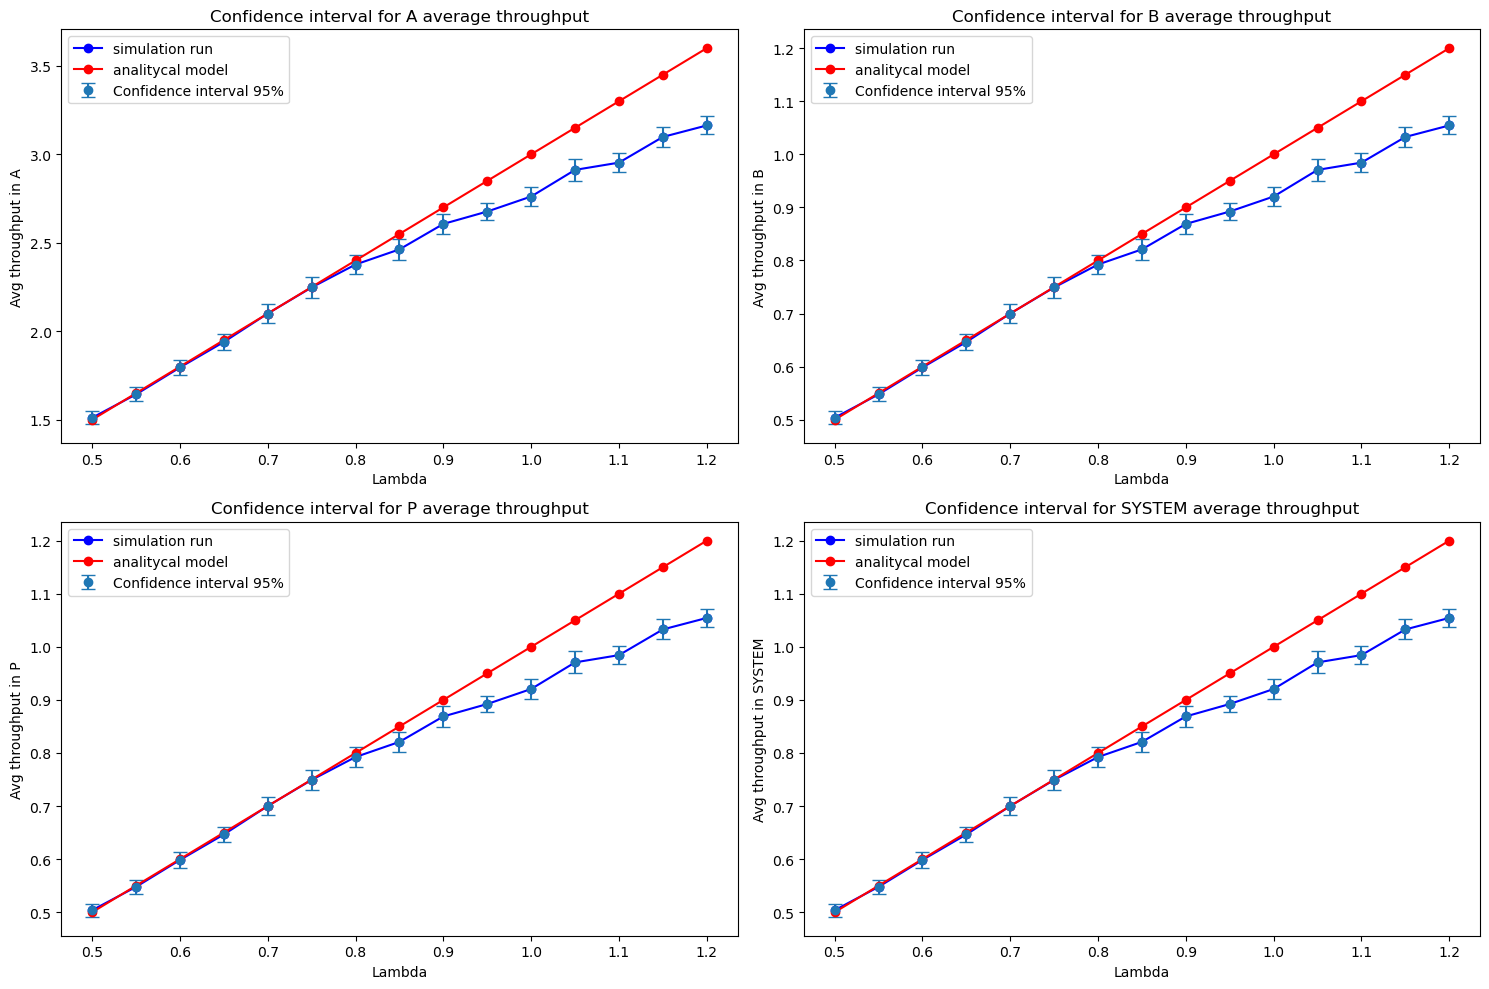

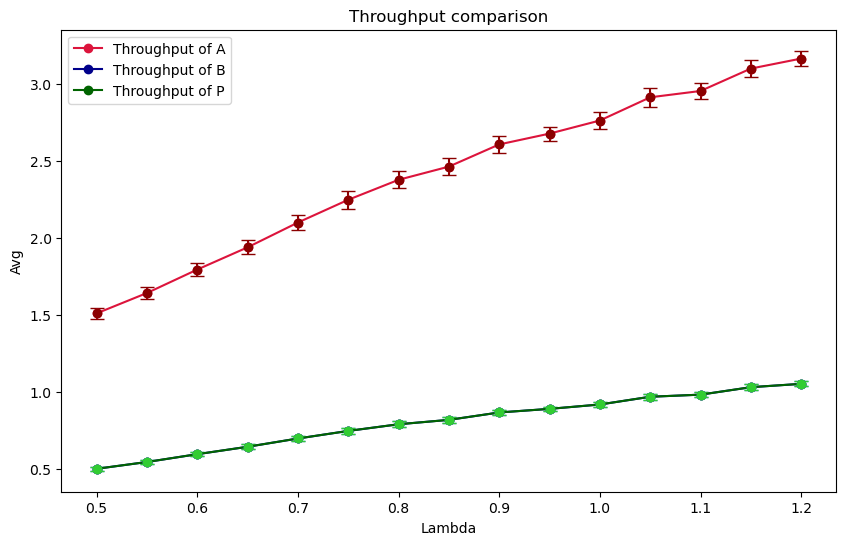

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">     diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           1.93969</td><td style="text-align: right;">           1.26282</td><td style="text-align: right;"> 0.676867</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           2.05094</td><td style="text-align: right;">           1.46219</td><td style="text-align: right;"> 0.58875 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           2.34484</td><td style="text-align: right;">           1.68515</td><td style="text-align: right;"> 0.659696</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           2.61609</td><td style="text-align: right;">           1.93683</td><td style="text-align: right;"> 0.679263</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           2.98703</td><td style="text-align: right;">           2.22412</td><td style="text-align: right;"> 0.762915</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           3.27967</td><td style="text-align: right;">           2.55648</td><td style="text-align: right;"> 0.723193</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           3.72641</td><td style="text-align: right;">           2.9474 </td><td style="text-align: right;"> 0.779011</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           4.01089</td><td style="text-align: right;">           3.4168 </td><td style="text-align: right;"> 0.594089</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           4.48043</td><td style="text-align: right;">           3.99563</td><td style="text-align: right;"> 0.484797</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           4.62337</td><td style="text-align: right;">           4.73488</td><td style="text-align: right;"> 0.111505</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           5.04956</td><td style="text-align: right;">           5.72549</td><td style="text-align: right;"> 0.675927</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           5.42931</td><td style="text-align: right;">           7.14805</td><td style="text-align: right;"> 1.71874 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           5.59334</td><td style="text-align: right;">           9.42168</td><td style="text-align: right;"> 3.82834 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           6.26313</td><td style="text-align: right;">          13.7994 </td><td style="text-align: right;"> 7.53627 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           6.34521</td><td style="text-align: right;">          26.535  </td><td style="text-align: right;">20.1898  </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.03505</td><td style="text-align: right;">          0.346154</td><td style="text-align: right;">0.688898</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>A     </td><td style="text-align: right;">           1.07516</td><td style="text-align: right;">          0.394422</td><td style="text-align: right;">0.680734</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.17031</td><td style="text-align: right;">          0.446281</td><td style="text-align: right;">0.724032</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>A     </td><td style="text-align: right;">           1.30562</td><td style="text-align: right;">          0.502146</td><td style="text-align: right;">0.803479</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.42401</td><td style="text-align: right;">          0.5625  </td><td style="text-align: right;">0.86151 </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>A     </td><td style="text-align: right;">           1.54896</td><td style="text-align: right;">          0.627907</td><td style="text-align: right;">0.921051</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.70151</td><td style="text-align: right;">          0.699029</td><td style="text-align: right;">1.00248 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>A     </td><td style="text-align: right;">           1.86828</td><td style="text-align: right;">          0.77665 </td><td style="text-align: right;">1.09163 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.93656</td><td style="text-align: right;">          0.861702</td><td style="text-align: right;">1.07486 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>A     </td><td style="text-align: right;">           1.96536</td><td style="text-align: right;">          0.955307</td><td style="text-align: right;">1.01006 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>A     </td><td style="text-align: right;">           2.17188</td><td style="text-align: right;">          1.05882 </td><td style="text-align: right;">1.11305 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>A     </td><td style="text-align: right;">           2.62266</td><td style="text-align: right;">          1.17391 </td><td style="text-align: right;">1.44874 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>A     </td><td style="text-align: right;">           2.59646</td><td style="text-align: right;">          1.30263 </td><td style="text-align: right;">1.29383 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>A     </td><td style="text-align: right;">           2.91036</td><td style="text-align: right;">          1.44755 </td><td style="text-align: right;">1.46281 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>A     </td><td style="text-align: right;">           3.0024 </td><td style="text-align: right;">          1.61194 </td><td style="text-align: right;">1.39046 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">     diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>B     </td><td style="text-align: right;">           1.17078</td><td style="text-align: right;">          0.666667</td><td style="text-align: right;"> 0.504115</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>B     </td><td style="text-align: right;">           1.21141</td><td style="text-align: right;">          0.785714</td><td style="text-align: right;"> 0.425692</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>B     </td><td style="text-align: right;">           1.39469</td><td style="text-align: right;">          0.923077</td><td style="text-align: right;"> 0.471611</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>B     </td><td style="text-align: right;">           1.47437</td><td style="text-align: right;">          1.08333 </td><td style="text-align: right;"> 0.391042</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>B     </td><td style="text-align: right;">           1.68266</td><td style="text-align: right;">          1.27273 </td><td style="text-align: right;"> 0.409929</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>B     </td><td style="text-align: right;">           1.89625</td><td style="text-align: right;">          1.5     </td><td style="text-align: right;"> 0.39625 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>B     </td><td style="text-align: right;">           2.10938</td><td style="text-align: right;">          1.77778 </td><td style="text-align: right;"> 0.331597</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>B     </td><td style="text-align: right;">           2.29344</td><td style="text-align: right;">          2.125   </td><td style="text-align: right;"> 0.168438</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>B     </td><td style="text-align: right;">           2.79861</td><td style="text-align: right;">          2.57143 </td><td style="text-align: right;"> 0.227183</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>B     </td><td style="text-align: right;">           2.79672</td><td style="text-align: right;">          3.16667 </td><td style="text-align: right;"> 0.369949</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>B     </td><td style="text-align: right;">           3.01095</td><td style="text-align: right;">          4       </td><td style="text-align: right;"> 0.989046</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>B     </td><td style="text-align: right;">           3.53257</td><td style="text-align: right;">          5.25    </td><td style="text-align: right;"> 1.71743 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>B     </td><td style="text-align: right;">           3.72274</td><td style="text-align: right;">          7.33333 </td><td style="text-align: right;"> 3.61059 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>B     </td><td style="text-align: right;">           4.33169</td><td style="text-align: right;">         11.5     </td><td style="text-align: right;"> 7.16831 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>B     </td><td style="text-align: right;">           4.50854</td><td style="text-align: right;">         24       </td><td style="text-align: right;">19.4915  </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>P     </td><td style="text-align: right;">          0.744687</td><td style="text-align: right;">          0.25    </td><td style="text-align: right;">0.494687</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>P     </td><td style="text-align: right;">          0.759375</td><td style="text-align: right;">          0.282051</td><td style="text-align: right;">0.477324</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>P     </td><td style="text-align: right;">          0.798906</td><td style="text-align: right;">          0.315789</td><td style="text-align: right;">0.483117</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>P     </td><td style="text-align: right;">          0.836719</td><td style="text-align: right;">          0.351351</td><td style="text-align: right;">0.485367</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>P     </td><td style="text-align: right;">          0.889844</td><td style="text-align: right;">          0.388889</td><td style="text-align: right;">0.500955</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>P     </td><td style="text-align: right;">          0.905781</td><td style="text-align: right;">          0.428571</td><td style="text-align: right;">0.47721 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>P     </td><td style="text-align: right;">          0.932344</td><td style="text-align: right;">          0.470588</td><td style="text-align: right;">0.461756</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>P     </td><td style="text-align: right;">          0.957031</td><td style="text-align: right;">          0.515152</td><td style="text-align: right;">0.44188 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>P     </td><td style="text-align: right;">          1.00313 </td><td style="text-align: right;">          0.5625  </td><td style="text-align: right;">0.440625</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>P     </td><td style="text-align: right;">          1.01625 </td><td style="text-align: right;">          0.612903</td><td style="text-align: right;">0.403347</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>P     </td><td style="text-align: right;">          1.05812 </td><td style="text-align: right;">          0.666667</td><td style="text-align: right;">0.391458</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>P     </td><td style="text-align: right;">          1.08    </td><td style="text-align: right;">          0.724138</td><td style="text-align: right;">0.355862</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>P     </td><td style="text-align: right;">          1.17578 </td><td style="text-align: right;">          0.785714</td><td style="text-align: right;">0.390067</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>P     </td><td style="text-align: right;">          1.15047 </td><td style="text-align: right;">          0.851852</td><td style="text-align: right;">0.298617</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>P     </td><td style="text-align: right;">          1.18391 </td><td style="text-align: right;">          0.923077</td><td style="text-align: right;">0.260829</td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.360512</td><td style="text-align: right;">          0.230769</td><td style="text-align: right;">0.129743</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.363789</td><td style="text-align: right;">          0.239044</td><td style="text-align: right;">0.124745</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.387129</td><td style="text-align: right;">          0.247934</td><td style="text-align: right;">0.139195</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.422209</td><td style="text-align: right;">          0.257511</td><td style="text-align: right;">0.164699</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.448645</td><td style="text-align: right;">          0.267857</td><td style="text-align: right;">0.180788</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.475167</td><td style="text-align: right;">          0.27907 </td><td style="text-align: right;">0.196097</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.514342</td><td style="text-align: right;">          0.291262</td><td style="text-align: right;">0.22308 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.564405</td><td style="text-align: right;">          0.304569</td><td style="text-align: right;">0.259837</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.574647</td><td style="text-align: right;">          0.319149</td><td style="text-align: right;">0.255498</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.573552</td><td style="text-align: right;">          0.335196</td><td style="text-align: right;">0.238356</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.624709</td><td style="text-align: right;">          0.352941</td><td style="text-align: right;">0.271768</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.729431</td><td style="text-align: right;">          0.372671</td><td style="text-align: right;">0.35676 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.728544</td><td style="text-align: right;">          0.394737</td><td style="text-align: right;">0.333807</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.801252</td><td style="text-align: right;">          0.41958 </td><td style="text-align: right;">0.381672</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.812641</td><td style="text-align: right;">          0.447761</td><td style="text-align: right;">0.36488 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.34952</td><td style="text-align: right;">           1.33333</td><td style="text-align: right;"> 0.0161831</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.35848</td><td style="text-align: right;">           1.42857</td><td style="text-align: right;"> 0.0700913</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.52461</td><td style="text-align: right;">           1.53846</td><td style="text-align: right;"> 0.0138471</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.58124</td><td style="text-align: right;">           1.66667</td><td style="text-align: right;"> 0.0854234</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.73759</td><td style="text-align: right;">           1.81818</td><td style="text-align: right;"> 0.0805928</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.9019 </td><td style="text-align: right;">           2      </td><td style="text-align: right;"> 0.0981025</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           2.09112</td><td style="text-align: right;">           2.22222</td><td style="text-align: right;"> 0.131106 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>B     </td><td style="text-align: right;">           2.20469</td><td style="text-align: right;">           2.5    </td><td style="text-align: right;"> 0.29531  </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           2.7158 </td><td style="text-align: right;">           2.85714</td><td style="text-align: right;"> 0.141338 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>B     </td><td style="text-align: right;">           2.62345</td><td style="text-align: right;">           3.33333</td><td style="text-align: right;"> 0.709886 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>B     </td><td style="text-align: right;">           2.82719</td><td style="text-align: right;">           4      </td><td style="text-align: right;"> 1.17281  </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>B     </td><td style="text-align: right;">           3.29463</td><td style="text-align: right;">           5      </td><td style="text-align: right;"> 1.70537  </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           3.35389</td><td style="text-align: right;">           6.66667</td><td style="text-align: right;"> 3.31278  </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>B     </td><td style="text-align: right;">           3.8501 </td><td style="text-align: right;">          10      </td><td style="text-align: right;"> 6.1499   </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           3.96969</td><td style="text-align: right;">          20      </td><td style="text-align: right;">16.0303   </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.502326</td><td style="text-align: right;">          0.5     </td><td style="text-align: right;">0.00232556</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.498736</td><td style="text-align: right;">          0.512821</td><td style="text-align: right;">0.0140843 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.52371 </td><td style="text-align: right;">          0.526316</td><td style="text-align: right;">0.0026055 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.547742</td><td style="text-align: right;">          0.540541</td><td style="text-align: right;">0.00720177</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.563625</td><td style="text-align: right;">          0.555556</td><td style="text-align: right;">0.00806938</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.569502</td><td style="text-align: right;">          0.571429</td><td style="text-align: right;">0.00192625</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.558802</td><td style="text-align: right;">          0.588235</td><td style="text-align: right;">0.0294329 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.580474</td><td style="text-align: right;">          0.606061</td><td style="text-align: right;">0.0255871 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.593167</td><td style="text-align: right;">          0.625   </td><td style="text-align: right;">0.0318332 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.609683</td><td style="text-align: right;">          0.645161</td><td style="text-align: right;">0.0354785 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.621891</td><td style="text-align: right;">          0.666667</td><td style="text-align: right;">0.0447761 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.609772</td><td style="text-align: right;">          0.689655</td><td style="text-align: right;">0.0798828 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.682743</td><td style="text-align: right;">          0.714286</td><td style="text-align: right;">0.0315432 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.660025</td><td style="text-align: right;">          0.740741</td><td style="text-align: right;">0.0807153 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.670637</td><td style="text-align: right;">          0.769231</td><td style="text-align: right;">0.0985934 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">     diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           2.93338</td><td style="text-align: right;">           2.52564</td><td style="text-align: right;"> 0.407738</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           2.94858</td><td style="text-align: right;">           2.65852</td><td style="text-align: right;"> 0.290059</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           3.20971</td><td style="text-align: right;">           2.80858</td><td style="text-align: right;"> 0.401133</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           3.39561</td><td style="text-align: right;">           2.97974</td><td style="text-align: right;"> 0.415874</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           3.64715</td><td style="text-align: right;">           3.17731</td><td style="text-align: right;"> 0.469841</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           3.83559</td><td style="text-align: right;">           3.40864</td><td style="text-align: right;"> 0.426954</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           4.19294</td><td style="text-align: right;">           3.68424</td><td style="text-align: right;"> 0.5087  </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           4.40564</td><td style="text-align: right;">           4.01977</td><td style="text-align: right;"> 0.385871</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           4.77092</td><td style="text-align: right;">           4.43959</td><td style="text-align: right;"> 0.331331</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           4.84177</td><td style="text-align: right;">           4.98408</td><td style="text-align: right;"> 0.142308</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           5.10581</td><td style="text-align: right;">           5.72549</td><td style="text-align: right;"> 0.619684</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           5.52031</td><td style="text-align: right;">           6.80767</td><td style="text-align: right;"> 1.28736 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           5.7751 </td><td style="text-align: right;">           8.56516</td><td style="text-align: right;"> 2.79006 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           6.02672</td><td style="text-align: right;">          11.9995 </td><td style="text-align: right;"> 5.97276 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           6.44736</td><td style="text-align: right;">          22.1125 </td><td style="text-align: right;">15.6652  </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric     </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">     diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.352874</td><td style="text-align: right;">          0.257143</td><td style="text-align: right;">0.0957316</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.383022</td><td style="text-align: right;">          0.282857</td><td style="text-align: right;">0.100165 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.416922</td><td style="text-align: right;">          0.308571</td><td style="text-align: right;">0.108351 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.455125</td><td style="text-align: right;">          0.334286</td><td style="text-align: right;">0.120839 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.491553</td><td style="text-align: right;">          0.36    </td><td style="text-align: right;">0.131553 </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.520587</td><td style="text-align: right;">          0.385714</td><td style="text-align: right;">0.134872 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.559577</td><td style="text-align: right;">          0.411429</td><td style="text-align: right;">0.148148 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.579021</td><td style="text-align: right;">          0.437143</td><td style="text-align: right;">0.141878 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.615576</td><td style="text-align: right;">          0.462857</td><td style="text-align: right;">0.152719 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.625178</td><td style="text-align: right;">          0.488571</td><td style="text-align: right;">0.136606 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.64717 </td><td style="text-align: right;">          0.514286</td><td style="text-align: right;">0.132884 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.672981</td><td style="text-align: right;">          0.54    </td><td style="text-align: right;">0.132981 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.690798</td><td style="text-align: right;">          0.565714</td><td style="text-align: right;">0.125084 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.73046 </td><td style="text-align: right;">          0.591429</td><td style="text-align: right;">0.139031 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.738137</td><td style="text-align: right;">          0.617143</td><td style="text-align: right;">0.120994 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric     </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.404404</td><td style="text-align: right;">              0.4 </td><td style="text-align: right;">0.00440447</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.431938</td><td style="text-align: right;">              0.44</td><td style="text-align: right;">0.00806192</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.476032</td><td style="text-align: right;">              0.48</td><td style="text-align: right;">0.003968  </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.523933</td><td style="text-align: right;">              0.52</td><td style="text-align: right;">0.00393339</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.561306</td><td style="text-align: right;">              0.56</td><td style="text-align: right;">0.00130552</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.598502</td><td style="text-align: right;">              0.6 </td><td style="text-align: right;">0.0014979 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.632001</td><td style="text-align: right;">              0.64</td><td style="text-align: right;">0.00799925</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.657455</td><td style="text-align: right;">              0.68</td><td style="text-align: right;">0.0225448 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.705163</td><td style="text-align: right;">              0.72</td><td style="text-align: right;">0.0148371 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.71957 </td><td style="text-align: right;">              0.76</td><td style="text-align: right;">0.0404302 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.746408</td><td style="text-align: right;">              0.8 </td><td style="text-align: right;">0.0535918 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.785552</td><td style="text-align: right;">              0.84</td><td style="text-align: right;">0.0544481 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.776363</td><td style="text-align: right;">              0.88</td><td style="text-align: right;">0.103637  </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.820689</td><td style="text-align: right;">              0.92</td><td style="text-align: right;">0.0993108 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.836123</td><td style="text-align: right;">              0.96</td><td style="text-align: right;">0.123877  </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric     </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.201622</td><td style="text-align: right;">              0.2 </td><td style="text-align: right;">0.00162155</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.218662</td><td style="text-align: right;">              0.22</td><td style="text-align: right;">0.00133763</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.24122 </td><td style="text-align: right;">              0.24</td><td style="text-align: right;">0.00121973</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.265925</td><td style="text-align: right;">              0.26</td><td style="text-align: right;">0.00592488</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.284027</td><td style="text-align: right;">              0.28</td><td style="text-align: right;">0.00402673</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.301977</td><td style="text-align: right;">              0.3 </td><td style="text-align: right;">0.00197672</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.312147</td><td style="text-align: right;">              0.32</td><td style="text-align: right;">0.00785347</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.325859</td><td style="text-align: right;">              0.34</td><td style="text-align: right;">0.0141412 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.342694</td><td style="text-align: right;">              0.36</td><td style="text-align: right;">0.0173062 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.362027</td><td style="text-align: right;">              0.38</td><td style="text-align: right;">0.0179734 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.361637</td><td style="text-align: right;">              0.4 </td><td style="text-align: right;">0.0383632 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.378097</td><td style="text-align: right;">              0.42</td><td style="text-align: right;">0.0419035 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.396623</td><td style="text-align: right;">              0.44</td><td style="text-align: right;">0.043377  </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.410834</td><td style="text-align: right;">              0.46</td><td style="text-align: right;">0.0491661 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.421672</td><td style="text-align: right;">              0.48</td><td style="text-align: right;">0.0583276 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">       diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           1.51121</td><td style="text-align: right;">              1.5 </td><td style="text-align: right;">0.0112066  </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>A     </td><td style="text-align: right;">           1.6433 </td><td style="text-align: right;">              1.65</td><td style="text-align: right;">0.00670267 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           1.79537</td><td style="text-align: right;">              1.8 </td><td style="text-align: right;">0.00463068 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>A     </td><td style="text-align: right;">           1.93946</td><td style="text-align: right;">              1.95</td><td style="text-align: right;">0.0105432  </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.10027</td><td style="text-align: right;">              2.1 </td><td style="text-align: right;">0.000266649</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.24781</td><td style="text-align: right;">              2.25</td><td style="text-align: right;">0.00218938 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.37718</td><td style="text-align: right;">              2.4 </td><td style="text-align: right;">0.022824   </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.46279</td><td style="text-align: right;">              2.55</td><td style="text-align: right;">0.0872059  </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.60659</td><td style="text-align: right;">              2.7 </td><td style="text-align: right;">0.0934109  </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.67669</td><td style="text-align: right;">              2.85</td><td style="text-align: right;">0.173312   </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.76157</td><td style="text-align: right;">              3   </td><td style="text-align: right;">0.238434   </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.91204</td><td style="text-align: right;">              3.15</td><td style="text-align: right;">0.237961   </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.95303</td><td style="text-align: right;">              3.3 </td><td style="text-align: right;">0.34697    </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.09819</td><td style="text-align: right;">              3.45</td><td style="text-align: right;">0.35181    </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.16319</td><td style="text-align: right;">              3.6 </td><td style="text-align: right;">0.436806   </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">       diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.503736</td><td style="text-align: right;">              0.5 </td><td style="text-align: right;">0.00373555 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.547766</td><td style="text-align: right;">              0.55</td><td style="text-align: right;">0.00223422 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.598456</td><td style="text-align: right;">              0.6 </td><td style="text-align: right;">0.00154356 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.646486</td><td style="text-align: right;">              0.65</td><td style="text-align: right;">0.00351439 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.700089</td><td style="text-align: right;">              0.7 </td><td style="text-align: right;">8.88829e-05</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.74927 </td><td style="text-align: right;">              0.75</td><td style="text-align: right;">0.000729793</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.792392</td><td style="text-align: right;">              0.8 </td><td style="text-align: right;">0.007608   </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.820931</td><td style="text-align: right;">              0.85</td><td style="text-align: right;">0.0290686  </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.868863</td><td style="text-align: right;">              0.9 </td><td style="text-align: right;">0.031137   </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.892229</td><td style="text-align: right;">              0.95</td><td style="text-align: right;">0.0577705  </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.920522</td><td style="text-align: right;">              1   </td><td style="text-align: right;">0.0794781  </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.97068 </td><td style="text-align: right;">              1.05</td><td style="text-align: right;">0.0793203  </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.984343</td><td style="text-align: right;">              1.1 </td><td style="text-align: right;">0.115657   </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.03273 </td><td style="text-align: right;">              1.15</td><td style="text-align: right;">0.11727    </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.0544  </td><td style="text-align: right;">              1.2 </td><td style="text-align: right;">0.145602   </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">       diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.503736</td><td style="text-align: right;">              0.5 </td><td style="text-align: right;">0.00373555 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.547766</td><td style="text-align: right;">              0.55</td><td style="text-align: right;">0.00223422 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.598456</td><td style="text-align: right;">              0.6 </td><td style="text-align: right;">0.00154356 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.646486</td><td style="text-align: right;">              0.65</td><td style="text-align: right;">0.00351439 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.700089</td><td style="text-align: right;">              0.7 </td><td style="text-align: right;">8.88829e-05</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.74927 </td><td style="text-align: right;">              0.75</td><td style="text-align: right;">0.000729793</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.792392</td><td style="text-align: right;">              0.8 </td><td style="text-align: right;">0.007608   </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.820931</td><td style="text-align: right;">              0.85</td><td style="text-align: right;">0.0290686  </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.868863</td><td style="text-align: right;">              0.9 </td><td style="text-align: right;">0.031137   </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.892229</td><td style="text-align: right;">              0.95</td><td style="text-align: right;">0.0577705  </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.920522</td><td style="text-align: right;">              1   </td><td style="text-align: right;">0.0794781  </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.97068 </td><td style="text-align: right;">              1.05</td><td style="text-align: right;">0.0793203  </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.984343</td><td style="text-align: right;">              1.1 </td><td style="text-align: right;">0.115657   </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.03273 </td><td style="text-align: right;">              1.15</td><td style="text-align: right;">0.11727    </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.0544  </td><td style="text-align: right;">              1.2 </td><td style="text-align: right;">0.145602   </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">       diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.503736</td><td style="text-align: right;">              0.5 </td><td style="text-align: right;">0.00373555 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.547766</td><td style="text-align: right;">              0.55</td><td style="text-align: right;">0.00223422 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.598456</td><td style="text-align: right;">              0.6 </td><td style="text-align: right;">0.00154356 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.646486</td><td style="text-align: right;">              0.65</td><td style="text-align: right;">0.00351439 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.700089</td><td style="text-align: right;">              0.7 </td><td style="text-align: right;">8.88829e-05</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.74927 </td><td style="text-align: right;">              0.75</td><td style="text-align: right;">0.000729793</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.792392</td><td style="text-align: right;">              0.8 </td><td style="text-align: right;">0.007608   </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.820931</td><td style="text-align: right;">              0.85</td><td style="text-align: right;">0.0290686  </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.868863</td><td style="text-align: right;">              0.9 </td><td style="text-align: right;">0.031137   </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.892229</td><td style="text-align: right;">              0.95</td><td style="text-align: right;">0.0577705  </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.920522</td><td style="text-align: right;">              1   </td><td style="text-align: right;">0.0794781  </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.97068 </td><td style="text-align: right;">              1.05</td><td style="text-align: right;">0.0793203  </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.984343</td><td style="text-align: right;">              1.1 </td><td style="text-align: right;">0.115657   </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.03273 </td><td style="text-align: right;">              1.15</td><td style="text-align: right;">0.11727    </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.0544  </td><td style="text-align: right;">              1.2 </td><td style="text-align: right;">0.145602   </td></tr>\n</tbody>\n</table>'

In [42]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_1", 'ReplicatedSimulation')
critical_value = scipy.stats.norm.ppf(1-.05/2)
obj = 'obj1'

metrics_nodes_avg_df_list = preprocessing(path, obj)
analitycal_perf = analitycal_preprocessing(obj)

boxplot(metrics_nodes_avg_df_list)
ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, obj)
plot_confidence_interval(ci_df, analitycal_perf)

avg_metrics_list = average_stats(metrics_nodes_avg_df_list, analitycal_perf)
for metric in avg_metrics_list:
    for node in metric:
        df = node.reset_index()
        df.drop(columns=['index'], inplace=True)
        display(tabulate(df, headers='keys', tablefmt='html', showindex=False))

## Objective 2

The model adds the functionality of two-factor authentication, observe the three metrics variation.

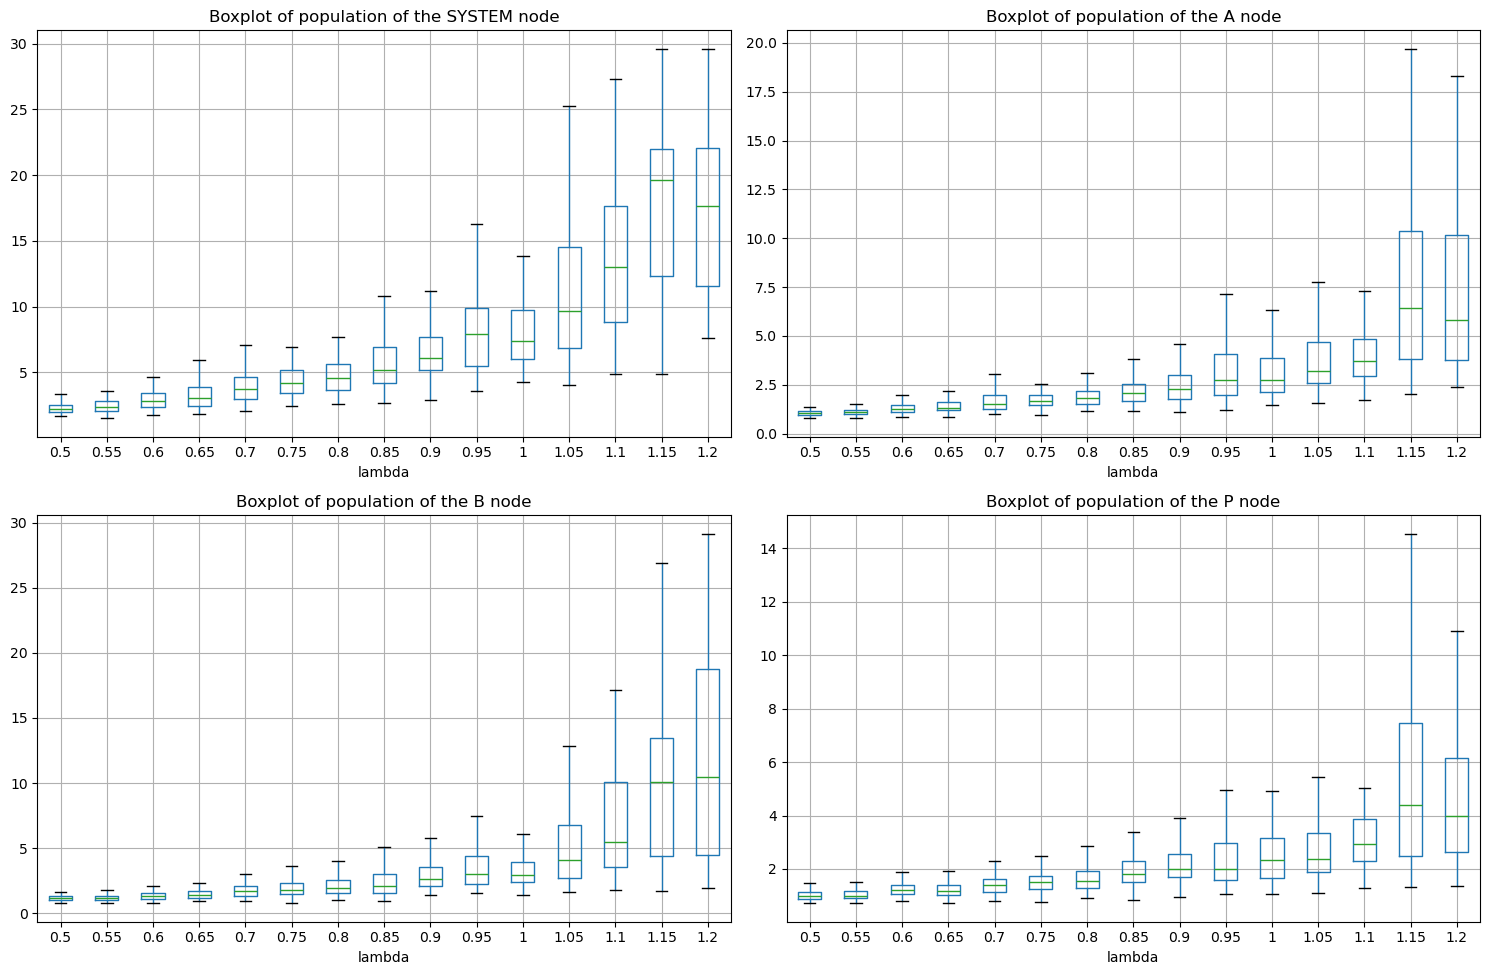

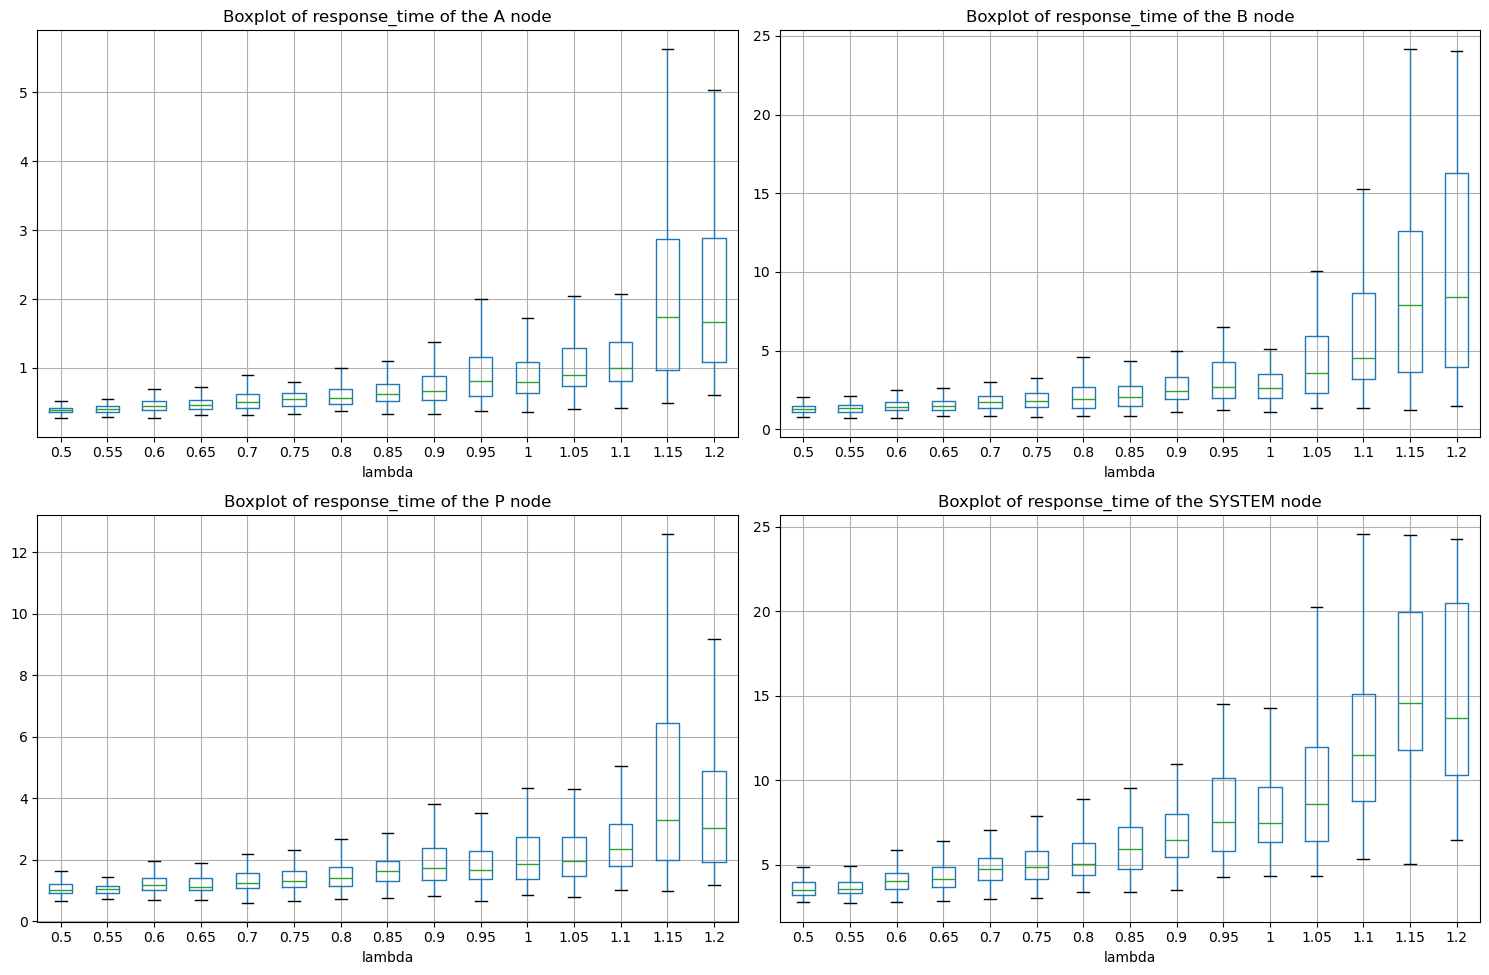

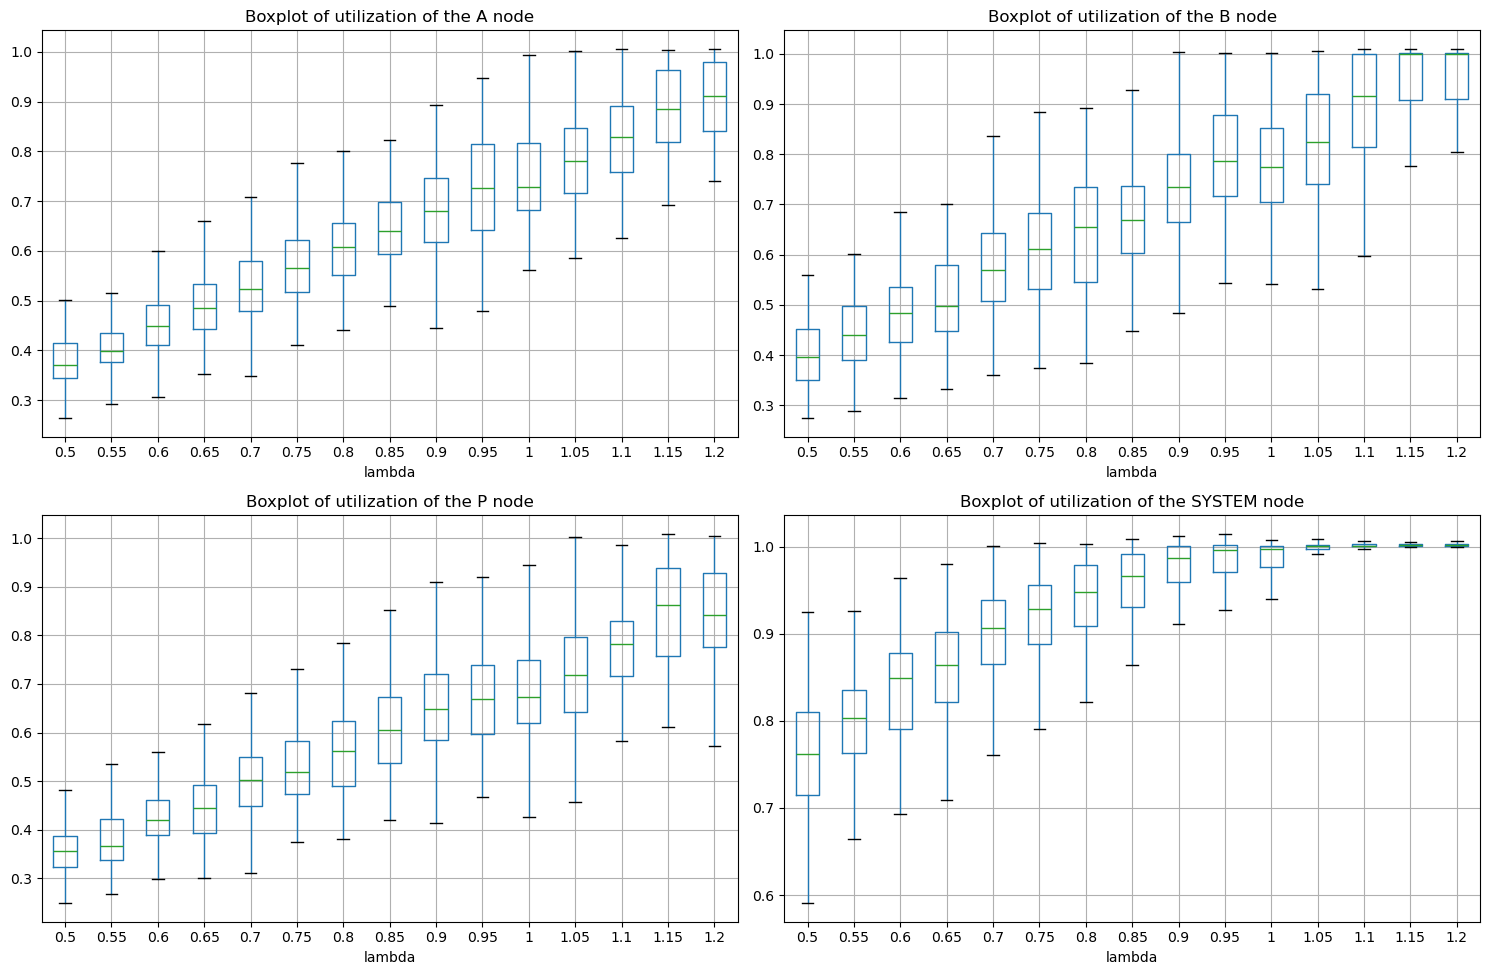

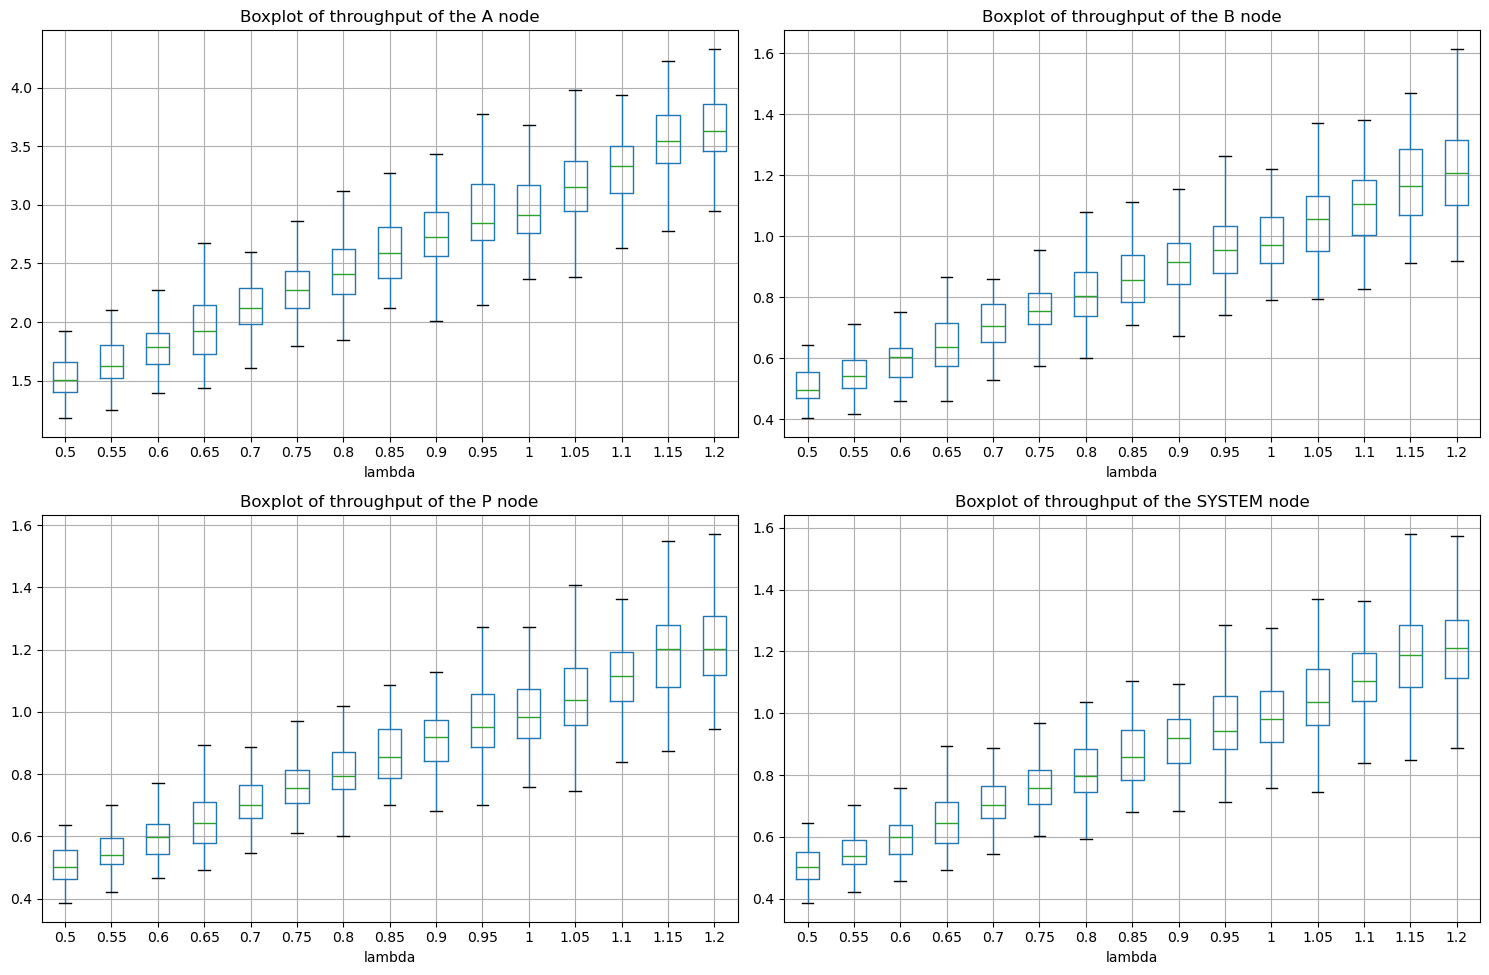

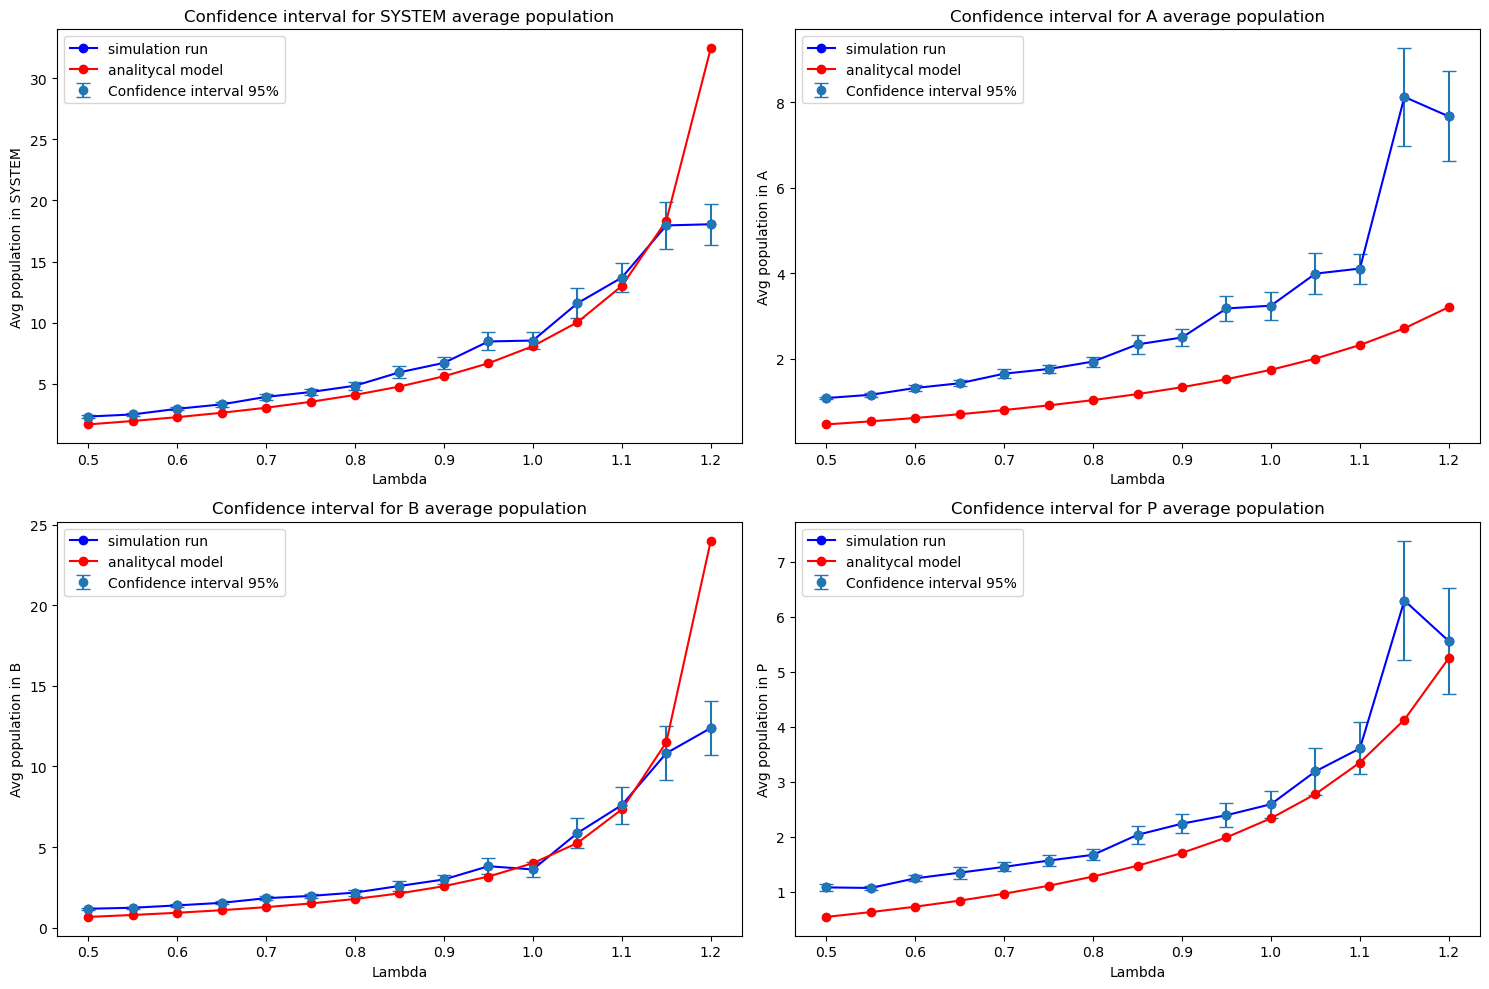

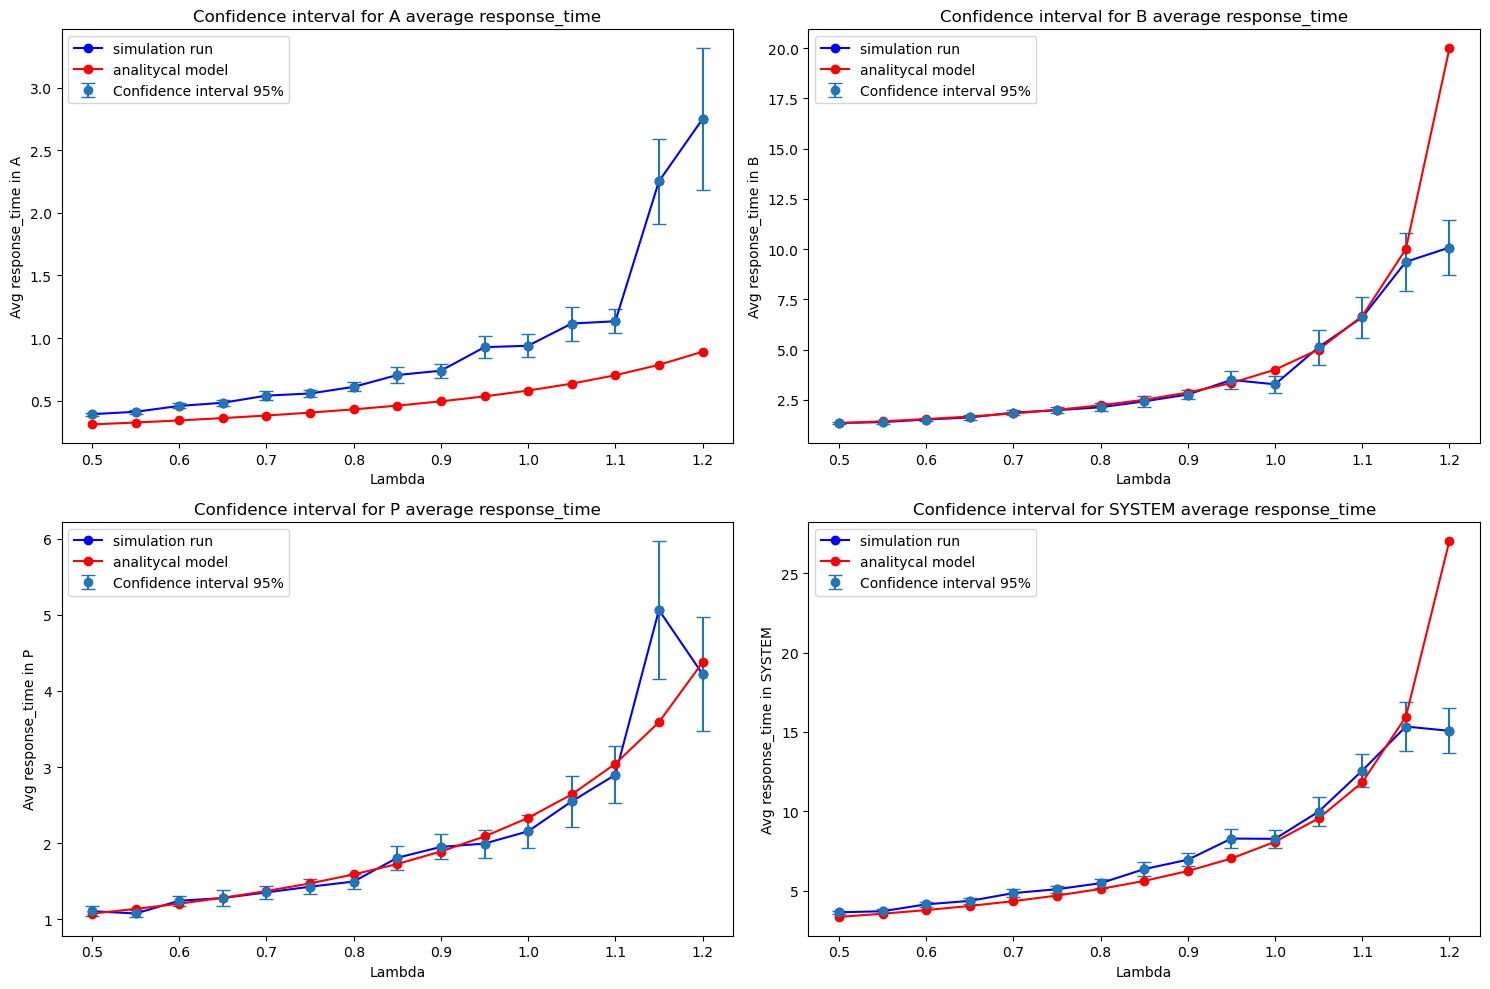

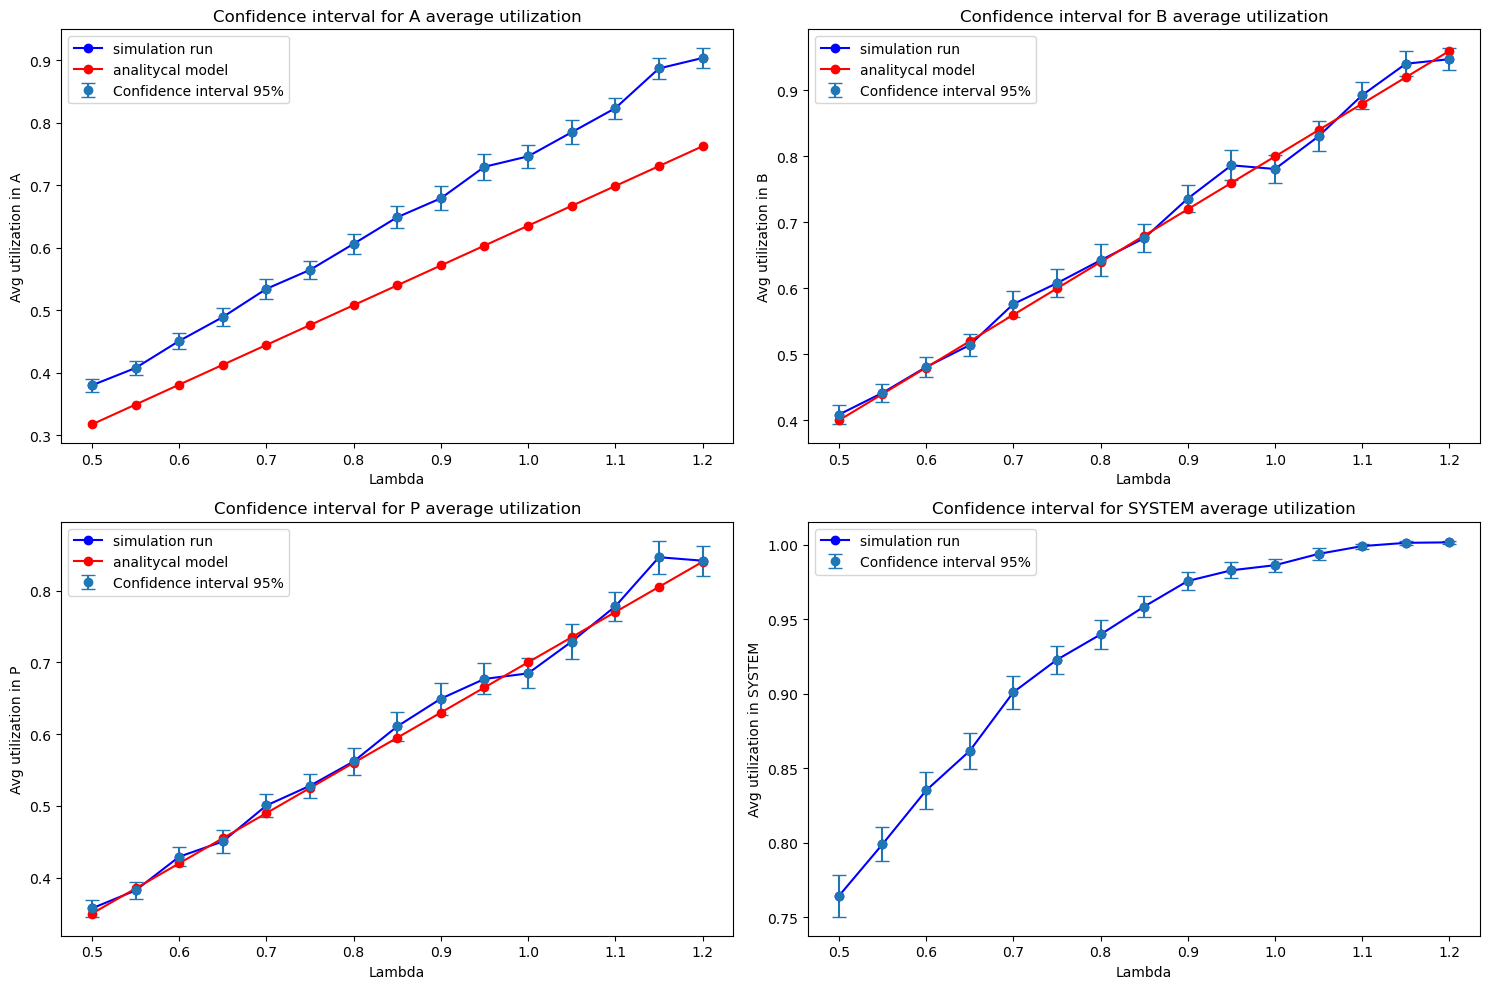

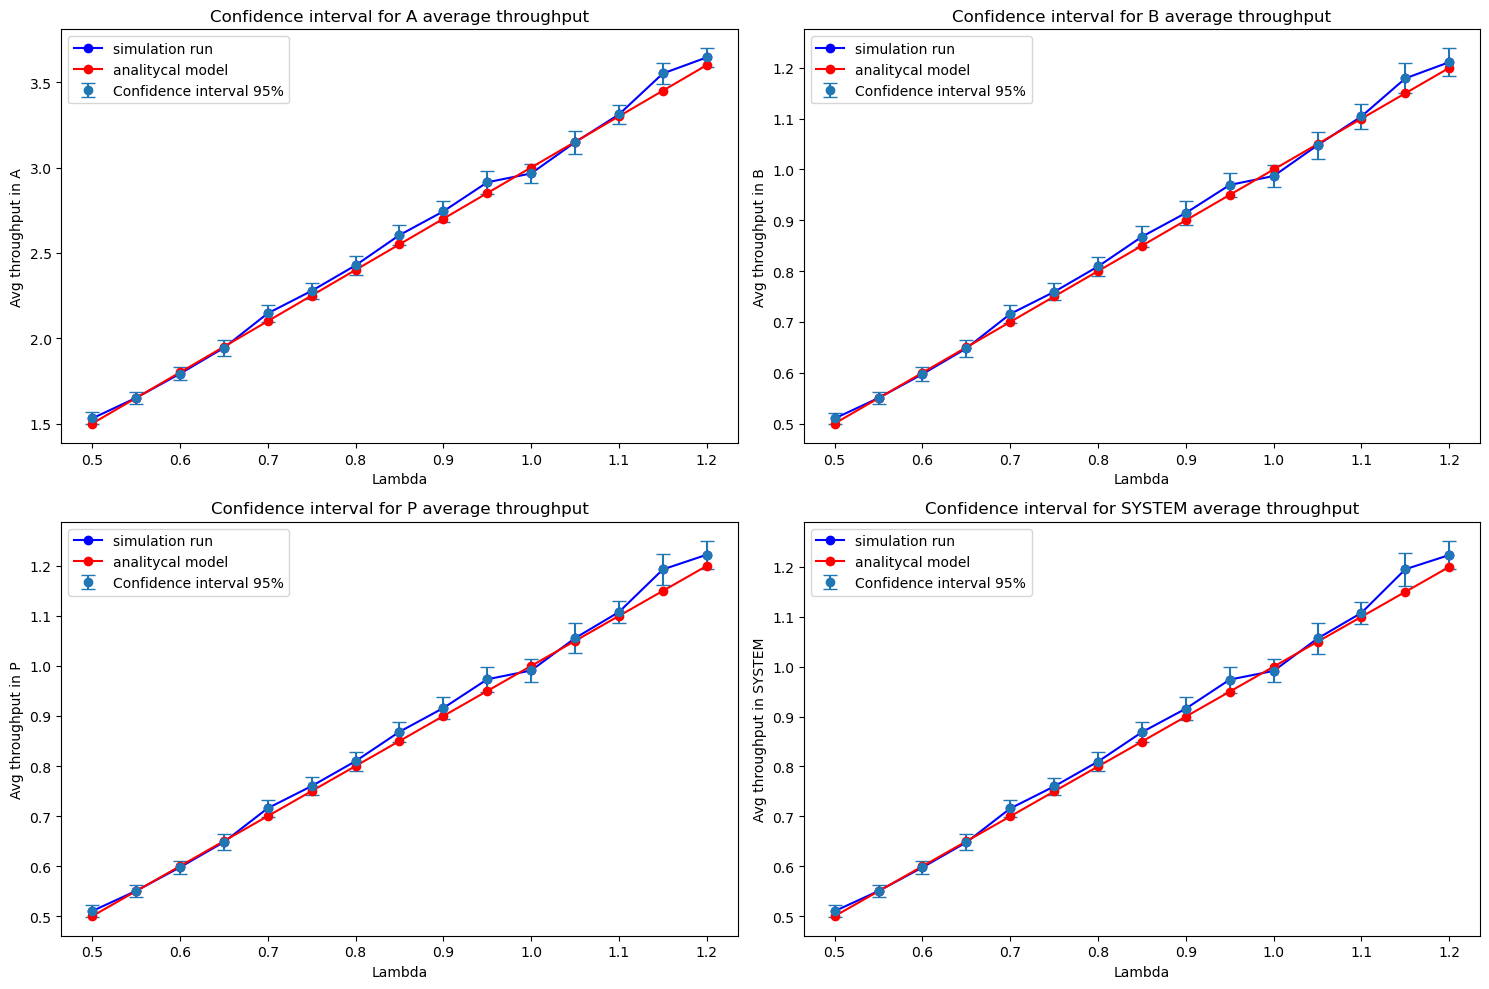

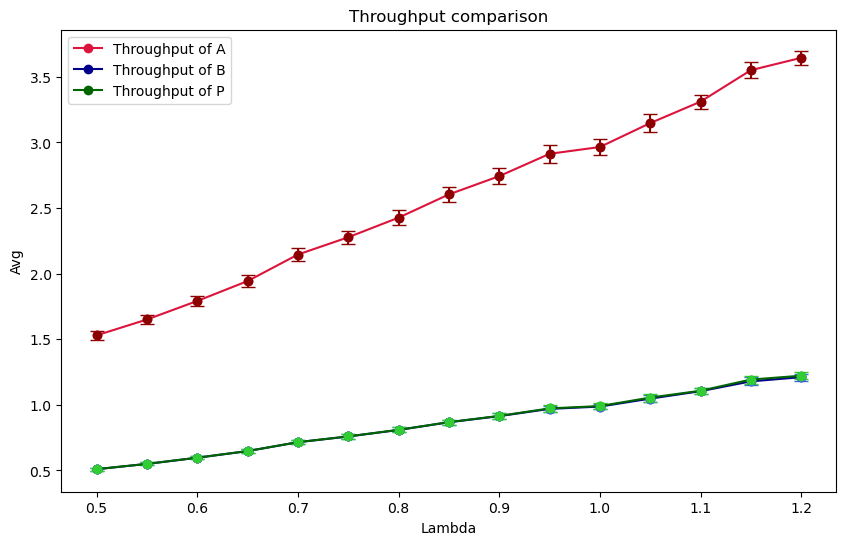

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">     diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           2.31477</td><td style="text-align: right;">           1.67065</td><td style="text-align: right;"> 0.644122</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           2.48525</td><td style="text-align: right;">           1.9488 </td><td style="text-align: right;"> 0.53645 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           2.94725</td><td style="text-align: right;">           2.26318</td><td style="text-align: right;"> 0.684062</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           3.30769</td><td style="text-align: right;">           2.6216 </td><td style="text-align: right;"> 0.686087</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           3.92239</td><td style="text-align: right;">           3.03436</td><td style="text-align: right;"> 0.888036</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           4.31761</td><td style="text-align: right;">           3.51538</td><td style="text-align: right;"> 0.802236</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           4.83674</td><td style="text-align: right;">           4.084  </td><td style="text-align: right;"> 0.752743</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           5.93394</td><td style="text-align: right;">           4.76805</td><td style="text-align: right;"> 1.16589 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           6.70596</td><td style="text-align: right;">           5.6093 </td><td style="text-align: right;"> 1.09666 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           8.45896</td><td style="text-align: right;">           6.674  </td><td style="text-align: right;"> 1.78496 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           8.53252</td><td style="text-align: right;">           8.07527</td><td style="text-align: right;"> 0.457254</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">          11.5832 </td><td style="text-align: right;">          10.0271 </td><td style="text-align: right;"> 1.55611 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">          13.6861 </td><td style="text-align: right;">          13.0015 </td><td style="text-align: right;"> 0.684676</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">          17.9528 </td><td style="text-align: right;">          18.34   </td><td style="text-align: right;"> 0.387171</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">          18.0484 </td><td style="text-align: right;">          32.4579 </td><td style="text-align: right;">14.4095  </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.08162</td><td style="text-align: right;">          0.465517</td><td style="text-align: right;">0.616099</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>A     </td><td style="text-align: right;">           1.15776</td><td style="text-align: right;">          0.537071</td><td style="text-align: right;">0.620694</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.3165 </td><td style="text-align: right;">          0.61597 </td><td style="text-align: right;">0.700527</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>A     </td><td style="text-align: right;">           1.42762</td><td style="text-align: right;">          0.703407</td><td style="text-align: right;">0.724209</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.65104</td><td style="text-align: right;">          0.800847</td><td style="text-align: right;">0.850197</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>A     </td><td style="text-align: right;">           1.76014</td><td style="text-align: right;">          0.910112</td><td style="text-align: right;">0.850028</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.93453</td><td style="text-align: right;">          1.03349 </td><td style="text-align: right;">0.901033</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>A     </td><td style="text-align: right;">           2.33514</td><td style="text-align: right;">          1.17391 </td><td style="text-align: right;">1.16122 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>A     </td><td style="text-align: right;">           2.4972 </td><td style="text-align: right;">          1.33516 </td><td style="text-align: right;">1.16203 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>A     </td><td style="text-align: right;">           3.17478</td><td style="text-align: right;">          1.52226 </td><td style="text-align: right;">1.65252 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>A     </td><td style="text-align: right;">           3.24111</td><td style="text-align: right;">          1.74194 </td><td style="text-align: right;">1.49917 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>A     </td><td style="text-align: right;">           3.98956</td><td style="text-align: right;">          2.00353 </td><td style="text-align: right;">1.98603 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>A     </td><td style="text-align: right;">           4.10783</td><td style="text-align: right;">          2.32031 </td><td style="text-align: right;">1.78752 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>A     </td><td style="text-align: right;">           8.11906</td><td style="text-align: right;">          2.71179 </td><td style="text-align: right;">5.40727 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>A     </td><td style="text-align: right;">           7.66301</td><td style="text-align: right;">          3.20792 </td><td style="text-align: right;">4.45508 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">     diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>B     </td><td style="text-align: right;">           1.17177</td><td style="text-align: right;">          0.666667</td><td style="text-align: right;"> 0.505099</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>B     </td><td style="text-align: right;">           1.23473</td><td style="text-align: right;">          0.785714</td><td style="text-align: right;"> 0.449011</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>B     </td><td style="text-align: right;">           1.37984</td><td style="text-align: right;">          0.923077</td><td style="text-align: right;"> 0.456767</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>B     </td><td style="text-align: right;">           1.53911</td><td style="text-align: right;">          1.08333 </td><td style="text-align: right;"> 0.455781</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>B     </td><td style="text-align: right;">           1.8266 </td><td style="text-align: right;">          1.27273 </td><td style="text-align: right;"> 0.553873</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>B     </td><td style="text-align: right;">           1.96868</td><td style="text-align: right;">          1.5     </td><td style="text-align: right;"> 0.468682</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>B     </td><td style="text-align: right;">           2.17563</td><td style="text-align: right;">          1.77778 </td><td style="text-align: right;"> 0.397849</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>B     </td><td style="text-align: right;">           2.58624</td><td style="text-align: right;">          2.125   </td><td style="text-align: right;"> 0.461236</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>B     </td><td style="text-align: right;">           2.98801</td><td style="text-align: right;">          2.57143 </td><td style="text-align: right;"> 0.416581</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>B     </td><td style="text-align: right;">           3.80932</td><td style="text-align: right;">          3.16667 </td><td style="text-align: right;"> 0.642649</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>B     </td><td style="text-align: right;">           3.61091</td><td style="text-align: right;">          4       </td><td style="text-align: right;"> 0.38909 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>B     </td><td style="text-align: right;">           5.86594</td><td style="text-align: right;">          5.25    </td><td style="text-align: right;"> 0.615939</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>B     </td><td style="text-align: right;">           7.60409</td><td style="text-align: right;">          7.33333 </td><td style="text-align: right;"> 0.270761</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>B     </td><td style="text-align: right;">          10.8189 </td><td style="text-align: right;">         11.5     </td><td style="text-align: right;"> 0.681097</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>B     </td><td style="text-align: right;">          12.3813 </td><td style="text-align: right;">         24       </td><td style="text-align: right;">11.6187  </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>P     </td><td style="text-align: right;">           1.07582</td><td style="text-align: right;">          0.538462</td><td style="text-align: right;">0.537361</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>P     </td><td style="text-align: right;">           1.0651 </td><td style="text-align: right;">          0.626016</td><td style="text-align: right;">0.439083</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>P     </td><td style="text-align: right;">           1.23991</td><td style="text-align: right;">          0.724138</td><td style="text-align: right;">0.515769</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>P     </td><td style="text-align: right;">           1.34324</td><td style="text-align: right;">          0.834862</td><td style="text-align: right;">0.508374</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>P     </td><td style="text-align: right;">           1.44869</td><td style="text-align: right;">          0.960784</td><td style="text-align: right;">0.487903</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>P     </td><td style="text-align: right;">           1.56357</td><td style="text-align: right;">          1.10526 </td><td style="text-align: right;">0.458309</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>P     </td><td style="text-align: right;">           1.66828</td><td style="text-align: right;">          1.27273 </td><td style="text-align: right;">0.395558</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>P     </td><td style="text-align: right;">           2.03209</td><td style="text-align: right;">          1.46914 </td><td style="text-align: right;">0.562951</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>P     </td><td style="text-align: right;">           2.23561</td><td style="text-align: right;">          1.7027  </td><td style="text-align: right;">0.532909</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>P     </td><td style="text-align: right;">           2.38919</td><td style="text-align: right;">          1.98507 </td><td style="text-align: right;">0.404112</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>P     </td><td style="text-align: right;">           2.58948</td><td style="text-align: right;">          2.33333 </td><td style="text-align: right;">0.256151</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>P     </td><td style="text-align: right;">           3.18764</td><td style="text-align: right;">          2.77358 </td><td style="text-align: right;">0.414053</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>P     </td><td style="text-align: right;">           3.605  </td><td style="text-align: right;">          3.34783 </td><td style="text-align: right;">0.257176</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>P     </td><td style="text-align: right;">           6.29643</td><td style="text-align: right;">          4.12821 </td><td style="text-align: right;">2.16823 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>P     </td><td style="text-align: right;">           5.55617</td><td style="text-align: right;">          5.25    </td><td style="text-align: right;">0.306175</td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">     diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.392194</td><td style="text-align: right;">          0.310345</td><td style="text-align: right;">0.0818487</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.411159</td><td style="text-align: right;">          0.325497</td><td style="text-align: right;">0.0856617</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.45823 </td><td style="text-align: right;">          0.342205</td><td style="text-align: right;">0.116025 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.483173</td><td style="text-align: right;">          0.360721</td><td style="text-align: right;">0.122452 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.540534</td><td style="text-align: right;">          0.381356</td><td style="text-align: right;">0.159178 </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.557293</td><td style="text-align: right;">          0.404494</td><td style="text-align: right;">0.152799 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.61051 </td><td style="text-align: right;">          0.430622</td><td style="text-align: right;">0.179888 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.704784</td><td style="text-align: right;">          0.460358</td><td style="text-align: right;">0.244426 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.739486</td><td style="text-align: right;">          0.494505</td><td style="text-align: right;">0.24498  </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.927375</td><td style="text-align: right;">          0.534125</td><td style="text-align: right;">0.39325  </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.938897</td><td style="text-align: right;">          0.580645</td><td style="text-align: right;">0.358252 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>A     </td><td style="text-align: right;">          1.11631 </td><td style="text-align: right;">          0.636042</td><td style="text-align: right;">0.480267 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          1.13439 </td><td style="text-align: right;">          0.703125</td><td style="text-align: right;">0.431262 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>A     </td><td style="text-align: right;">          2.25237 </td><td style="text-align: right;">          0.786026</td><td style="text-align: right;">1.46635  </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          2.7501  </td><td style="text-align: right;">          0.891089</td><td style="text-align: right;">1.85901  </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">     diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.34472</td><td style="text-align: right;">           1.33333</td><td style="text-align: right;">0.0113914</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.38718</td><td style="text-align: right;">           1.42857</td><td style="text-align: right;">0.0413912</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.51497</td><td style="text-align: right;">           1.53846</td><td style="text-align: right;">0.023495 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.61841</td><td style="text-align: right;">           1.66667</td><td style="text-align: right;">0.0482554</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.86108</td><td style="text-align: right;">           1.81818</td><td style="text-align: right;">0.0428948</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.97984</td><td style="text-align: right;">           2      </td><td style="text-align: right;">0.0201613</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           2.12709</td><td style="text-align: right;">           2.22222</td><td style="text-align: right;">0.0951292</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>B     </td><td style="text-align: right;">           2.42119</td><td style="text-align: right;">           2.5    </td><td style="text-align: right;">0.0788093</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           2.76168</td><td style="text-align: right;">           2.85714</td><td style="text-align: right;">0.0954642</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>B     </td><td style="text-align: right;">           3.48643</td><td style="text-align: right;">           3.33333</td><td style="text-align: right;">0.153097 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>B     </td><td style="text-align: right;">           3.26858</td><td style="text-align: right;">           4      </td><td style="text-align: right;">0.73142  </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>B     </td><td style="text-align: right;">           5.1182 </td><td style="text-align: right;">           5      </td><td style="text-align: right;">0.118197 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           6.60559</td><td style="text-align: right;">           6.66667</td><td style="text-align: right;">0.0610742</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>B     </td><td style="text-align: right;">           9.36602</td><td style="text-align: right;">          10      </td><td style="text-align: right;">0.63398  </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>B     </td><td style="text-align: right;">          10.0771 </td><td style="text-align: right;">          20      </td><td style="text-align: right;">9.92286  </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>P     </td><td style="text-align: right;">           1.10799</td><td style="text-align: right;">           1.07692</td><td style="text-align: right;">0.0310656 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>P     </td><td style="text-align: right;">           1.07831</td><td style="text-align: right;">           1.13821</td><td style="text-align: right;">0.0599012 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>P     </td><td style="text-align: right;">           1.24505</td><td style="text-align: right;">           1.2069 </td><td style="text-align: right;">0.0381528 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>P     </td><td style="text-align: right;">           1.28132</td><td style="text-align: right;">           1.2844 </td><td style="text-align: right;">0.00308308</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>P     </td><td style="text-align: right;">           1.35499</td><td style="text-align: right;">           1.37255</td><td style="text-align: right;">0.0175615 </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>P     </td><td style="text-align: right;">           1.42977</td><td style="text-align: right;">           1.47368</td><td style="text-align: right;">0.0439178 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>P     </td><td style="text-align: right;">           1.49771</td><td style="text-align: right;">           1.59091</td><td style="text-align: right;">0.0931954 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>P     </td><td style="text-align: right;">           1.80998</td><td style="text-align: right;">           1.7284 </td><td style="text-align: right;">0.0815856 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>P     </td><td style="text-align: right;">           1.95211</td><td style="text-align: right;">           1.89189</td><td style="text-align: right;">0.0602188 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>P     </td><td style="text-align: right;">           1.99632</td><td style="text-align: right;">           2.08955</td><td style="text-align: right;">0.0932281 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>P     </td><td style="text-align: right;">           2.15713</td><td style="text-align: right;">           2.33333</td><td style="text-align: right;">0.176202  </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>P     </td><td style="text-align: right;">           2.55047</td><td style="text-align: right;">           2.64151</td><td style="text-align: right;">0.0910397 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>P     </td><td style="text-align: right;">           2.89857</td><td style="text-align: right;">           3.04348</td><td style="text-align: right;">0.144905  </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>P     </td><td style="text-align: right;">           5.06222</td><td style="text-align: right;">           3.58974</td><td style="text-align: right;">1.47248   </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>P     </td><td style="text-align: right;">           4.22213</td><td style="text-align: right;">           4.375  </td><td style="text-align: right;">0.15287   </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">     diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           3.62917</td><td style="text-align: right;">           3.34129</td><td style="text-align: right;"> 0.287876</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           3.69912</td><td style="text-align: right;">           3.54327</td><td style="text-align: right;"> 0.15585 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           4.13442</td><td style="text-align: right;">           3.77197</td><td style="text-align: right;"> 0.362445</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           4.35133</td><td style="text-align: right;">           4.03323</td><td style="text-align: right;"> 0.318094</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           4.84104</td><td style="text-align: right;">           4.3348 </td><td style="text-align: right;"> 0.506239</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           5.08694</td><td style="text-align: right;">           4.68717</td><td style="text-align: right;"> 0.399769</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           5.46658</td><td style="text-align: right;">           5.105  </td><td style="text-align: right;"> 0.361585</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           6.35387</td><td style="text-align: right;">           5.60947</td><td style="text-align: right;"> 0.744404</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           6.94416</td><td style="text-align: right;">           6.23255</td><td style="text-align: right;"> 0.711612</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           8.2773 </td><td style="text-align: right;">           7.02526</td><td style="text-align: right;"> 1.25204 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           8.26154</td><td style="text-align: right;">           8.07527</td><td style="text-align: right;"> 0.186268</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           9.97411</td><td style="text-align: right;">           9.54964</td><td style="text-align: right;"> 0.424475</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">          12.5591 </td><td style="text-align: right;">          11.8195 </td><td style="text-align: right;"> 0.739541</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">          15.3363 </td><td style="text-align: right;">          15.9478 </td><td style="text-align: right;"> 0.611548</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">          15.0648 </td><td style="text-align: right;">          27.0483 </td><td style="text-align: right;">11.9835  </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric     </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">     diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.380166</td><td style="text-align: right;">          0.317647</td><td style="text-align: right;">0.0625191</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.407881</td><td style="text-align: right;">          0.349412</td><td style="text-align: right;">0.0584692</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.451097</td><td style="text-align: right;">          0.381176</td><td style="text-align: right;">0.0699206</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.489243</td><td style="text-align: right;">          0.412941</td><td style="text-align: right;">0.0763014</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.534372</td><td style="text-align: right;">          0.444706</td><td style="text-align: right;">0.0896665</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.564692</td><td style="text-align: right;">          0.476471</td><td style="text-align: right;">0.0882218</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.606364</td><td style="text-align: right;">          0.508235</td><td style="text-align: right;">0.0981283</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.648895</td><td style="text-align: right;">          0.54    </td><td style="text-align: right;">0.108895 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.679116</td><td style="text-align: right;">          0.571765</td><td style="text-align: right;">0.107352 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.729533</td><td style="text-align: right;">          0.603529</td><td style="text-align: right;">0.126003 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.746223</td><td style="text-align: right;">          0.635294</td><td style="text-align: right;">0.110929 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.784753</td><td style="text-align: right;">          0.667059</td><td style="text-align: right;">0.117694 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.823229</td><td style="text-align: right;">          0.698824</td><td style="text-align: right;">0.124405 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.88675 </td><td style="text-align: right;">          0.730588</td><td style="text-align: right;">0.156162 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.903475</td><td style="text-align: right;">          0.762353</td><td style="text-align: right;">0.141122 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric     </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">       diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.408748</td><td style="text-align: right;">              0.4 </td><td style="text-align: right;">0.00874843 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.441759</td><td style="text-align: right;">              0.44</td><td style="text-align: right;">0.00175855 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.480876</td><td style="text-align: right;">              0.48</td><td style="text-align: right;">0.000876056</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.514125</td><td style="text-align: right;">              0.52</td><td style="text-align: right;">0.00587486 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.576367</td><td style="text-align: right;">              0.56</td><td style="text-align: right;">0.0163671  </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.607968</td><td style="text-align: right;">              0.6 </td><td style="text-align: right;">0.0079683  </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.642631</td><td style="text-align: right;">              0.64</td><td style="text-align: right;">0.00263092 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.676159</td><td style="text-align: right;">              0.68</td><td style="text-align: right;">0.00384133 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.736228</td><td style="text-align: right;">              0.72</td><td style="text-align: right;">0.0162282  </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.786575</td><td style="text-align: right;">              0.76</td><td style="text-align: right;">0.0265745  </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.780997</td><td style="text-align: right;">              0.8 </td><td style="text-align: right;">0.0190027  </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.830583</td><td style="text-align: right;">              0.84</td><td style="text-align: right;">0.00941667 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.892895</td><td style="text-align: right;">              0.88</td><td style="text-align: right;">0.0128947  </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.940496</td><td style="text-align: right;">              0.92</td><td style="text-align: right;">0.020496   </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.947388</td><td style="text-align: right;">              0.96</td><td style="text-align: right;">0.0126118  </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric     </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.357295</td><td style="text-align: right;">             0.35 </td><td style="text-align: right;">0.0072954 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.382301</td><td style="text-align: right;">             0.385</td><td style="text-align: right;">0.00269932</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.429212</td><td style="text-align: right;">             0.42 </td><td style="text-align: right;">0.00921151</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.450497</td><td style="text-align: right;">             0.455</td><td style="text-align: right;">0.00450339</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.500604</td><td style="text-align: right;">             0.49 </td><td style="text-align: right;">0.0106045 </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.528066</td><td style="text-align: right;">             0.525</td><td style="text-align: right;">0.00306565</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.561925</td><td style="text-align: right;">             0.56 </td><td style="text-align: right;">0.0019255 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.610744</td><td style="text-align: right;">             0.595</td><td style="text-align: right;">0.015744  </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.649347</td><td style="text-align: right;">             0.63 </td><td style="text-align: right;">0.0193468 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.676859</td><td style="text-align: right;">             0.665</td><td style="text-align: right;">0.0118588 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.684597</td><td style="text-align: right;">             0.7  </td><td style="text-align: right;">0.0154026 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.728878</td><td style="text-align: right;">             0.735</td><td style="text-align: right;">0.00612186</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.77794 </td><td style="text-align: right;">             0.77 </td><td style="text-align: right;">0.00794017</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.84638 </td><td style="text-align: right;">             0.805</td><td style="text-align: right;">0.0413798 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.841551</td><td style="text-align: right;">             0.84 </td><td style="text-align: right;">0.001551  </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">       diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           1.53019</td><td style="text-align: right;">              1.5 </td><td style="text-align: right;">0.0301934  </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>A     </td><td style="text-align: right;">           1.65076</td><td style="text-align: right;">              1.65</td><td style="text-align: right;">0.000756392</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           1.79207</td><td style="text-align: right;">              1.8 </td><td style="text-align: right;">0.00792772 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>A     </td><td style="text-align: right;">           1.9436 </td><td style="text-align: right;">              1.95</td><td style="text-align: right;">0.00639698 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.14591</td><td style="text-align: right;">              2.1 </td><td style="text-align: right;">0.0459066  </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.27757</td><td style="text-align: right;">              2.25</td><td style="text-align: right;">0.0275707  </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.42683</td><td style="text-align: right;">              2.4 </td><td style="text-align: right;">0.0268279  </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.60409</td><td style="text-align: right;">              2.55</td><td style="text-align: right;">0.0540863  </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.74317</td><td style="text-align: right;">              2.7 </td><td style="text-align: right;">0.0431695  </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.91333</td><td style="text-align: right;">              2.85</td><td style="text-align: right;">0.0633343  </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.96527</td><td style="text-align: right;">              3   </td><td style="text-align: right;">0.034728   </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.14755</td><td style="text-align: right;">              3.15</td><td style="text-align: right;">0.0024511  </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.31088</td><td style="text-align: right;">              3.3 </td><td style="text-align: right;">0.0108836  </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.55075</td><td style="text-align: right;">              3.45</td><td style="text-align: right;">0.100747   </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.64492</td><td style="text-align: right;">              3.6 </td><td style="text-align: right;">0.0449226  </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">       diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.509964</td><td style="text-align: right;">              0.5 </td><td style="text-align: right;">0.00996383 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.550221</td><td style="text-align: right;">              0.55</td><td style="text-align: right;">0.000220617</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.597206</td><td style="text-align: right;">              0.6 </td><td style="text-align: right;">0.00279394 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.647946</td><td style="text-align: right;">              0.65</td><td style="text-align: right;">0.00205446 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.715646</td><td style="text-align: right;">              0.7 </td><td style="text-align: right;">0.0156461  </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.759147</td><td style="text-align: right;">              0.75</td><td style="text-align: right;">0.00914673 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.809158</td><td style="text-align: right;">              0.8 </td><td style="text-align: right;">0.00915785 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.8677  </td><td style="text-align: right;">              0.85</td><td style="text-align: right;">0.0176998  </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.914395</td><td style="text-align: right;">              0.9 </td><td style="text-align: right;">0.0143948  </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.969558</td><td style="text-align: right;">              0.95</td><td style="text-align: right;">0.0195578  </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.987141</td><td style="text-align: right;">              1   </td><td style="text-align: right;">0.0128593  </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.04775 </td><td style="text-align: right;">              1.05</td><td style="text-align: right;">0.002253   </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.10445 </td><td style="text-align: right;">              1.1 </td><td style="text-align: right;">0.00444807 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.17933 </td><td style="text-align: right;">              1.15</td><td style="text-align: right;">0.0293271  </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.21122 </td><td style="text-align: right;">              1.2 </td><td style="text-align: right;">0.0112197  </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">       diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.510164</td><td style="text-align: right;">              0.5 </td><td style="text-align: right;">0.0101644  </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.550458</td><td style="text-align: right;">              0.55</td><td style="text-align: right;">0.000457875</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.597682</td><td style="text-align: right;">              0.6 </td><td style="text-align: right;">0.00231843 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.647987</td><td style="text-align: right;">              0.65</td><td style="text-align: right;">0.00201265 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.715773</td><td style="text-align: right;">              0.7 </td><td style="text-align: right;">0.0157727  </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.759961</td><td style="text-align: right;">              0.75</td><td style="text-align: right;">0.00996149 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.809755</td><td style="text-align: right;">              0.8 </td><td style="text-align: right;">0.00975481 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.868443</td><td style="text-align: right;">              0.85</td><td style="text-align: right;">0.0184434  </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.915934</td><td style="text-align: right;">              0.9 </td><td style="text-align: right;">0.0159343  </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.973333</td><td style="text-align: right;">              0.95</td><td style="text-align: right;">0.0233327  </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.99095 </td><td style="text-align: right;">              1   </td><td style="text-align: right;">0.00904975 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.05561 </td><td style="text-align: right;">              1.05</td><td style="text-align: right;">0.00560633 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.10775 </td><td style="text-align: right;">              1.1 </td><td style="text-align: right;">0.0077534  </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.19287 </td><td style="text-align: right;">              1.15</td><td style="text-align: right;">0.0428738  </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.22225 </td><td style="text-align: right;">              1.2 </td><td style="text-align: right;">0.0222537  </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">       diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.510085</td><td style="text-align: right;">              0.5 </td><td style="text-align: right;">0.0100851  </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.550396</td><td style="text-align: right;">              0.55</td><td style="text-align: right;">0.000395902</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.597689</td><td style="text-align: right;">              0.6 </td><td style="text-align: right;">0.00231055 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.647886</td><td style="text-align: right;">              0.65</td><td style="text-align: right;">0.00211442 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.715883</td><td style="text-align: right;">              0.7 </td><td style="text-align: right;">0.0158826  </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.760031</td><td style="text-align: right;">              0.75</td><td style="text-align: right;">0.0100309  </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.80981 </td><td style="text-align: right;">              0.8 </td><td style="text-align: right;">0.00980968 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.868763</td><td style="text-align: right;">              0.85</td><td style="text-align: right;">0.0187628  </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.915907</td><td style="text-align: right;">              0.9 </td><td style="text-align: right;">0.015907   </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.974101</td><td style="text-align: right;">              0.95</td><td style="text-align: right;">0.024101   </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.991519</td><td style="text-align: right;">              1   </td><td style="text-align: right;">0.00848147 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.0565  </td><td style="text-align: right;">              1.05</td><td style="text-align: right;">0.00649602 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.10784 </td><td style="text-align: right;">              1.1 </td><td style="text-align: right;">0.00784191 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.19526 </td><td style="text-align: right;">              1.15</td><td style="text-align: right;">0.0452634  </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.2237  </td><td style="text-align: right;">              1.2 </td><td style="text-align: right;">0.0237043  </td></tr>\n</tbody>\n</table>'

In [43]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_2", 'BatchMeansSimulation')
critical_value = scipy.stats.norm.ppf(1-.05/2)
obj = 'obj2'

metrics_nodes_avg_df_list = preprocessing(path, obj)
analitycal_perf = analitycal_preprocessing(obj)

boxplot(metrics_nodes_avg_df_list)

ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, obj)
plot_confidence_interval(ci_df, analitycal_perf)

avg_metrics_list = average_stats(metrics_nodes_avg_df_list, analitycal_perf)
for metric in avg_metrics_list:
    for node in metric:
        df = node.reset_index()
        df.drop(columns=['index'], inplace=True)
        display(tabulate(df, headers='keys', tablefmt='html', showindex=False))

## Objective 3

Measure the metrics with an increased workload from 4200 req/h to 5000 req/h

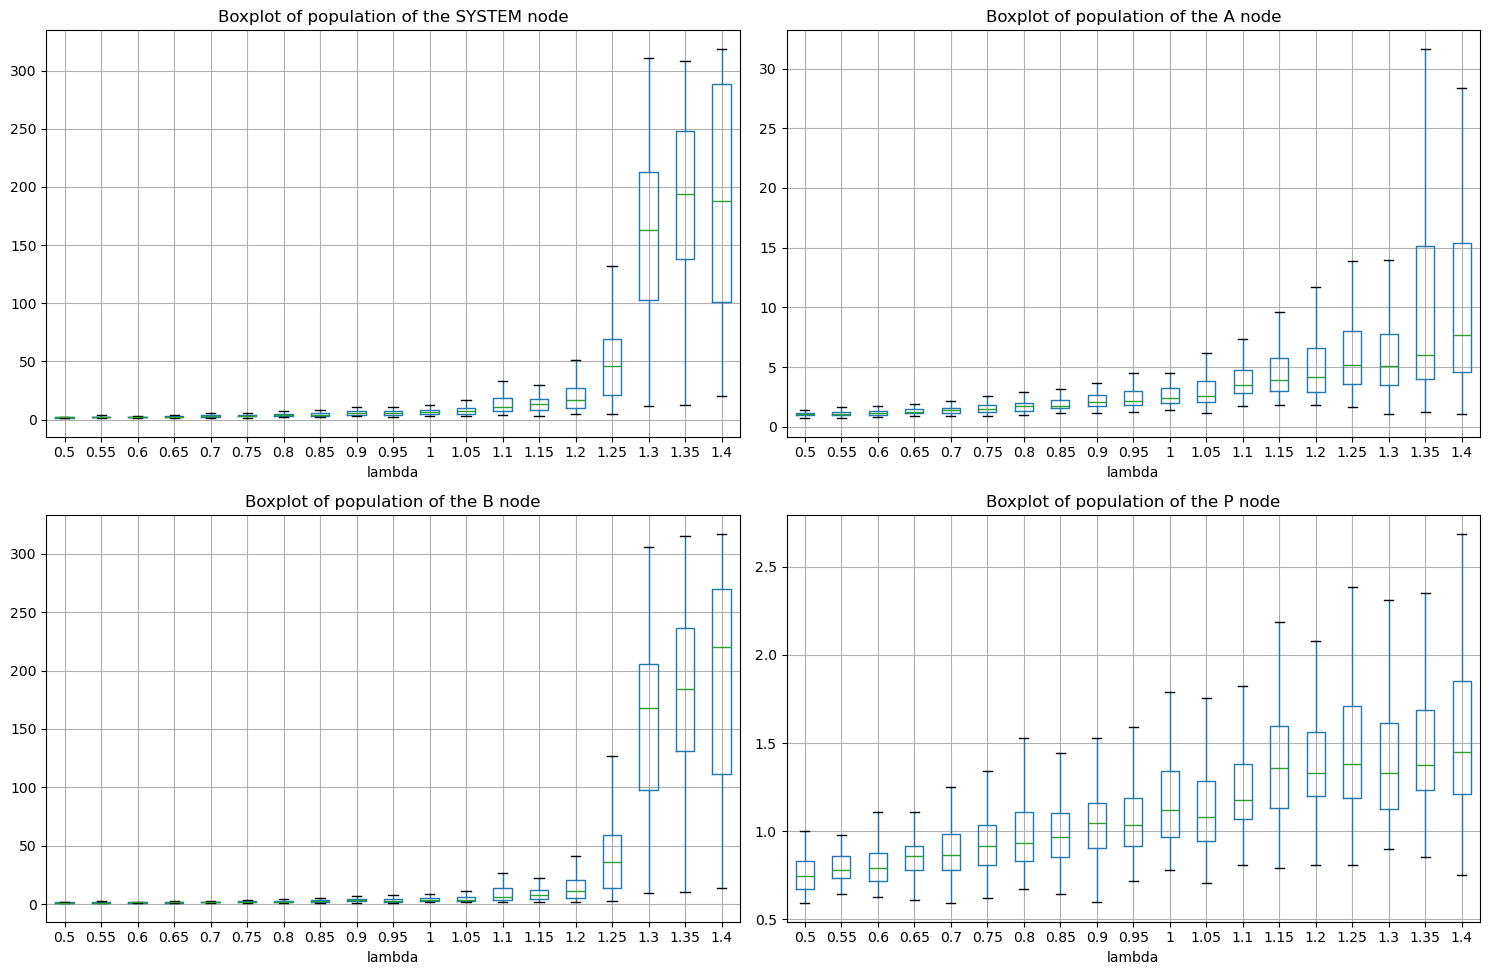

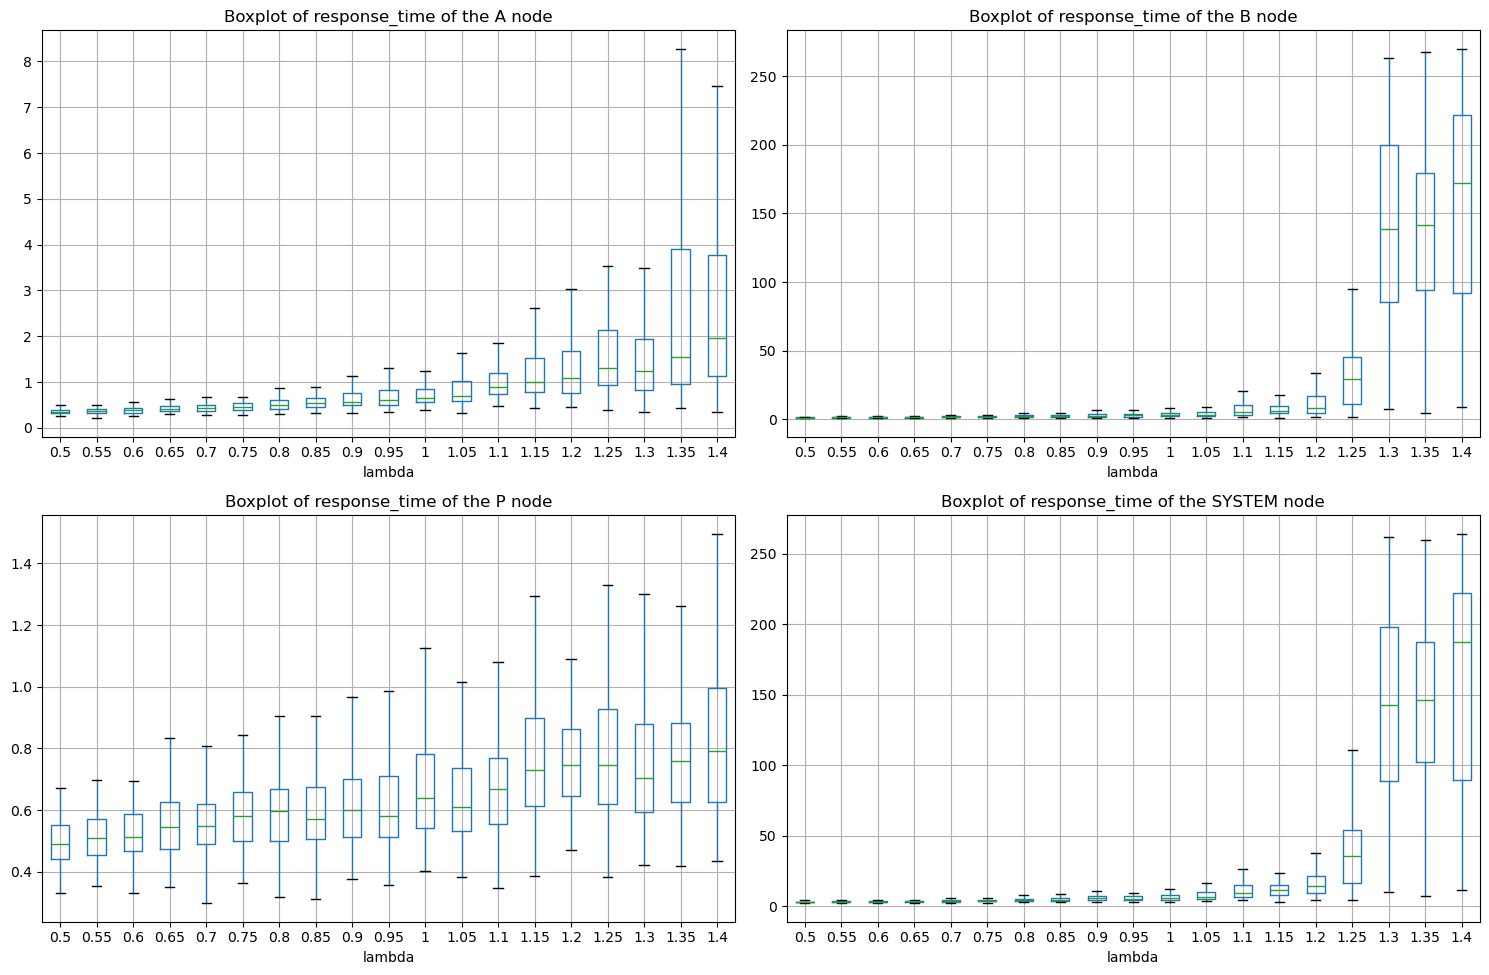

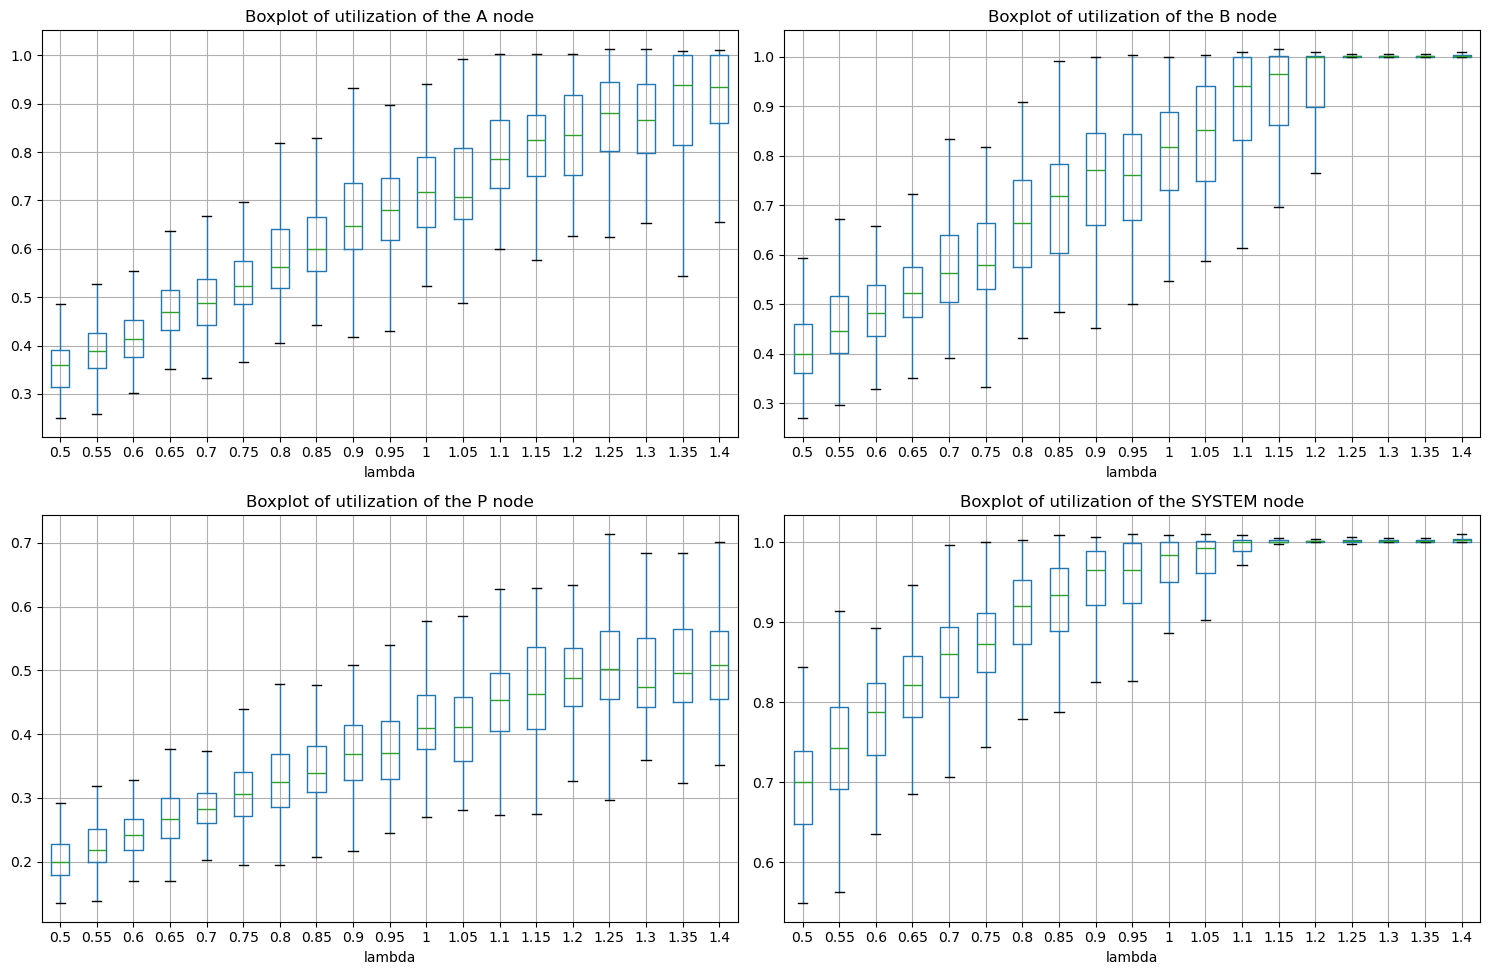

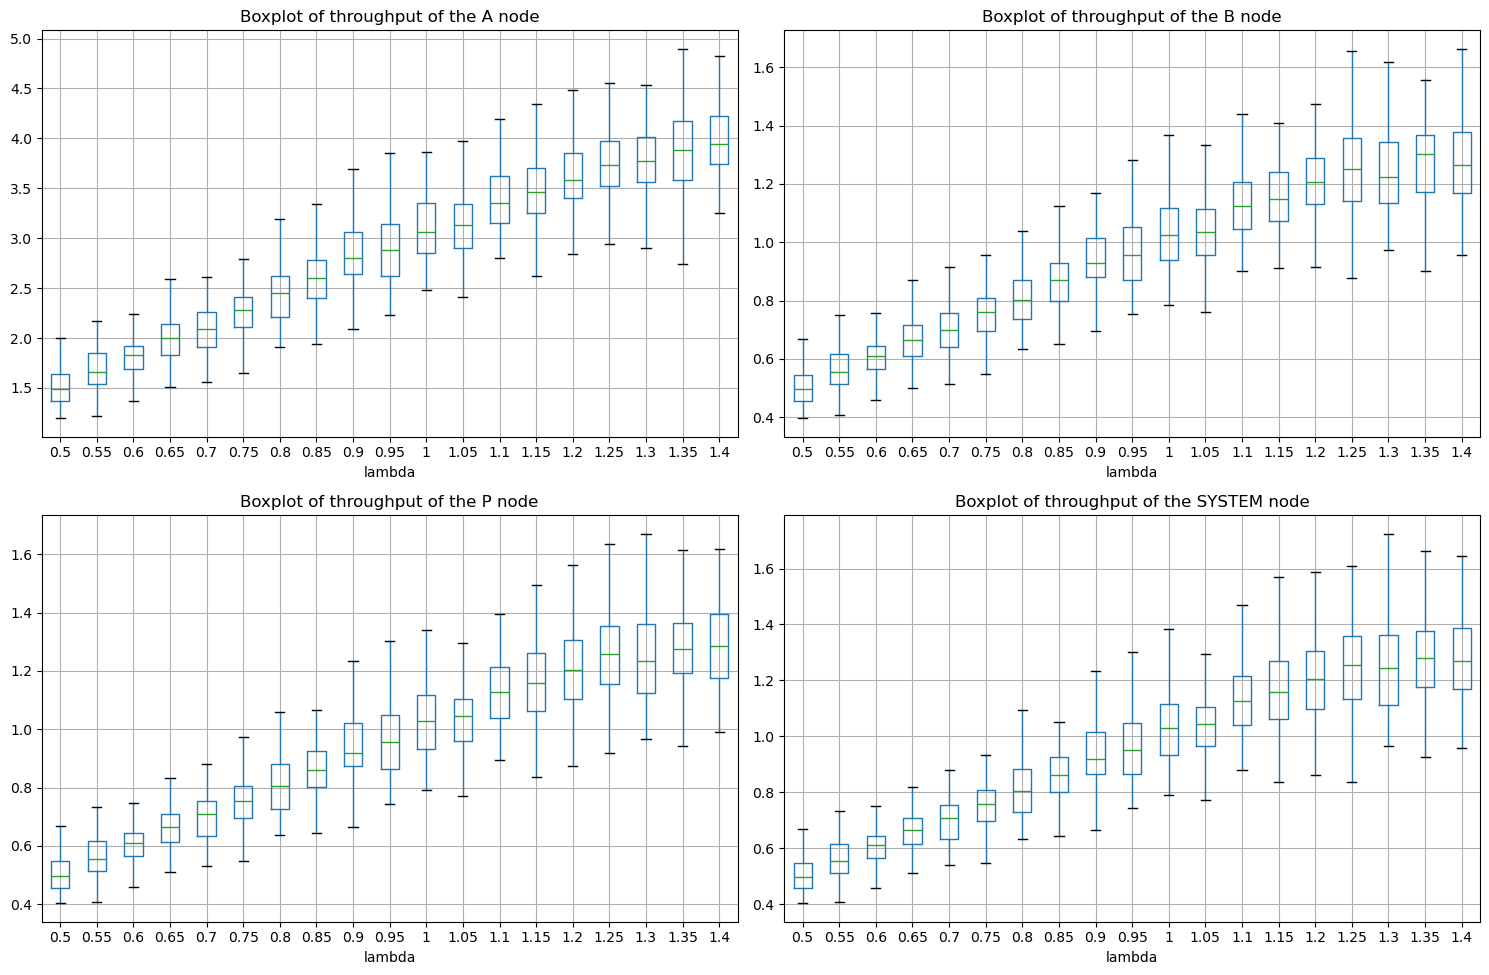

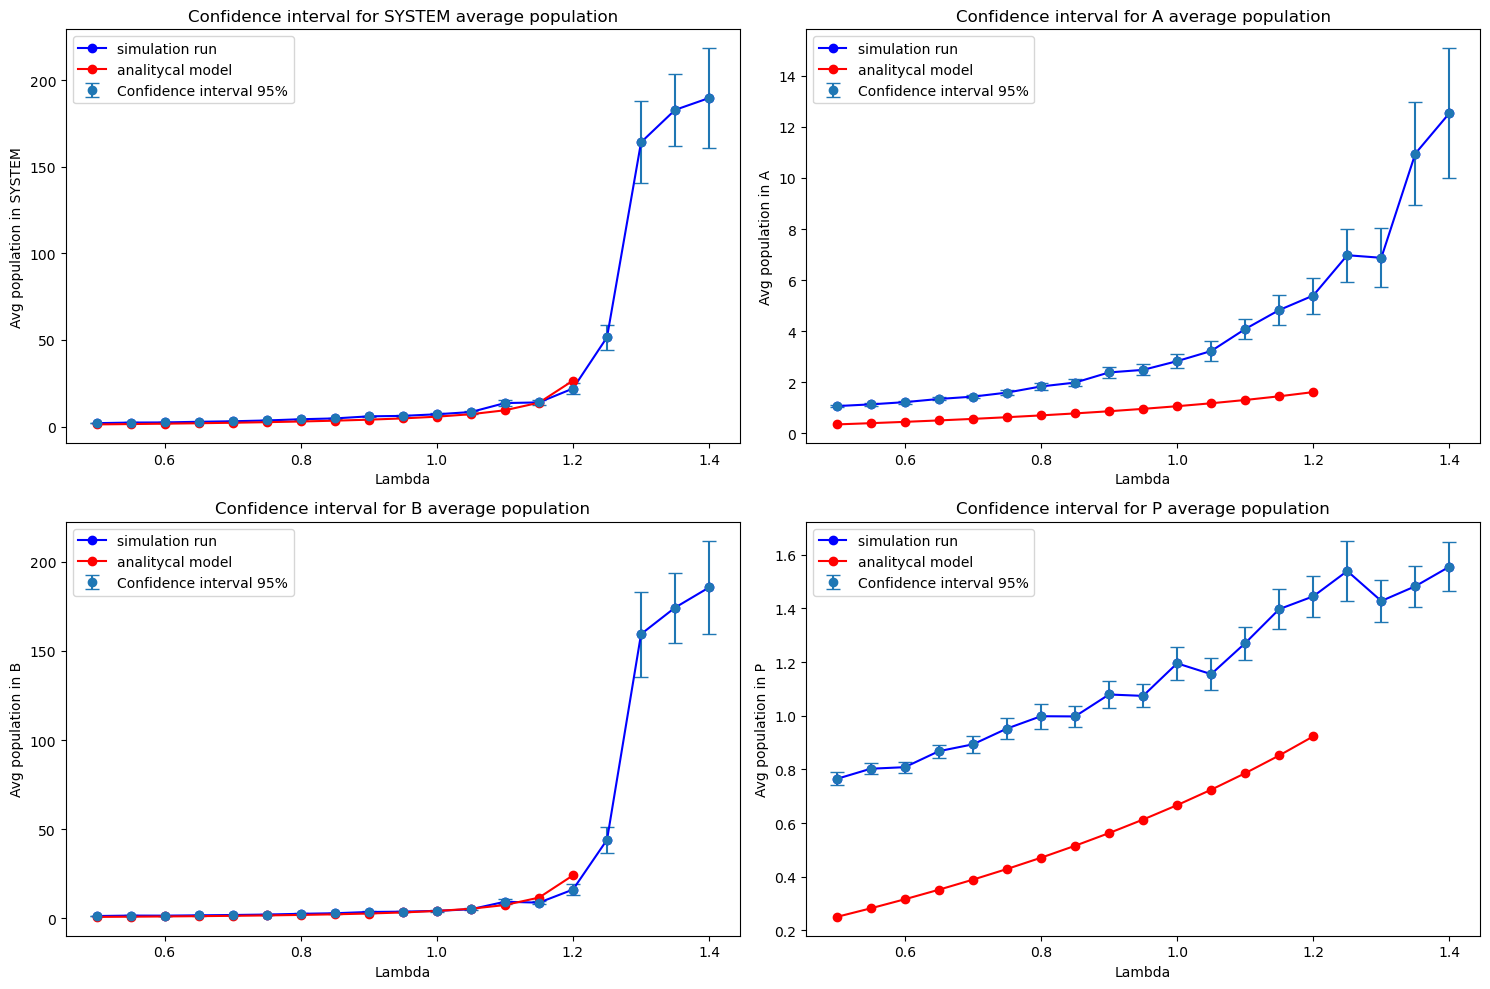

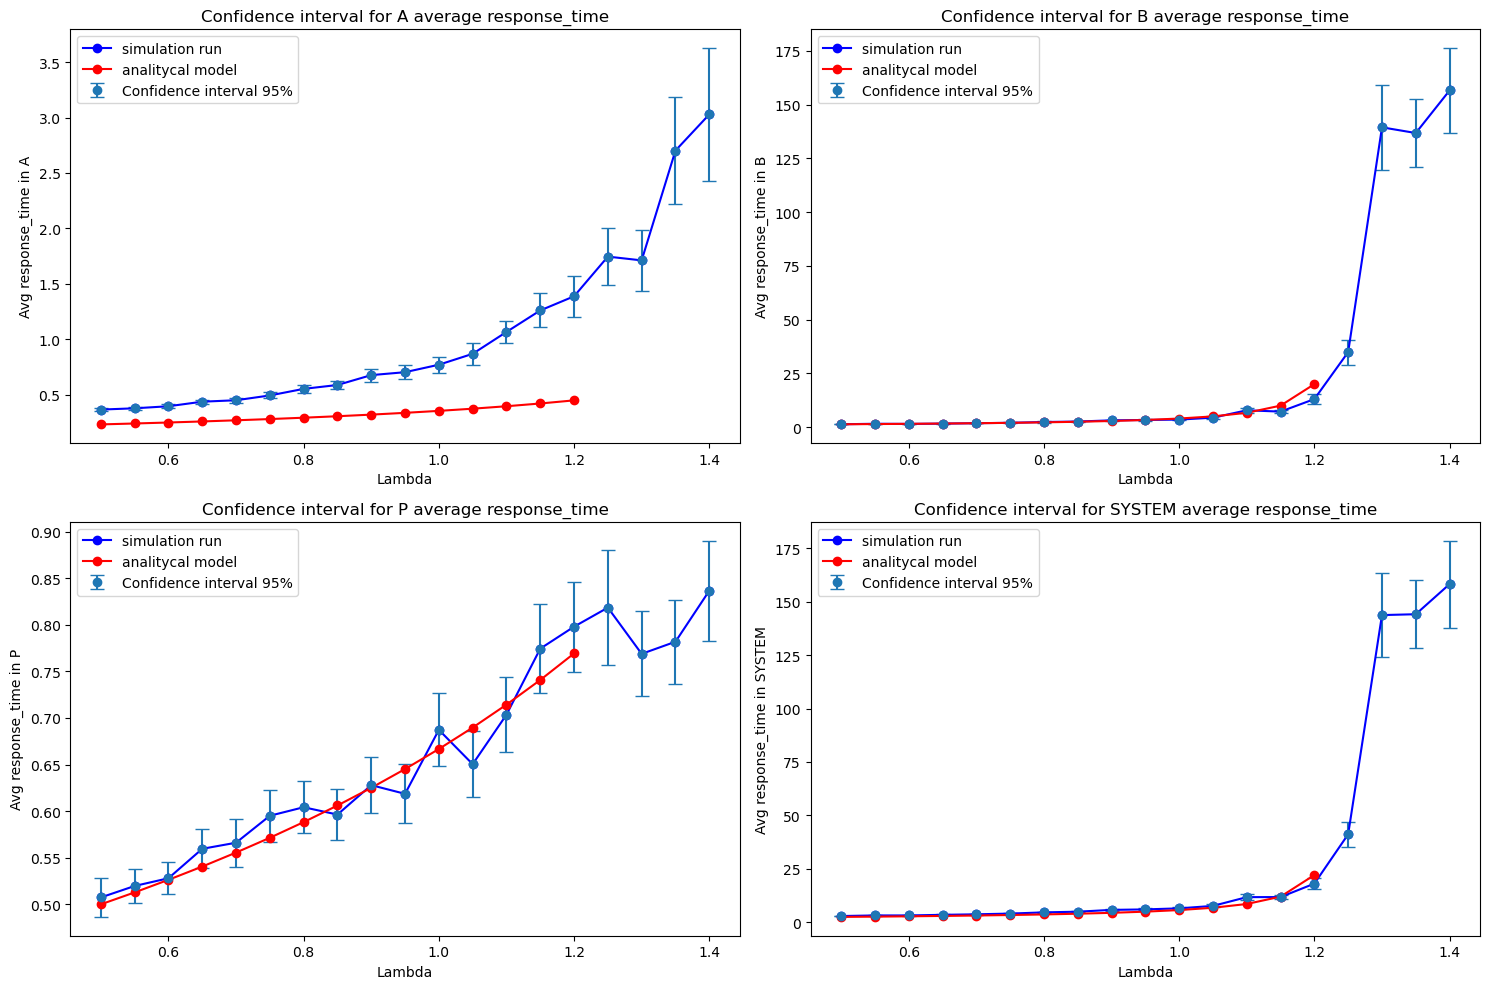

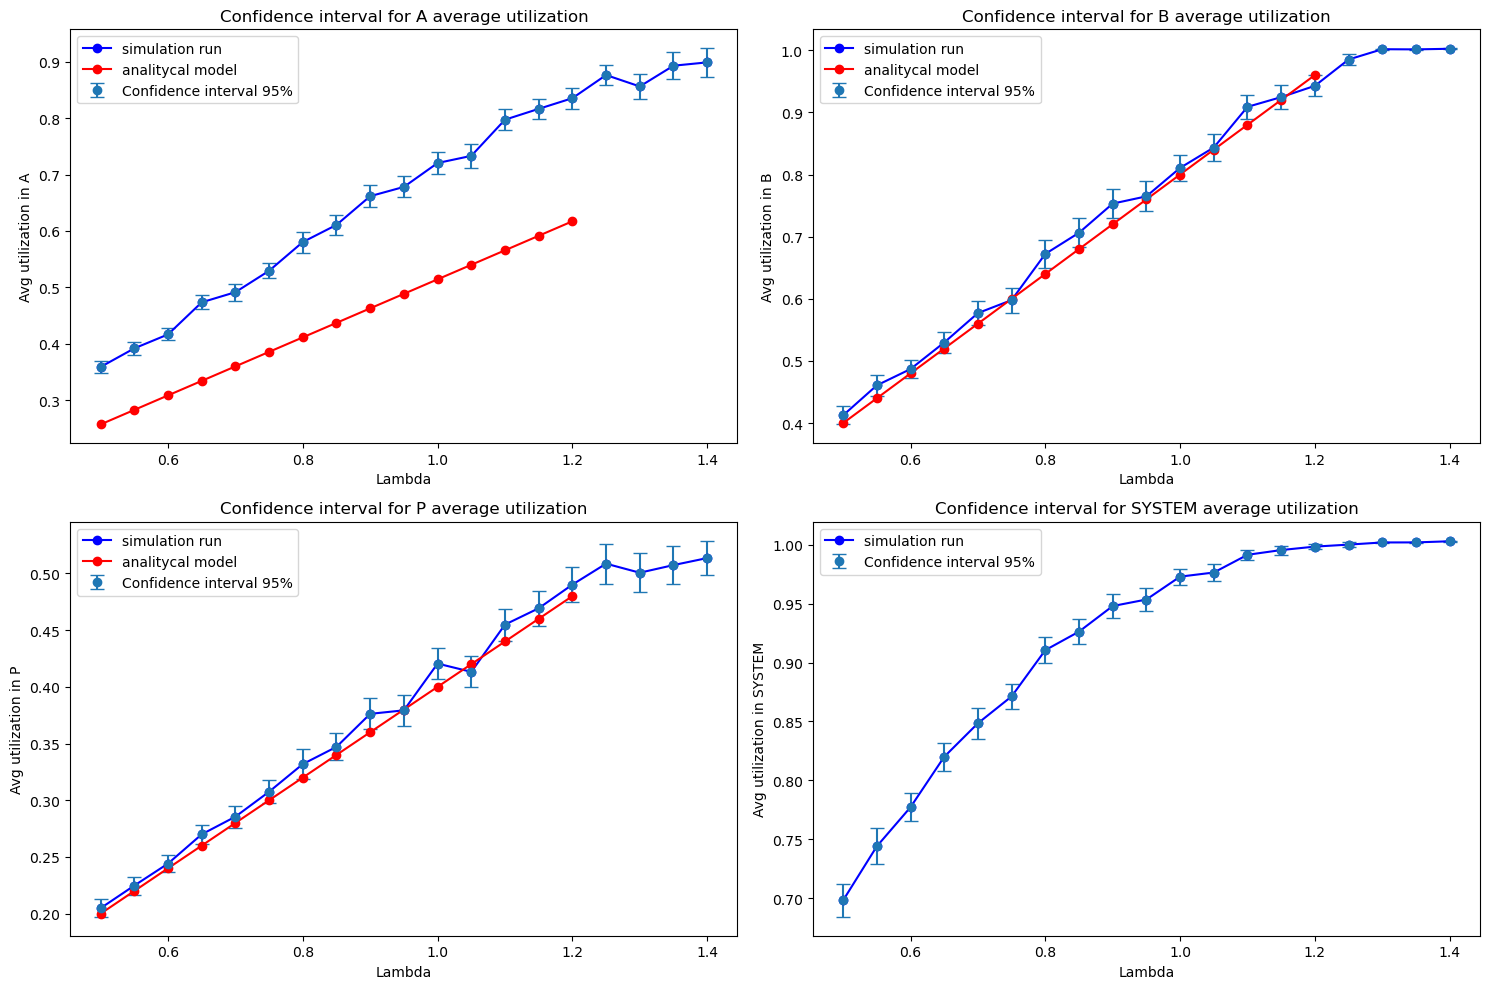

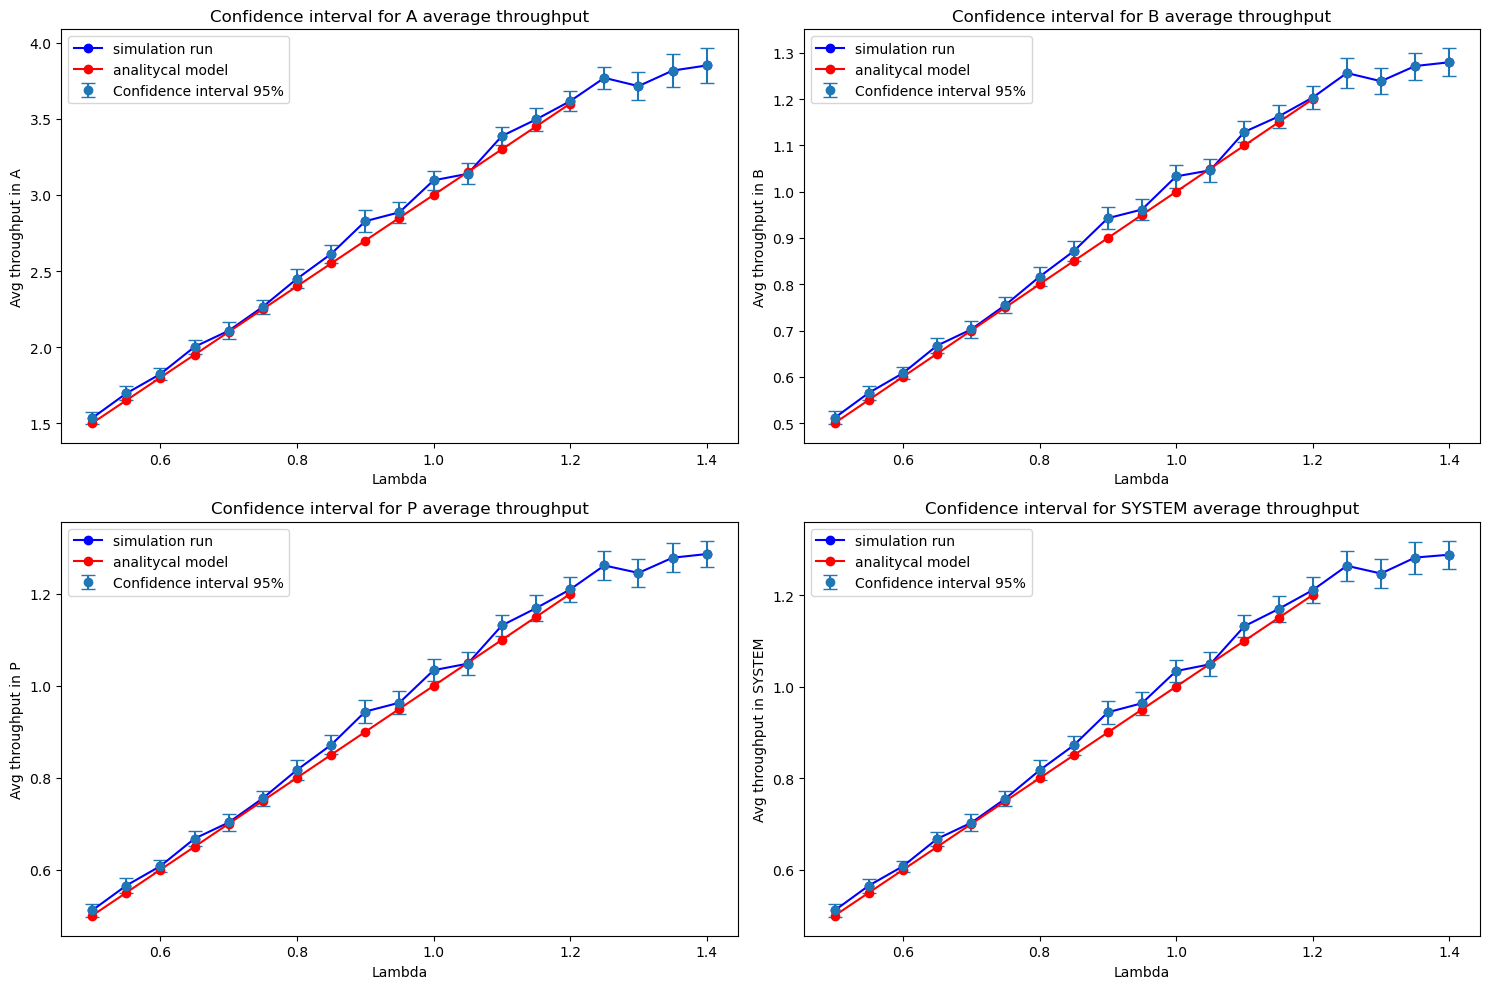

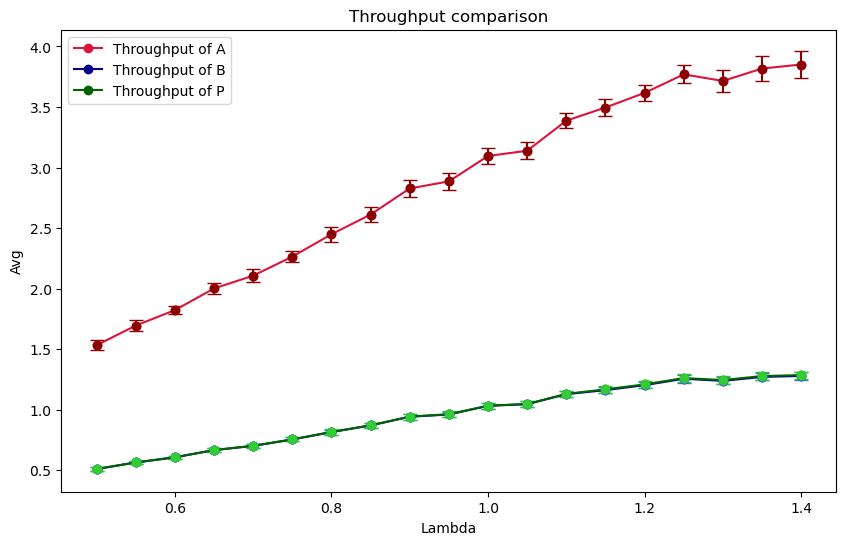

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           1.9805 </td><td style="text-align: right;">           1.26282</td><td style="text-align: right;">0.717677</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           2.31773</td><td style="text-align: right;">           1.46219</td><td style="text-align: right;">0.855538</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           2.40826</td><td style="text-align: right;">           1.68515</td><td style="text-align: right;">0.723117</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           2.77972</td><td style="text-align: right;">           1.93683</td><td style="text-align: right;">0.842893</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           3.07325</td><td style="text-align: right;">           2.22412</td><td style="text-align: right;">0.849136</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           3.53844</td><td style="text-align: right;">           2.55648</td><td style="text-align: right;">0.981959</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           4.24446</td><td style="text-align: right;">           2.9474 </td><td style="text-align: right;">1.29707 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           4.726  </td><td style="text-align: right;">           3.4168 </td><td style="text-align: right;">1.3092  </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           5.91915</td><td style="text-align: right;">           3.99563</td><td style="text-align: right;">1.92352 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           6.1836 </td><td style="text-align: right;">           4.73488</td><td style="text-align: right;">1.44872 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           7.12118</td><td style="text-align: right;">           5.72549</td><td style="text-align: right;">1.39569 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           8.40211</td><td style="text-align: right;">           7.14805</td><td style="text-align: right;">1.25406 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">          13.5845 </td><td style="text-align: right;">           9.42168</td><td style="text-align: right;">4.16281 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">          13.9679 </td><td style="text-align: right;">          13.7994 </td><td style="text-align: right;">0.168515</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">          21.9802 </td><td style="text-align: right;">          26.535  </td><td style="text-align: right;">4.55478 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.06368</td><td style="text-align: right;">          0.346154</td><td style="text-align: right;">0.71753 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>A     </td><td style="text-align: right;">           1.13137</td><td style="text-align: right;">          0.394422</td><td style="text-align: right;">0.736951</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.21819</td><td style="text-align: right;">          0.446281</td><td style="text-align: right;">0.77191 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>A     </td><td style="text-align: right;">           1.34292</td><td style="text-align: right;">          0.502146</td><td style="text-align: right;">0.840772</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.43394</td><td style="text-align: right;">          0.5625  </td><td style="text-align: right;">0.871444</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>A     </td><td style="text-align: right;">           1.59179</td><td style="text-align: right;">          0.627907</td><td style="text-align: right;">0.963885</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.83327</td><td style="text-align: right;">          0.699029</td><td style="text-align: right;">1.13424 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>A     </td><td style="text-align: right;">           1.98368</td><td style="text-align: right;">          0.77665 </td><td style="text-align: right;">1.20703 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>A     </td><td style="text-align: right;">           2.38272</td><td style="text-align: right;">          0.861702</td><td style="text-align: right;">1.52102 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>A     </td><td style="text-align: right;">           2.48201</td><td style="text-align: right;">          0.955307</td><td style="text-align: right;">1.5267  </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>A     </td><td style="text-align: right;">           2.82417</td><td style="text-align: right;">          1.05882 </td><td style="text-align: right;">1.76534 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>A     </td><td style="text-align: right;">           3.22025</td><td style="text-align: right;">          1.17391 </td><td style="text-align: right;">2.04634 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>A     </td><td style="text-align: right;">           4.08216</td><td style="text-align: right;">          1.30263 </td><td style="text-align: right;">2.77953 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>A     </td><td style="text-align: right;">           4.82565</td><td style="text-align: right;">          1.44755 </td><td style="text-align: right;">3.3781  </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>A     </td><td style="text-align: right;">           5.39415</td><td style="text-align: right;">          1.61194 </td><td style="text-align: right;">3.78221 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">     diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>B     </td><td style="text-align: right;">           1.15856</td><td style="text-align: right;">          0.666667</td><td style="text-align: right;">0.491894 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>B     </td><td style="text-align: right;">           1.41076</td><td style="text-align: right;">          0.785714</td><td style="text-align: right;">0.625049 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>B     </td><td style="text-align: right;">           1.37789</td><td style="text-align: right;">          0.923077</td><td style="text-align: right;">0.454815 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>B     </td><td style="text-align: right;">           1.55499</td><td style="text-align: right;">          1.08333 </td><td style="text-align: right;">0.471655 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>B     </td><td style="text-align: right;">           1.74261</td><td style="text-align: right;">          1.27273 </td><td style="text-align: right;">0.469886 </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>B     </td><td style="text-align: right;">           1.99384</td><td style="text-align: right;">          1.5     </td><td style="text-align: right;">0.493845 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>B     </td><td style="text-align: right;">           2.41389</td><td style="text-align: right;">          1.77778 </td><td style="text-align: right;">0.63611  </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>B     </td><td style="text-align: right;">           2.72459</td><td style="text-align: right;">          2.125   </td><td style="text-align: right;">0.599591 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>B     </td><td style="text-align: right;">           3.43469</td><td style="text-align: right;">          2.57143 </td><td style="text-align: right;">0.863257 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>B     </td><td style="text-align: right;">           3.61912</td><td style="text-align: right;">          3.16667 </td><td style="text-align: right;">0.452455 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>B     </td><td style="text-align: right;">           4.05647</td><td style="text-align: right;">          4       </td><td style="text-align: right;">0.0564689</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>B     </td><td style="text-align: right;">           4.96302</td><td style="text-align: right;">          5.25    </td><td style="text-align: right;">0.286982 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>B     </td><td style="text-align: right;">           9.19007</td><td style="text-align: right;">          7.33333 </td><td style="text-align: right;">1.85674  </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>B     </td><td style="text-align: right;">           8.67128</td><td style="text-align: right;">         11.5     </td><td style="text-align: right;">2.82872  </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>B     </td><td style="text-align: right;">          16.0254 </td><td style="text-align: right;">         24       </td><td style="text-align: right;">7.97458  </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>P     </td><td style="text-align: right;">          0.764557</td><td style="text-align: right;">          0.25    </td><td style="text-align: right;">0.514557</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>P     </td><td style="text-align: right;">          0.80248 </td><td style="text-align: right;">          0.282051</td><td style="text-align: right;">0.520429</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>P     </td><td style="text-align: right;">          0.808197</td><td style="text-align: right;">          0.315789</td><td style="text-align: right;">0.492407</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>P     </td><td style="text-align: right;">          0.867913</td><td style="text-align: right;">          0.351351</td><td style="text-align: right;">0.516562</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>P     </td><td style="text-align: right;">          0.893326</td><td style="text-align: right;">          0.388889</td><td style="text-align: right;">0.504437</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>P     </td><td style="text-align: right;">          0.952145</td><td style="text-align: right;">          0.428571</td><td style="text-align: right;">0.523573</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>P     </td><td style="text-align: right;">          0.998159</td><td style="text-align: right;">          0.470588</td><td style="text-align: right;">0.527571</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>P     </td><td style="text-align: right;">          0.997416</td><td style="text-align: right;">          0.515152</td><td style="text-align: right;">0.482265</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>P     </td><td style="text-align: right;">          1.07916 </td><td style="text-align: right;">          0.5625  </td><td style="text-align: right;">0.516661</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>P     </td><td style="text-align: right;">          1.074   </td><td style="text-align: right;">          0.612903</td><td style="text-align: right;">0.4611  </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>P     </td><td style="text-align: right;">          1.19535 </td><td style="text-align: right;">          0.666667</td><td style="text-align: right;">0.528679</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>P     </td><td style="text-align: right;">          1.15504 </td><td style="text-align: right;">          0.724138</td><td style="text-align: right;">0.430904</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>P     </td><td style="text-align: right;">          1.27058 </td><td style="text-align: right;">          0.785714</td><td style="text-align: right;">0.48487 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>P     </td><td style="text-align: right;">          1.39739 </td><td style="text-align: right;">          0.851852</td><td style="text-align: right;">0.54554 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>P     </td><td style="text-align: right;">          1.44504 </td><td style="text-align: right;">          0.923077</td><td style="text-align: right;">0.521959</td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.364618</td><td style="text-align: right;">          0.230769</td><td style="text-align: right;">0.133849</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.376151</td><td style="text-align: right;">          0.239044</td><td style="text-align: right;">0.137107</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.394677</td><td style="text-align: right;">          0.247934</td><td style="text-align: right;">0.146743</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.435764</td><td style="text-align: right;">          0.257511</td><td style="text-align: right;">0.178254</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.448895</td><td style="text-align: right;">          0.267857</td><td style="text-align: right;">0.181038</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.492145</td><td style="text-align: right;">          0.27907 </td><td style="text-align: right;">0.213075</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.551505</td><td style="text-align: right;">          0.291262</td><td style="text-align: right;">0.260243</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.586483</td><td style="text-align: right;">          0.304569</td><td style="text-align: right;">0.281915</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.67565 </td><td style="text-align: right;">          0.319149</td><td style="text-align: right;">0.356501</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.702071</td><td style="text-align: right;">          0.335196</td><td style="text-align: right;">0.366875</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.769424</td><td style="text-align: right;">          0.352941</td><td style="text-align: right;">0.416482</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.867787</td><td style="text-align: right;">          0.372671</td><td style="text-align: right;">0.495116</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          1.06515 </td><td style="text-align: right;">          0.394737</td><td style="text-align: right;">0.670408</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>A     </td><td style="text-align: right;">          1.25941 </td><td style="text-align: right;">          0.41958 </td><td style="text-align: right;">0.839827</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          1.38706 </td><td style="text-align: right;">          0.447761</td><td style="text-align: right;">0.939303</td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.3311 </td><td style="text-align: right;">           1.33333</td><td style="text-align: right;">0.00223121</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.57148</td><td style="text-align: right;">           1.42857</td><td style="text-align: right;">0.14291   </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.50334</td><td style="text-align: right;">           1.53846</td><td style="text-align: right;">0.035125  </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.64042</td><td style="text-align: right;">           1.66667</td><td style="text-align: right;">0.0262452 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           1.82894</td><td style="text-align: right;">           1.81818</td><td style="text-align: right;">0.0107541 </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>B     </td><td style="text-align: right;">           2.00955</td><td style="text-align: right;">           2      </td><td style="text-align: right;">0.00954795</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           2.38373</td><td style="text-align: right;">           2.22222</td><td style="text-align: right;">0.161506  </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>B     </td><td style="text-align: right;">           2.60486</td><td style="text-align: right;">           2.5    </td><td style="text-align: right;">0.104856  </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           3.15976</td><td style="text-align: right;">           2.85714</td><td style="text-align: right;">0.302618  </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>B     </td><td style="text-align: right;">           3.3256 </td><td style="text-align: right;">           3.33333</td><td style="text-align: right;">0.00773307</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>B     </td><td style="text-align: right;">           3.50562</td><td style="text-align: right;">           4      </td><td style="text-align: right;">0.494384  </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>B     </td><td style="text-align: right;">           4.39666</td><td style="text-align: right;">           5      </td><td style="text-align: right;">0.603337  </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>B     </td><td style="text-align: right;">           7.83472</td><td style="text-align: right;">           6.66667</td><td style="text-align: right;">1.16806   </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>B     </td><td style="text-align: right;">           7.2252 </td><td style="text-align: right;">          10      </td><td style="text-align: right;">2.7748    </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>B     </td><td style="text-align: right;">          13.0435 </td><td style="text-align: right;">          20      </td><td style="text-align: right;">6.95655   </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.507405</td><td style="text-align: right;">          0.5     </td><td style="text-align: right;">0.00740481</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.519706</td><td style="text-align: right;">          0.512821</td><td style="text-align: right;">0.00688584</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.528001</td><td style="text-align: right;">          0.526316</td><td style="text-align: right;">0.00168521</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.559584</td><td style="text-align: right;">          0.540541</td><td style="text-align: right;">0.0190439 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.566126</td><td style="text-align: right;">          0.555556</td><td style="text-align: right;">0.0105708 </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.595057</td><td style="text-align: right;">          0.571429</td><td style="text-align: right;">0.0236283 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.604196</td><td style="text-align: right;">          0.588235</td><td style="text-align: right;">0.015961  </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.596326</td><td style="text-align: right;">          0.606061</td><td style="text-align: right;">0.00973471</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.627898</td><td style="text-align: right;">          0.625   </td><td style="text-align: right;">0.0028985 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.618578</td><td style="text-align: right;">          0.645161</td><td style="text-align: right;">0.0265837 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.687235</td><td style="text-align: right;">          0.666667</td><td style="text-align: right;">0.0205682 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.650401</td><td style="text-align: right;">          0.689655</td><td style="text-align: right;">0.0392542 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.703461</td><td style="text-align: right;">          0.714286</td><td style="text-align: right;">0.0108246 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.774389</td><td style="text-align: right;">          0.740741</td><td style="text-align: right;">0.0336481 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.797938</td><td style="text-align: right;">          0.769231</td><td style="text-align: right;">0.0287071 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           2.93211</td><td style="text-align: right;">           2.52564</td><td style="text-align: right;">0.406472</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           3.21857</td><td style="text-align: right;">           2.65852</td><td style="text-align: right;">0.560045</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           3.21445</td><td style="text-align: right;">           2.80858</td><td style="text-align: right;">0.405868</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           3.50405</td><td style="text-align: right;">           2.97974</td><td style="text-align: right;">0.524308</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           3.74248</td><td style="text-align: right;">           3.17731</td><td style="text-align: right;">0.565173</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           4.0809 </td><td style="text-align: right;">           3.40864</td><td style="text-align: right;">0.672265</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           4.64755</td><td style="text-align: right;">           3.68424</td><td style="text-align: right;">0.963302</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           4.96291</td><td style="text-align: right;">           4.01977</td><td style="text-align: right;">0.943145</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           5.80966</td><td style="text-align: right;">           4.43959</td><td style="text-align: right;">1.37007 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           6.03935</td><td style="text-align: right;">           4.98408</td><td style="text-align: right;">1.05526 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           6.52795</td><td style="text-align: right;">           5.72549</td><td style="text-align: right;">0.802464</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           7.67487</td><td style="text-align: right;">           6.80767</td><td style="text-align: right;">0.867203</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">          11.7708 </td><td style="text-align: right;">           8.56516</td><td style="text-align: right;">3.20566 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">          11.8087 </td><td style="text-align: right;">          11.9995 </td><td style="text-align: right;">0.190751</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">          18.1002 </td><td style="text-align: right;">          22.1125 </td><td style="text-align: right;">4.01234 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric     </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.358963</td><td style="text-align: right;">          0.257143</td><td style="text-align: right;">0.10182 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.391922</td><td style="text-align: right;">          0.282857</td><td style="text-align: right;">0.109064</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.416632</td><td style="text-align: right;">          0.308571</td><td style="text-align: right;">0.108061</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.473522</td><td style="text-align: right;">          0.334286</td><td style="text-align: right;">0.139236</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.491503</td><td style="text-align: right;">          0.36    </td><td style="text-align: right;">0.131503</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.529412</td><td style="text-align: right;">          0.385714</td><td style="text-align: right;">0.143698</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.580353</td><td style="text-align: right;">          0.411429</td><td style="text-align: right;">0.168925</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.610748</td><td style="text-align: right;">          0.437143</td><td style="text-align: right;">0.173605</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.661643</td><td style="text-align: right;">          0.462857</td><td style="text-align: right;">0.198786</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.678057</td><td style="text-align: right;">          0.488571</td><td style="text-align: right;">0.189485</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.720405</td><td style="text-align: right;">          0.514286</td><td style="text-align: right;">0.20612 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.733074</td><td style="text-align: right;">          0.54    </td><td style="text-align: right;">0.193074</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.797197</td><td style="text-align: right;">          0.565714</td><td style="text-align: right;">0.231483</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.816379</td><td style="text-align: right;">          0.591429</td><td style="text-align: right;">0.22495 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.835283</td><td style="text-align: right;">          0.617143</td><td style="text-align: right;">0.218141</td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric     </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.412583</td><td style="text-align: right;">              0.4 </td><td style="text-align: right;">0.0125835 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.460778</td><td style="text-align: right;">              0.44</td><td style="text-align: right;">0.0207783 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.48701 </td><td style="text-align: right;">              0.48</td><td style="text-align: right;">0.00701016</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.52973 </td><td style="text-align: right;">              0.52</td><td style="text-align: right;">0.00973028</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.577071</td><td style="text-align: right;">              0.56</td><td style="text-align: right;">0.017071  </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.59797 </td><td style="text-align: right;">              0.6 </td><td style="text-align: right;">0.0020301 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.672244</td><td style="text-align: right;">              0.64</td><td style="text-align: right;">0.0322443 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.706282</td><td style="text-align: right;">              0.68</td><td style="text-align: right;">0.0262816 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.753188</td><td style="text-align: right;">              0.72</td><td style="text-align: right;">0.0331883 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.76489 </td><td style="text-align: right;">              0.76</td><td style="text-align: right;">0.00489017</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.810628</td><td style="text-align: right;">              0.8 </td><td style="text-align: right;">0.0106282 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.843462</td><td style="text-align: right;">              0.84</td><td style="text-align: right;">0.00346196</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.908853</td><td style="text-align: right;">              0.88</td><td style="text-align: right;">0.0288527 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.92453 </td><td style="text-align: right;">              0.92</td><td style="text-align: right;">0.0045298 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.942672</td><td style="text-align: right;">              0.96</td><td style="text-align: right;">0.0173279 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric     </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">       diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.204844</td><td style="text-align: right;">              0.2 </td><td style="text-align: right;">0.00484362 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.224775</td><td style="text-align: right;">              0.22</td><td style="text-align: right;">0.00477452 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.244161</td><td style="text-align: right;">              0.24</td><td style="text-align: right;">0.00416069 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.269957</td><td style="text-align: right;">              0.26</td><td style="text-align: right;">0.00995692 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.285521</td><td style="text-align: right;">              0.28</td><td style="text-align: right;">0.00552057 </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.307527</td><td style="text-align: right;">              0.3 </td><td style="text-align: right;">0.00752671 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.331893</td><td style="text-align: right;">              0.32</td><td style="text-align: right;">0.0118925  </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.347084</td><td style="text-align: right;">              0.34</td><td style="text-align: right;">0.00708422 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.376199</td><td style="text-align: right;">              0.36</td><td style="text-align: right;">0.0161994  </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.379294</td><td style="text-align: right;">              0.38</td><td style="text-align: right;">0.000705687</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.42051 </td><td style="text-align: right;">              0.4 </td><td style="text-align: right;">0.0205098  </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.413229</td><td style="text-align: right;">              0.42</td><td style="text-align: right;">0.00677143 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.454888</td><td style="text-align: right;">              0.44</td><td style="text-align: right;">0.0148876  </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.469279</td><td style="text-align: right;">              0.46</td><td style="text-align: right;">0.00927904 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.490145</td><td style="text-align: right;">              0.48</td><td style="text-align: right;">0.0101455  </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           1.53343</td><td style="text-align: right;">              1.5 </td><td style="text-align: right;">0.0334319 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>A     </td><td style="text-align: right;">           1.69568</td><td style="text-align: right;">              1.65</td><td style="text-align: right;">0.0456757 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           1.82323</td><td style="text-align: right;">              1.8 </td><td style="text-align: right;">0.0232333 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.00187</td><td style="text-align: right;">              1.95</td><td style="text-align: right;">0.051866  </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.10767</td><td style="text-align: right;">              2.1 </td><td style="text-align: right;">0.00766665</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.26488</td><td style="text-align: right;">              2.25</td><td style="text-align: right;">0.0148835 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.44923</td><td style="text-align: right;">              2.4 </td><td style="text-align: right;">0.0492298 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.61255</td><td style="text-align: right;">              2.55</td><td style="text-align: right;">0.0625452 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.82747</td><td style="text-align: right;">              2.7 </td><td style="text-align: right;">0.127474  </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.88605</td><td style="text-align: right;">              2.85</td><td style="text-align: right;">0.0360503 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.09593</td><td style="text-align: right;">              3   </td><td style="text-align: right;">0.0959306 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.13901</td><td style="text-align: right;">              3.15</td><td style="text-align: right;">0.0109947 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.38724</td><td style="text-align: right;">              3.3 </td><td style="text-align: right;">0.0872392 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.49594</td><td style="text-align: right;">              3.45</td><td style="text-align: right;">0.0459424 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.6166 </td><td style="text-align: right;">              3.6 </td><td style="text-align: right;">0.0165993 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.511298</td><td style="text-align: right;">              0.5 </td><td style="text-align: right;">0.0112981 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.565282</td><td style="text-align: right;">              0.55</td><td style="text-align: right;">0.0152821 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.607889</td><td style="text-align: right;">              0.6 </td><td style="text-align: right;">0.00788894</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.66743 </td><td style="text-align: right;">              0.65</td><td style="text-align: right;">0.0174304 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.702448</td><td style="text-align: right;">              0.7 </td><td style="text-align: right;">0.00244803</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.755231</td><td style="text-align: right;">              0.75</td><td style="text-align: right;">0.00523108</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.816301</td><td style="text-align: right;">              0.8 </td><td style="text-align: right;">0.0163006 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.8715  </td><td style="text-align: right;">              0.85</td><td style="text-align: right;">0.0215003 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.942774</td><td style="text-align: right;">              0.9 </td><td style="text-align: right;">0.0427742 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.961526</td><td style="text-align: right;">              0.95</td><td style="text-align: right;">0.0115258 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.03316 </td><td style="text-align: right;">              1   </td><td style="text-align: right;">0.0331558 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.04631 </td><td style="text-align: right;">              1.05</td><td style="text-align: right;">0.00369079</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.1293  </td><td style="text-align: right;">              1.1 </td><td style="text-align: right;">0.0292983 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.16258 </td><td style="text-align: right;">              1.15</td><td style="text-align: right;">0.0125801 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.20355 </td><td style="text-align: right;">              1.2 </td><td style="text-align: right;">0.00355033</td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.511386</td><td style="text-align: right;">              0.5 </td><td style="text-align: right;">0.0113863 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.565499</td><td style="text-align: right;">              0.55</td><td style="text-align: right;">0.0154987 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.607893</td><td style="text-align: right;">              0.6 </td><td style="text-align: right;">0.00789275</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.667628</td><td style="text-align: right;">              0.65</td><td style="text-align: right;">0.0176285 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.70271 </td><td style="text-align: right;">              0.7 </td><td style="text-align: right;">0.00271042</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.755421</td><td style="text-align: right;">              0.75</td><td style="text-align: right;">0.00542105</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.817067</td><td style="text-align: right;">              0.8 </td><td style="text-align: right;">0.0170669 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.871604</td><td style="text-align: right;">              0.85</td><td style="text-align: right;">0.0216037 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.94403 </td><td style="text-align: right;">              0.9 </td><td style="text-align: right;">0.04403   </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.963381</td><td style="text-align: right;">              0.95</td><td style="text-align: right;">0.0133806 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.03402 </td><td style="text-align: right;">              1   </td><td style="text-align: right;">0.0340152 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.04828 </td><td style="text-align: right;">              1.05</td><td style="text-align: right;">0.00171959</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.13144 </td><td style="text-align: right;">              1.1 </td><td style="text-align: right;">0.0314431 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.16894 </td><td style="text-align: right;">              1.15</td><td style="text-align: right;">0.0189438 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.20979 </td><td style="text-align: right;">              1.2 </td><td style="text-align: right;">0.0097891 </td></tr>\n</tbody>\n</table>'

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.511268</td><td style="text-align: right;">              0.5 </td><td style="text-align: right;">0.0112681 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.565443</td><td style="text-align: right;">              0.55</td><td style="text-align: right;">0.015443  </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.607835</td><td style="text-align: right;">              0.6 </td><td style="text-align: right;">0.00783494</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.667499</td><td style="text-align: right;">              0.65</td><td style="text-align: right;">0.0174993 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.70265 </td><td style="text-align: right;">              0.7 </td><td style="text-align: right;">0.00264994</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.755436</td><td style="text-align: right;">              0.75</td><td style="text-align: right;">0.005436  </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.817203</td><td style="text-align: right;">              0.8 </td><td style="text-align: right;">0.0172032 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.871719</td><td style="text-align: right;">              0.85</td><td style="text-align: right;">0.0217186 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.943953</td><td style="text-align: right;">              0.9 </td><td style="text-align: right;">0.0439531 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.96367 </td><td style="text-align: right;">              0.95</td><td style="text-align: right;">0.0136699 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.03402 </td><td style="text-align: right;">              1   </td><td style="text-align: right;">0.0340177 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.04884 </td><td style="text-align: right;">              1.05</td><td style="text-align: right;">0.00115732</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.13185 </td><td style="text-align: right;">              1.1 </td><td style="text-align: right;">0.0318475 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.16945 </td><td style="text-align: right;">              1.15</td><td style="text-align: right;">0.0194518 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.21064 </td><td style="text-align: right;">              1.2 </td><td style="text-align: right;">0.0106361 </td></tr>\n</tbody>\n</table>'

In [44]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_3", 'BatchMeansSimulation')
critical_value = scipy.stats.norm.ppf(1-.05/2)
obj = 'obj3'

metrics_nodes_avg_df_list = preprocessing(path, obj)
analitycal_perf = analitycal_preprocessing(obj)

boxplot(metrics_nodes_avg_df_list)

ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, obj)
plot_confidence_interval(ci_df, analitycal_perf)

avg_metrics_list = average_stats(metrics_nodes_avg_df_list, analitycal_perf)
for metric in avg_metrics_list:
    for node in metric:
        df = node.reset_index()
        df.drop(columns=['index'], inplace=True)
        display(tabulate(df, headers='keys', tablefmt='html', showindex=False))

## Objective 4

In [45]:
def plot_average_service_confidence_interval(average_services, plot_metric):
    colors = {
        0.8: ['orangered', 'firebrick'],
        0.75: ['tomato', 'brown'],
        0.7: ['crimson', 'darkred'],
        0.65: ['mediumvioletred', 'maroon'],
        0.6: ['royalblue', 'darkblue'],
        0.55: ['dodgerblue', 'midnightblue'],
        0.5: ['limegreen', 'darkgreen'],
        0.45: ['mediumseagreen', 'seagreen'],
        0.4: ['blueviolet', 'indigo']
    }
    plt.figure(figsize=(15, 10))
    for average_service in average_services:
        for metric in average_services[average_service]['ci']:
            if metric[0]['metric'].unique()[0] not in [plot_metric]:
                continue
            for df in metric:
                if df['node'].unique()[0] != 'B':
                    continue
                # if(plot_metric == 'utilization'):
                #     analitycal_df = average_service[average_service]['analitycal'][plot_metric]['B']
                #     plt.plot(analitycal_df['lambda'], analitycal_df['value'], linestyle='-', color=colors[average_service][1], marker='o', label='analitycal: avg service for B = ' + str(average_service))
                # error bar plot with mean point
                up = df['upper_ci'] - df['mean']
                low = df['mean'] - df['lower_ci']
                df['lambda'] = df['lambda'].astype(float)

                plt.errorbar(df['lambda'], df['mean'], yerr=[low, up], fmt='o', color=colors[average_service][0], capsize=5)

                # lineplot of the mean points
                plt.plot(df['lambda'], df['mean'], linestyle='-', color=colors[average_service][0], marker='o', label=f'simulation: avg service for B = {str(average_service)}')
                plt.xlabel('Lambda')
                plt.ylabel(f"Avg {plot_metric} in B")
                plt.title(f"Confidence interval for B average {plot_metric}")
                plt.legend()
    plt.show()
    


In [46]:
average_services = [service / 100 for service in range(40, 81, 5)]

average_service_dict = {}
for average_service in average_services:
    preproc_dict = {}
    average_service_str = str(average_service).replace('.', '')
    path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", f"objective_4_{average_service_str}", 'BatchMeansSimulation')
    critical_value = scipy.stats.norm.ppf(1-.05/2)
    obj = f'obj4_{average_service_str}'

    metrics_nodes_avg_df_list = preprocessing(path, obj)
    # analitycal_perf = analitycal_preprocessing(obj)
    ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, obj)

    preproc_dict['simulation'] = metrics_nodes_avg_df_list
    # preproc_dict['analitycal'] = analitycal_perf
    preproc_dict['ci'] = ci_df
    average_service_dict[average_service] = preproc_dict

plot_average_service_confidence_interval(average_service_dict, 'utilization')
plot_average_service_confidence_interval(average_service_dict, 'throughput')

FileNotFoundError: [Errno 2] No such file or directory: '../../src/caballo/domestico/wwsimulator/statistics/objective_4_08/BatchMeansSimulation'

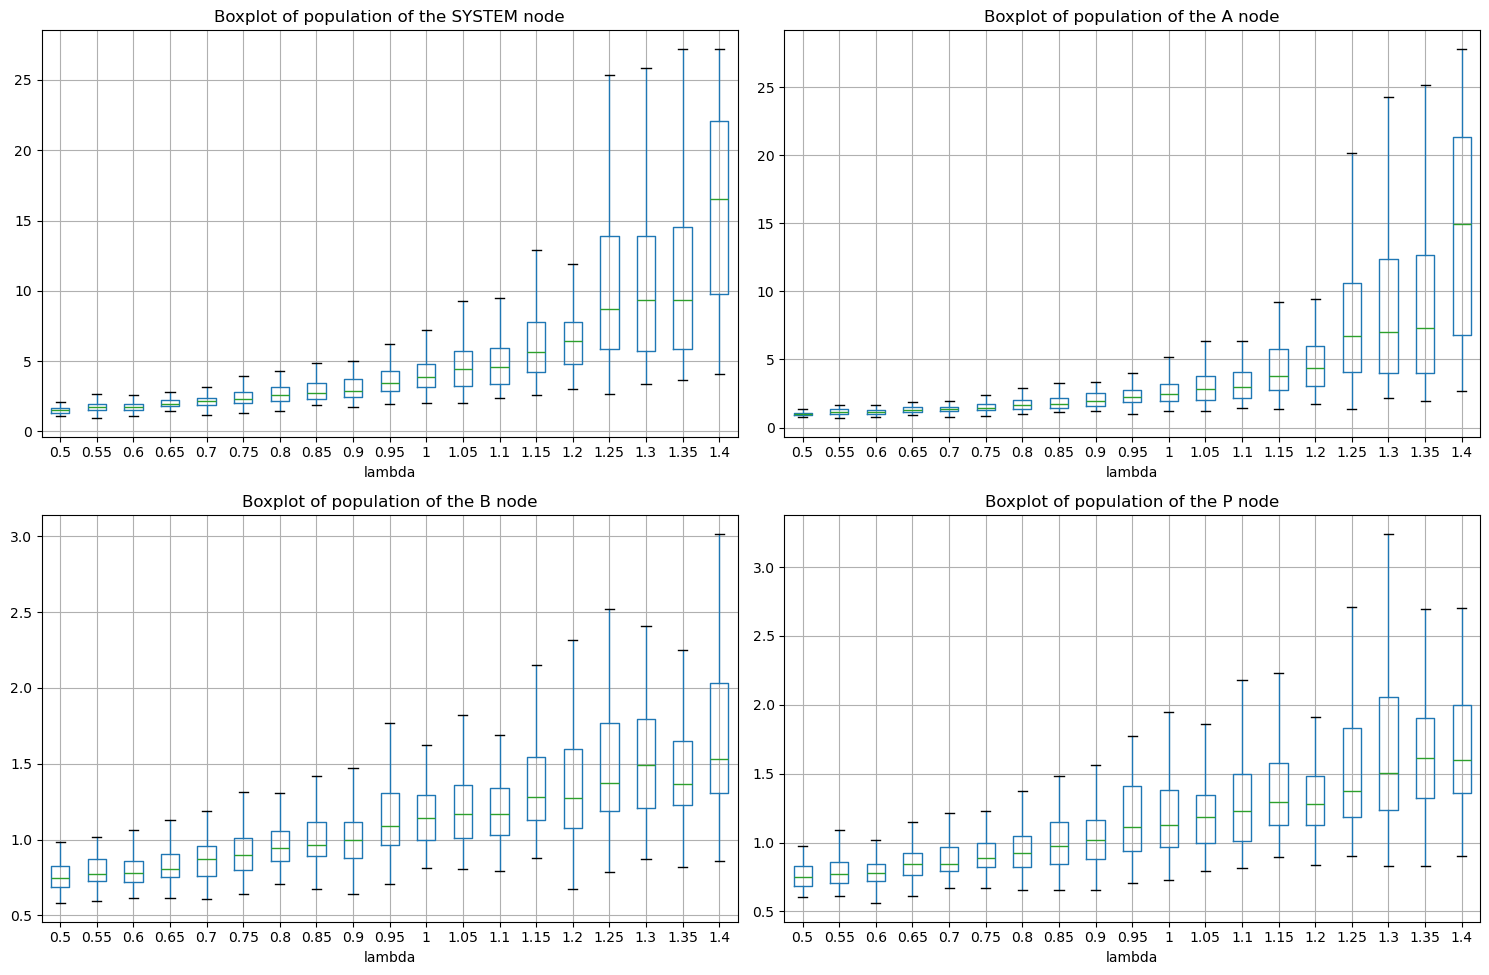

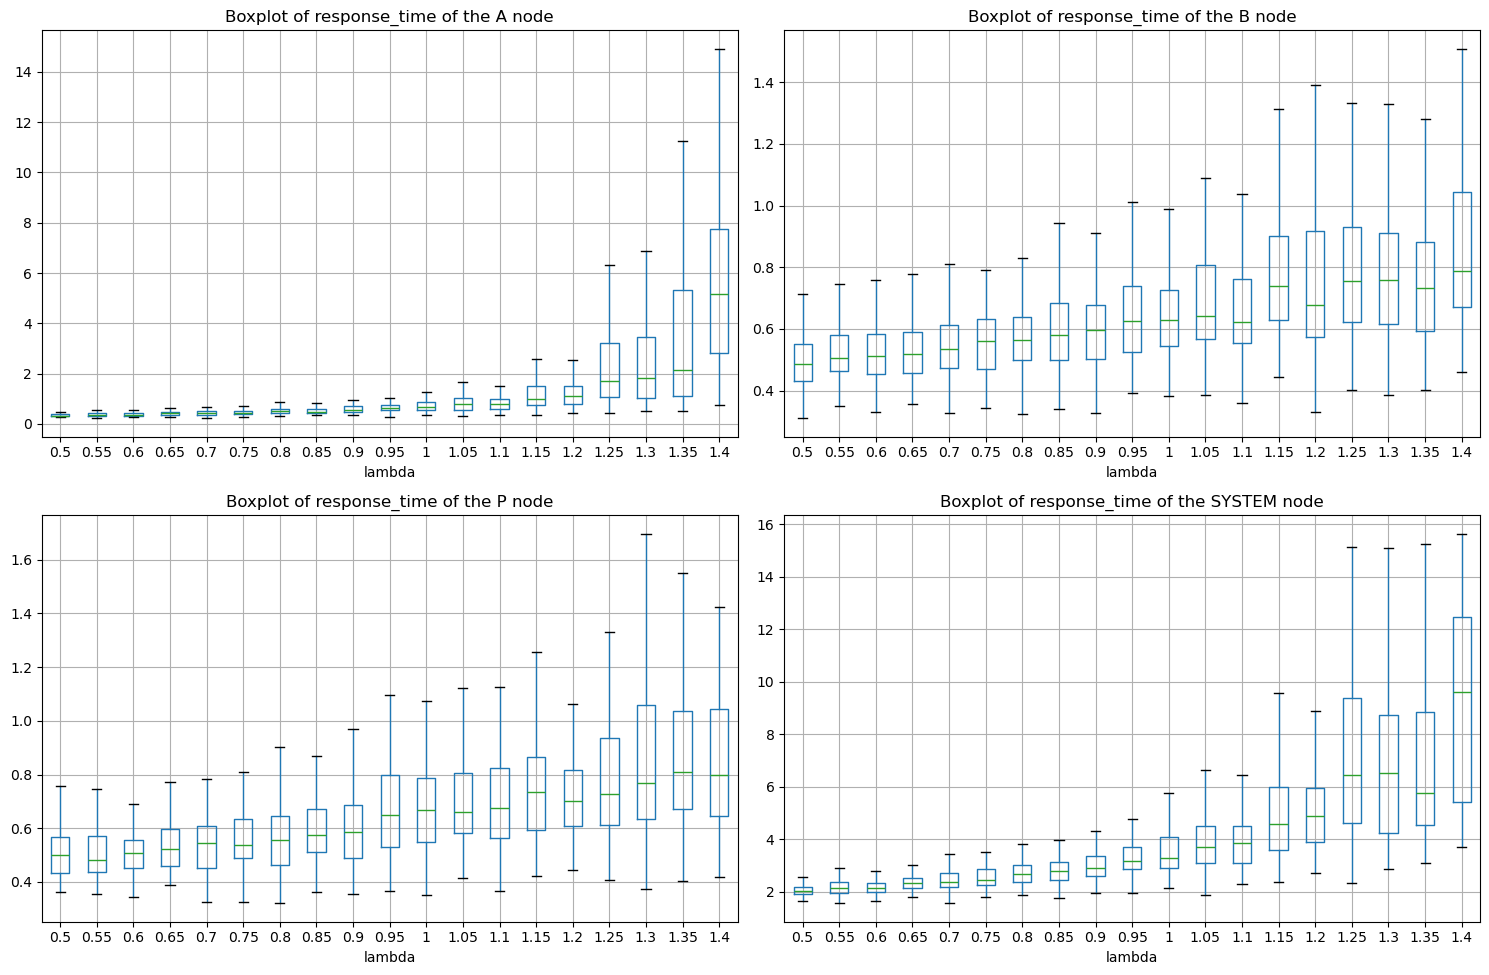

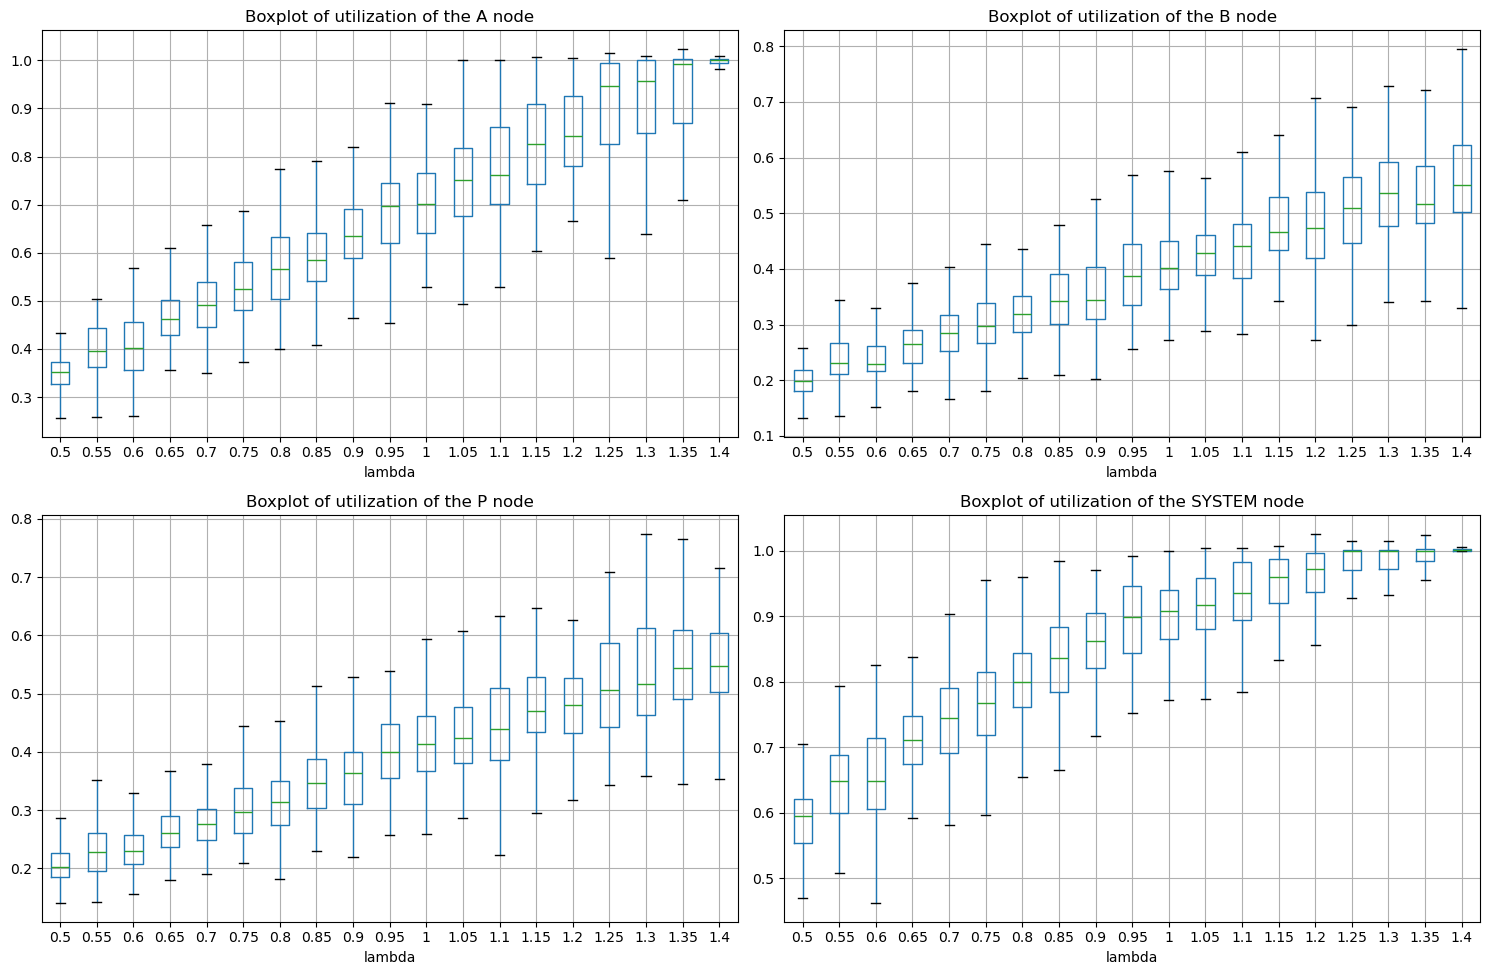

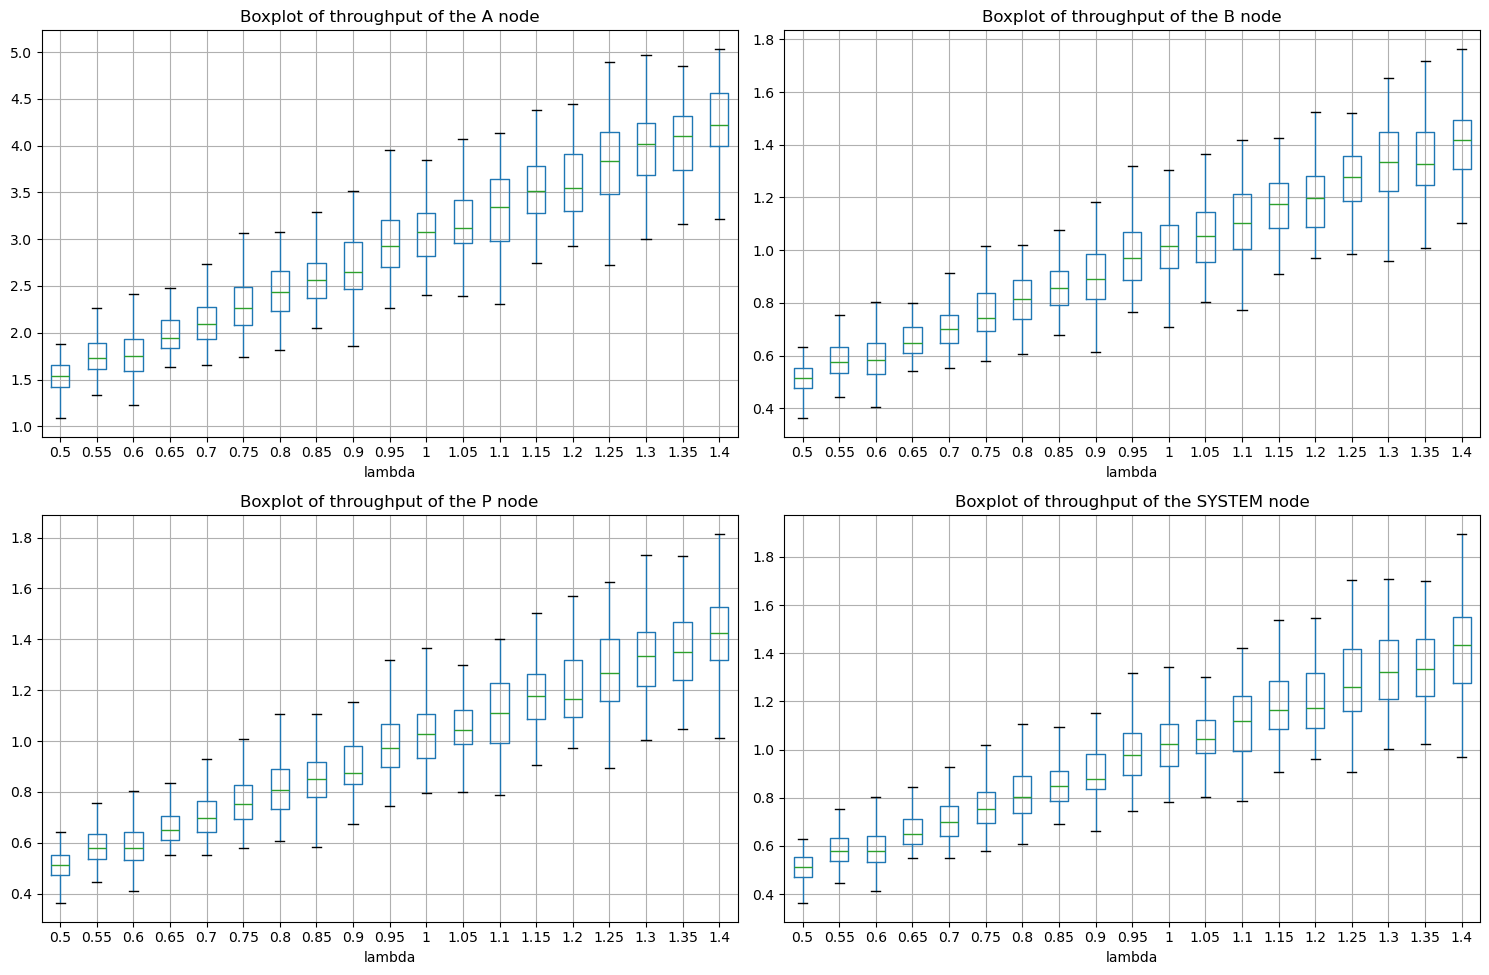

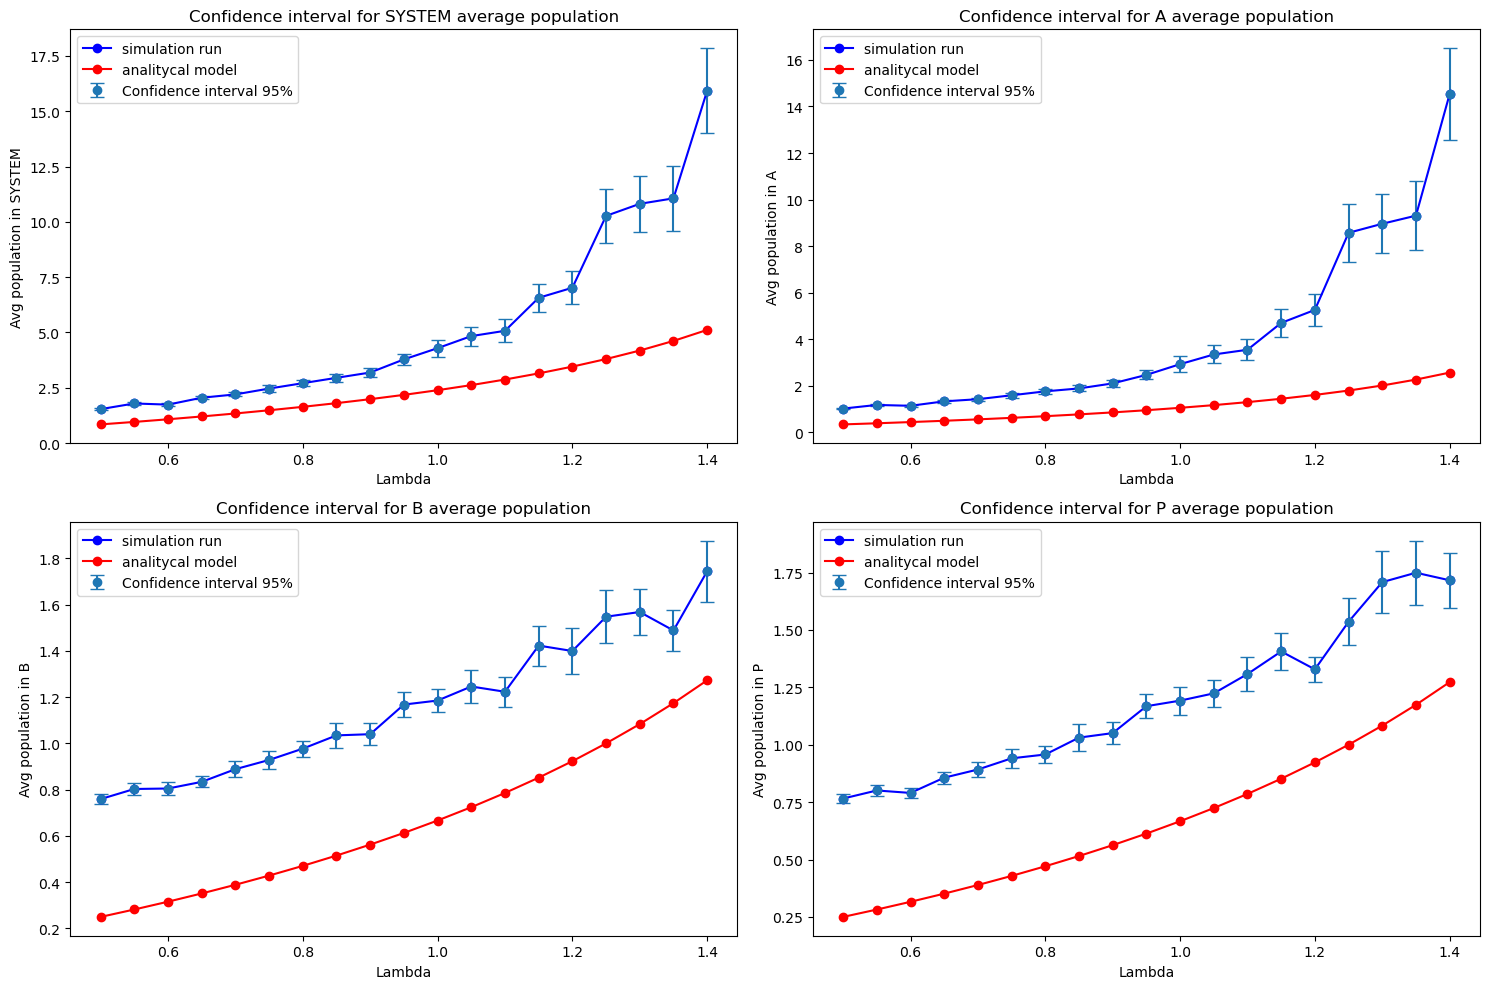

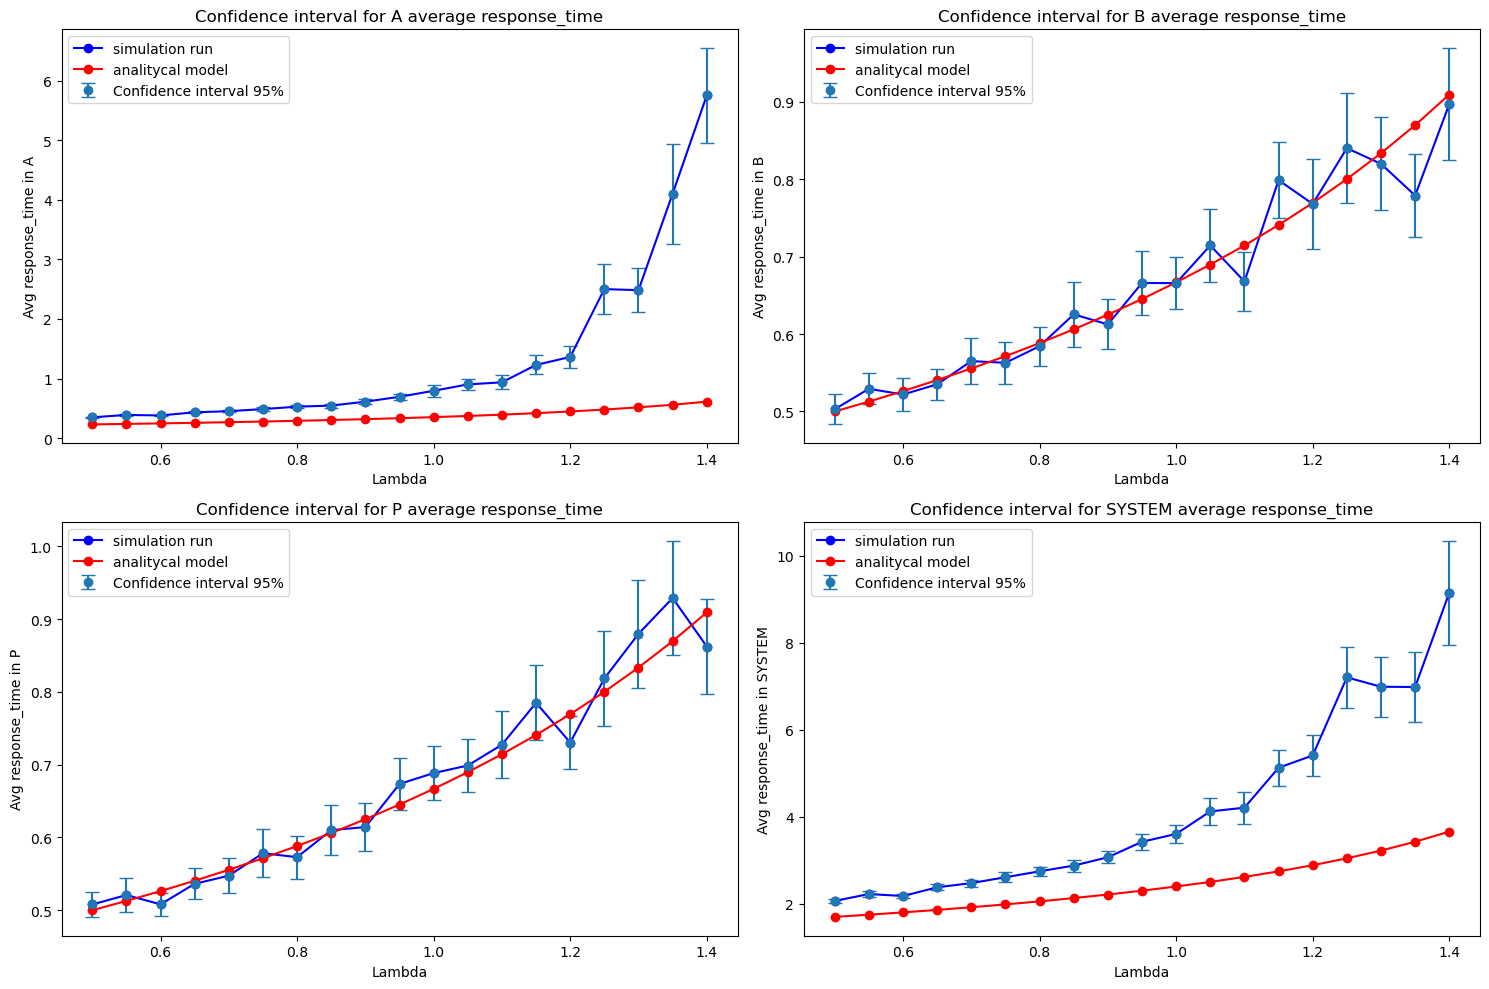

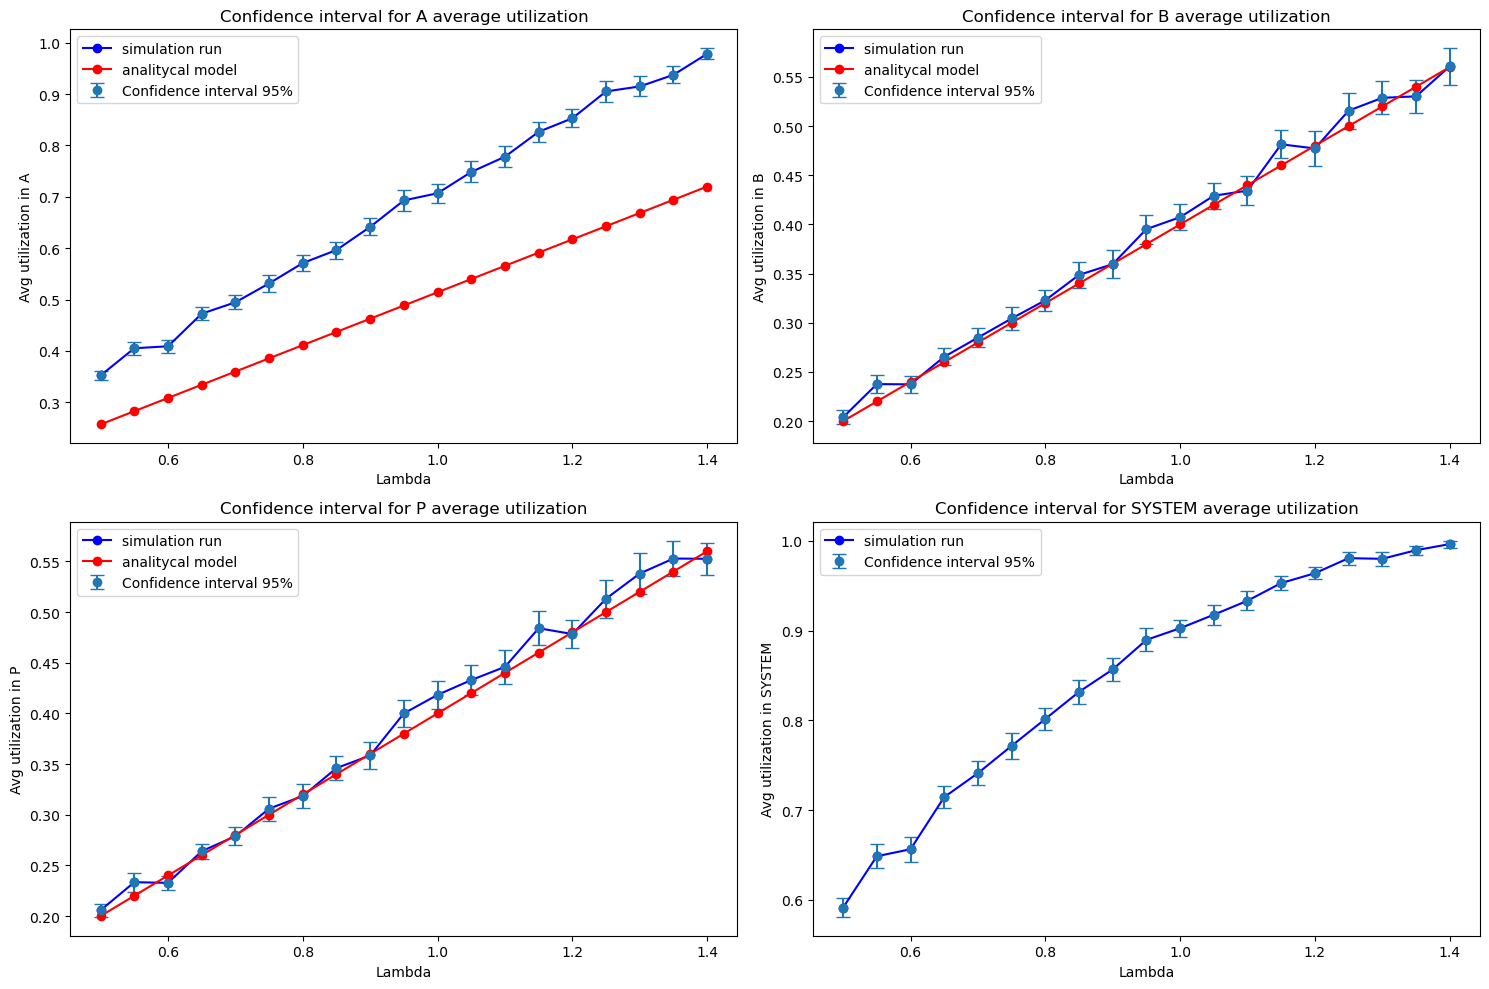

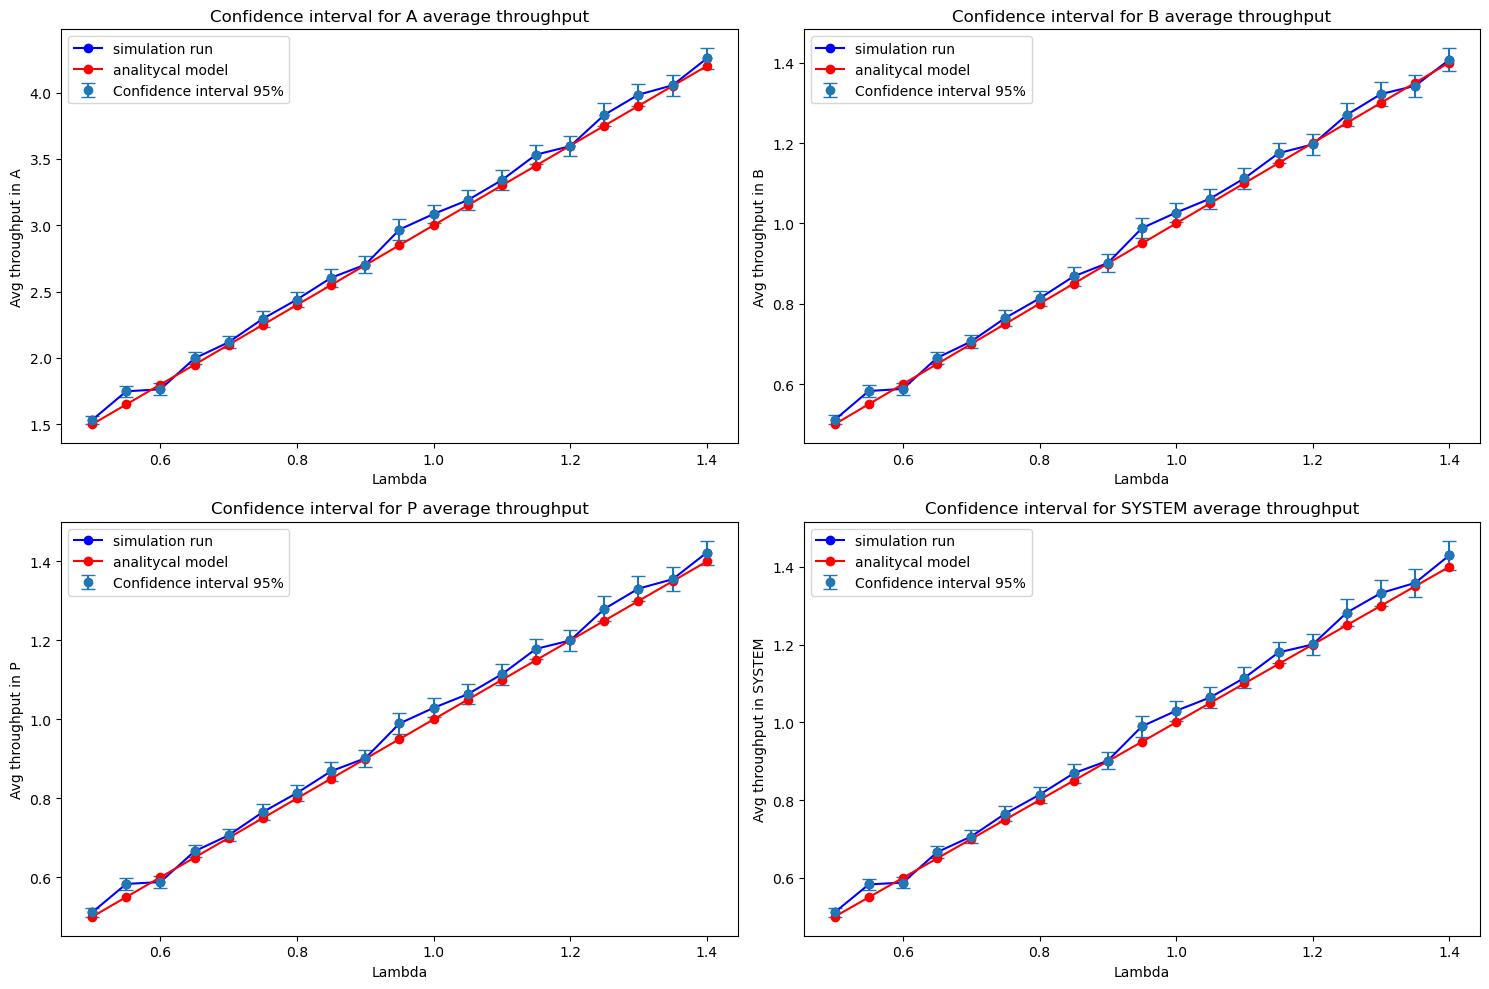

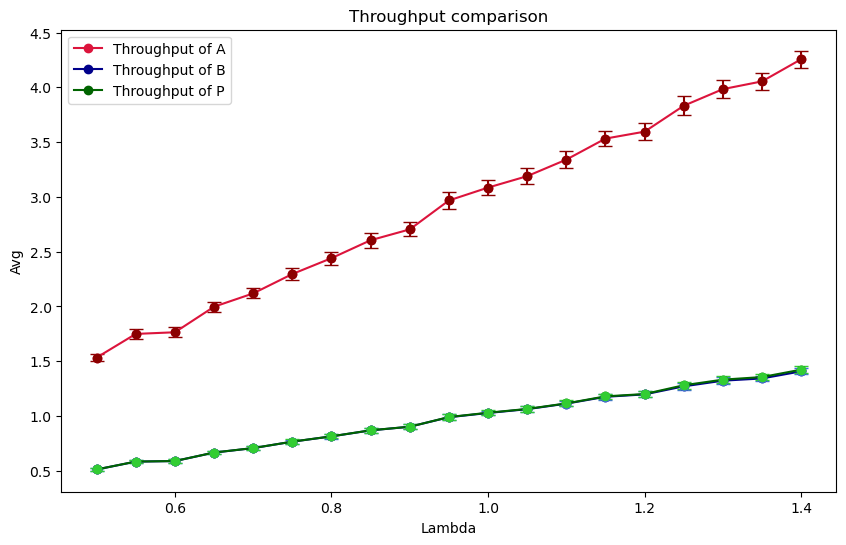

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">     diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           1.53677</td><td style="text-align: right;">          0.846154</td><td style="text-align: right;"> 0.690616</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           1.79228</td><td style="text-align: right;">          0.958525</td><td style="text-align: right;"> 0.833758</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           1.74028</td><td style="text-align: right;">          1.07786 </td><td style="text-align: right;"> 0.662416</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           2.05192</td><td style="text-align: right;">          1.20485 </td><td style="text-align: right;"> 0.847072</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           2.2019 </td><td style="text-align: right;">          1.34028 </td><td style="text-align: right;"> 0.861622</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           2.4658 </td><td style="text-align: right;">          1.48505 </td><td style="text-align: right;"> 0.980745</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           2.70895</td><td style="text-align: right;">          1.64021 </td><td style="text-align: right;"> 1.06874 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           2.95152</td><td style="text-align: right;">          1.80695 </td><td style="text-align: right;"> 1.14457 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           3.19073</td><td style="text-align: right;">          1.9867  </td><td style="text-align: right;"> 1.20403 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           3.78327</td><td style="text-align: right;">          2.18111 </td><td style="text-align: right;"> 1.60215 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           4.29166</td><td style="text-align: right;">          2.39216 </td><td style="text-align: right;"> 1.89951 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           4.83699</td><td style="text-align: right;">          2.62219 </td><td style="text-align: right;"> 2.2148  </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           5.07547</td><td style="text-align: right;">          2.87406 </td><td style="text-align: right;"> 2.20141 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           6.56796</td><td style="text-align: right;">          3.15126 </td><td style="text-align: right;"> 3.41671 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>SYSTEM</td><td style="text-align: right;">           7.02157</td><td style="text-align: right;">          3.45809 </td><td style="text-align: right;"> 3.56347 </td></tr>\n<tr><td style="text-align: right;">    1.25</td><td>population</td><td>SYSTEM</td><td styl

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">     diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.02599</td><td style="text-align: right;">          0.346154</td><td style="text-align: right;"> 0.679835</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>A     </td><td style="text-align: right;">           1.18193</td><td style="text-align: right;">          0.394422</td><td style="text-align: right;"> 0.787506</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.14567</td><td style="text-align: right;">          0.446281</td><td style="text-align: right;"> 0.699393</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>A     </td><td style="text-align: right;">           1.3368 </td><td style="text-align: right;">          0.502146</td><td style="text-align: right;"> 0.834657</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.42865</td><td style="text-align: right;">          0.5625  </td><td style="text-align: right;"> 0.866153</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>A     </td><td style="text-align: right;">           1.59702</td><td style="text-align: right;">          0.627907</td><td style="text-align: right;"> 0.969113</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>A     </td><td style="text-align: right;">           1.76553</td><td style="text-align: right;">          0.699029</td><td style="text-align: right;"> 1.0665  </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>A     </td><td style="text-align: right;">           1.89112</td><td style="text-align: right;">          0.77665 </td><td style="text-align: right;"> 1.11447 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>A     </td><td style="text-align: right;">           2.10685</td><td style="text-align: right;">          0.861702</td><td style="text-align: right;"> 1.24515 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>A     </td><td style="text-align: right;">           2.47194</td><td style="text-align: right;">          0.955307</td><td style="text-align: right;"> 1.51663 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>A     </td><td style="text-align: right;">           2.93352</td><td style="text-align: right;">          1.05882 </td><td style="text-align: right;"> 1.8747  </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>A     </td><td style="text-align: right;">           3.34933</td><td style="text-align: right;">          1.17391 </td><td style="text-align: right;"> 2.17541 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>A     </td><td style="text-align: right;">           3.5521 </td><td style="text-align: right;">          1.30263 </td><td style="text-align: right;"> 2.24947 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>A     </td><td style="text-align: right;">           4.70459</td><td style="text-align: right;">          1.44755 </td><td style="text-align: right;"> 3.25704 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>A     </td><td style="text-align: right;">           5.26344</td><td style="text-align: right;">          1.61194 </td><td style="text-align: right;"> 3.6515  </td></tr>\n<tr><td style="text-align: right;">    1.25</td><td>population</td><td>A     </td><td styl

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>B     </td><td style="text-align: right;">          0.759171</td><td style="text-align: right;">          0.25    </td><td style="text-align: right;">0.509171</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>B     </td><td style="text-align: right;">          0.802889</td><td style="text-align: right;">          0.282051</td><td style="text-align: right;">0.520838</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>B     </td><td style="text-align: right;">          0.804967</td><td style="text-align: right;">          0.315789</td><td style="text-align: right;">0.489177</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>B     </td><td style="text-align: right;">          0.833664</td><td style="text-align: right;">          0.351351</td><td style="text-align: right;">0.482313</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>B     </td><td style="text-align: right;">          0.888503</td><td style="text-align: right;">          0.388889</td><td style="text-align: right;">0.499614</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>B     </td><td style="text-align: right;">          0.928308</td><td style="text-align: right;">          0.428571</td><td style="text-align: right;">0.499736</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>B     </td><td style="text-align: right;">          0.977247</td><td style="text-align: right;">          0.470588</td><td style="text-align: right;">0.506659</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>B     </td><td style="text-align: right;">          1.03456 </td><td style="text-align: right;">          0.515152</td><td style="text-align: right;">0.519406</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>B     </td><td style="text-align: right;">          1.03973 </td><td style="text-align: right;">          0.5625  </td><td style="text-align: right;">0.477227</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>B     </td><td style="text-align: right;">          1.16779 </td><td style="text-align: right;">          0.612903</td><td style="text-align: right;">0.554883</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>B     </td><td style="text-align: right;">          1.18513 </td><td style="text-align: right;">          0.666667</td><td style="text-align: right;">0.518459</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>B     </td><td style="text-align: right;">          1.24585 </td><td style="text-align: right;">          0.724138</td><td style="text-align: right;">0.521714</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>B     </td><td style="text-align: right;">          1.2231  </td><td style="text-align: right;">          0.785714</td><td style="text-align: right;">0.437382</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>B     </td><td style="text-align: right;">          1.42269 </td><td style="text-align: right;">          0.851852</td><td style="text-align: right;">0.570842</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>B     </td><td style="text-align: right;">          1.39925 </td><td style="text-align: right;">          0.923077</td><td style="text-align: right;">0.47617 </td></tr>\n<tr><td style="text-align: right;">    1.25</td><td>population</td><td>B     </td><td style="text-align: r

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>population</td><td>P     </td><td style="text-align: right;">          0.765539</td><td style="text-align: right;">          0.25    </td><td style="text-align: right;">0.515539</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>population</td><td>P     </td><td style="text-align: right;">          0.800743</td><td style="text-align: right;">          0.282051</td><td style="text-align: right;">0.518691</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>population</td><td>P     </td><td style="text-align: right;">          0.790038</td><td style="text-align: right;">          0.315789</td><td style="text-align: right;">0.474248</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>population</td><td>P     </td><td style="text-align: right;">          0.856448</td><td style="text-align: right;">          0.351351</td><td style="text-align: right;">0.505097</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>population</td><td>P     </td><td style="text-align: right;">          0.892038</td><td style="text-align: right;">          0.388889</td><td style="text-align: right;">0.503149</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>population</td><td>P     </td><td style="text-align: right;">          0.94076 </td><td style="text-align: right;">          0.428571</td><td style="text-align: right;">0.512188</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>population</td><td>P     </td><td style="text-align: right;">          0.957429</td><td style="text-align: right;">          0.470588</td><td style="text-align: right;">0.48684 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>population</td><td>P     </td><td style="text-align: right;">          1.03096 </td><td style="text-align: right;">          0.515152</td><td style="text-align: right;">0.515806</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>population</td><td>P     </td><td style="text-align: right;">          1.05062 </td><td style="text-align: right;">          0.5625  </td><td style="text-align: right;">0.488125</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>population</td><td>P     </td><td style="text-align: right;">          1.16782 </td><td style="text-align: right;">          0.612903</td><td style="text-align: right;">0.554916</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>population</td><td>P     </td><td style="text-align: right;">          1.19204 </td><td style="text-align: right;">          0.666667</td><td style="text-align: right;">0.525374</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>population</td><td>P     </td><td style="text-align: right;">          1.22371 </td><td style="text-align: right;">          0.724138</td><td style="text-align: right;">0.499569</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>population</td><td>P     </td><td style="text-align: right;">          1.30793 </td><td style="text-align: right;">          0.785714</td><td style="text-align: right;">0.522214</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>population</td><td>P     </td><td style="text-align: right;">          1.40632 </td><td style="text-align: right;">          0.851852</td><td style="text-align: right;">0.554471</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>population</td><td>P     </td><td style="text-align: right;">          1.3283  </td><td style="text-align: right;">          0.923077</td><td style="text-align: right;">0.405219</td></tr>\n<tr><td style="text-align: right;">    1.25</td><td>population</td><td>P     </td><td style="text-align: r

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.349554</td><td style="text-align: right;">          0.230769</td><td style="text-align: right;">0.118785</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.389825</td><td style="text-align: right;">          0.239044</td><td style="text-align: right;">0.150781</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.380865</td><td style="text-align: right;">          0.247934</td><td style="text-align: right;">0.132931</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.4343  </td><td style="text-align: right;">          0.257511</td><td style="text-align: right;">0.176789</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.452293</td><td style="text-align: right;">          0.267857</td><td style="text-align: right;">0.184436</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.488131</td><td style="text-align: right;">          0.27907 </td><td style="text-align: right;">0.209061</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.528329</td><td style="text-align: right;">          0.291262</td><td style="text-align: right;">0.237067</td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.546412</td><td style="text-align: right;">          0.304569</td><td style="text-align: right;">0.241843</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.612246</td><td style="text-align: right;">          0.319149</td><td style="text-align: right;">0.293097</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.694159</td><td style="text-align: right;">          0.335196</td><td style="text-align: right;">0.358964</td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.795051</td><td style="text-align: right;">          0.352941</td><td style="text-align: right;">0.44211 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.90177 </td><td style="text-align: right;">          0.372671</td><td style="text-align: right;">0.5291  </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          0.93701 </td><td style="text-align: right;">          0.394737</td><td style="text-align: right;">0.542274</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>A     </td><td style="text-align: right;">          1.22902 </td><td style="text-align: right;">          0.41958 </td><td style="text-align: right;">0.809441</td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>A     </td><td style="text-align: right;">          1.36249 </td><td style="text-align: right;">          0.447761</td><td style="text-align: right;">0.914732</td></tr>\n<tr><td style="text-align: right;">    1.25</td><td>respon

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">       diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>B     </td><td style="text-align: right;">          0.502974</td><td style="text-align: right;">          0.5     </td><td style="text-align: right;">0.00297379 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>B     </td><td style="text-align: right;">          0.529279</td><td style="text-align: right;">          0.512821</td><td style="text-align: right;">0.0164583  </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>B     </td><td style="text-align: right;">          0.521956</td><td style="text-align: right;">          0.526316</td><td style="text-align: right;">0.00436029 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>B     </td><td style="text-align: right;">          0.535088</td><td style="text-align: right;">          0.540541</td><td style="text-align: right;">0.00545273 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>B     </td><td style="text-align: right;">          0.56503 </td><td style="text-align: right;">          0.555556</td><td style="text-align: right;">0.00947427 </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>B     </td><td style="text-align: right;">          0.56284 </td><td style="text-align: right;">          0.571429</td><td style="text-align: right;">0.00858897 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>B     </td><td style="text-align: right;">          0.584317</td><td style="text-align: right;">          0.588235</td><td style="text-align: right;">0.00391819 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>B     </td><td style="text-align: right;">          0.625367</td><td style="text-align: right;">          0.606061</td><td style="text-align: right;">0.0193066  </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>B     </td><td style="text-align: right;">          0.612427</td><td style="text-align: right;">          0.625   </td><td style="text-align: right;">0.0125726  </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>B     </td><td style="text-align: right;">          0.665944</td><td style="text-align: right;">          0.645161</td><td style="text-align: right;">0.0207827  </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>B     </td><td style="text-align: right;">          0.665681</td><td style="text-align: right;">          0.666667</td><td style="text-align: right;">0.000985815</td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>B     </td><td style="text-align: right;">          0.714339</td><td style="text-align: right;">          0.689655</td><td style="text-align: right;">0.0246835  </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>B     </td><td style="text-align: right;">          0.667847</td><td style="text-align: right;">          0.714286</td><td style="text-align: right;">0.046439   </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>B     </td><td style="text-align: right;">          0.798655</td><td style="text-align: right;">          0.740741</td><td style="text-align: right;">0.0579143  </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>B     </td><td style="text-align: right;">          0.767926</td><td style="text-align: right;">          0.769231</td><td style="text-align: right;">0.00130487 </td></tr>\n<tr><td st

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.507907</td><td style="text-align: right;">          0.5     </td><td style="text-align: right;">0.0079072 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.520898</td><td style="text-align: right;">          0.512821</td><td style="text-align: right;">0.00807705</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.5081  </td><td style="text-align: right;">          0.526316</td><td style="text-align: right;">0.018216  </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.536363</td><td style="text-align: right;">          0.540541</td><td style="text-align: right;">0.00417738</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.547455</td><td style="text-align: right;">          0.555556</td><td style="text-align: right;">0.00810088</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.578335</td><td style="text-align: right;">          0.571429</td><td style="text-align: right;">0.00690653</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.572939</td><td style="text-align: right;">          0.588235</td><td style="text-align: right;">0.0152966 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.609979</td><td style="text-align: right;">          0.606061</td><td style="text-align: right;">0.00391874</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.614287</td><td style="text-align: right;">          0.625   </td><td style="text-align: right;">0.0107133 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.673487</td><td style="text-align: right;">          0.645161</td><td style="text-align: right;">0.0283258 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.688378</td><td style="text-align: right;">          0.666667</td><td style="text-align: right;">0.0217111 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.69878 </td><td style="text-align: right;">          0.689655</td><td style="text-align: right;">0.00912517</td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.727365</td><td style="text-align: right;">          0.714286</td><td style="text-align: right;">0.0130789 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.78496 </td><td style="text-align: right;">          0.740741</td><td style="text-align: right;">0.0442191 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>P     </td><td style="text-align: right;">          0.73027 </td><td style="text-align: right;">          0.769231</td><td style="text-align: right;">0.0389606 </td></tr>\n<tr><td style="text-align:

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric       </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">    diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           2.05951</td><td style="text-align: right;">           1.69231</td><td style="text-align: right;">0.3672  </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           2.21892</td><td style="text-align: right;">           1.74277</td><td style="text-align: right;">0.476152</td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           2.1728 </td><td style="text-align: right;">           1.79643</td><td style="text-align: right;">0.376363</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           2.37345</td><td style="text-align: right;">           1.85361</td><td style="text-align: right;">0.519836</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           2.47033</td><td style="text-align: right;">           1.91468</td><td style="text-align: right;">0.555647</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           2.60483</td><td style="text-align: right;">           1.98007</td><td style="text-align: right;">0.624759</td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           2.74176</td><td style="text-align: right;">           2.05026</td><td style="text-align: right;">0.6915  </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           2.87262</td><td style="text-align: right;">           2.12583</td><td style="text-align: right;">0.74679 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           3.06423</td><td style="text-align: right;">           2.20745</td><td style="text-align: right;">0.856788</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           3.42057</td><td style="text-align: right;">           2.29591</td><td style="text-align: right;">1.12466 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           3.60144</td><td style="text-align: right;">           2.39216</td><td style="text-align: right;">1.20929 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           4.11996</td><td style="text-align: right;">           2.49732</td><td style="text-align: right;">1.62264 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           4.20531</td><td style="text-align: right;">           2.61278</td><td style="text-align: right;">1.59253 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           5.12425</td><td style="text-align: right;">           2.74022</td><td style="text-align: right;">2.38403 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>response_time</td><td>SYSTEM</td><td style="text-align: right;">           5.40747</td><td style="text-align: right;">           2.88175</td><td style="text-align: right;">2.52573 </td></tr>\n<tr><td style="text-align: right;">    1.25</td><td>respon

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric     </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">     diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.352358</td><td style="text-align: right;">          0.257143</td><td style="text-align: right;">0.0952154</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.405334</td><td style="text-align: right;">          0.282857</td><td style="text-align: right;">0.122477 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.40917 </td><td style="text-align: right;">          0.308571</td><td style="text-align: right;">0.100599 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.472589</td><td style="text-align: right;">          0.334286</td><td style="text-align: right;">0.138304 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.494738</td><td style="text-align: right;">          0.36    </td><td style="text-align: right;">0.134738 </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.531511</td><td style="text-align: right;">          0.385714</td><td style="text-align: right;">0.145797 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.571165</td><td style="text-align: right;">          0.411429</td><td style="text-align: right;">0.159736 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.596469</td><td style="text-align: right;">          0.437143</td><td style="text-align: right;">0.159326 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.641568</td><td style="text-align: right;">          0.462857</td><td style="text-align: right;">0.178711 </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.693048</td><td style="text-align: right;">          0.488571</td><td style="text-align: right;">0.204477 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.706909</td><td style="text-align: right;">          0.514286</td><td style="text-align: right;">0.192623 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.748415</td><td style="text-align: right;">          0.54    </td><td style="text-align: right;">0.208415 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.778091</td><td style="text-align: right;">          0.565714</td><td style="text-align: right;">0.212377 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.826527</td><td style="text-align: right;">          0.591429</td><td style="text-align: right;">0.235098 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>utilization</td><td>A     </td><td style="text-align: right;">          0.852872</td><td style="text-align: right;">          0.617143</td><td style="text-align: right;">0.235729 </td></tr>\n<tr><td style="text-align: right;">    1.25</td><td>utilization</td><td>A 

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric     </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">       diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.203883</td><td style="text-align: right;">              0.2 </td><td style="text-align: right;">0.00388258 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.237655</td><td style="text-align: right;">              0.22</td><td style="text-align: right;">0.0176554  </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.237427</td><td style="text-align: right;">              0.24</td><td style="text-align: right;">0.00257326 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.26545 </td><td style="text-align: right;">              0.26</td><td style="text-align: right;">0.00545036 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.284911</td><td style="text-align: right;">              0.28</td><td style="text-align: right;">0.00491089 </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.304374</td><td style="text-align: right;">              0.3 </td><td style="text-align: right;">0.00437391 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.32288 </td><td style="text-align: right;">              0.32</td><td style="text-align: right;">0.00287962 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.348676</td><td style="text-align: right;">              0.34</td><td style="text-align: right;">0.00867563 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.359656</td><td style="text-align: right;">              0.36</td><td style="text-align: right;">0.000344433</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.395255</td><td style="text-align: right;">              0.38</td><td style="text-align: right;">0.0152552  </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.40735 </td><td style="text-align: right;">              0.4 </td><td style="text-align: right;">0.00734963 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.42922 </td><td style="text-align: right;">              0.42</td><td style="text-align: right;">0.00921957 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.434387</td><td style="text-align: right;">              0.44</td><td style="text-align: right;">0.00561327 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.481458</td><td style="text-align: right;">              0.46</td><td style="text-align: right;">0.021458   </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>utilization</td><td>B     </td><td style="text-align: right;">          0.477305</td><td style="text-align: right;">              0.48</td><td style="text-align: right;">0.00269498 </td></tr>\n<tr><td style="text-align: right;">    1.2

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric     </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.205681</td><td style="text-align: right;">              0.2 </td><td style="text-align: right;">0.00568139</td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.233355</td><td style="text-align: right;">              0.22</td><td style="text-align: right;">0.0133547 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.232741</td><td style="text-align: right;">              0.24</td><td style="text-align: right;">0.00725868</td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.263969</td><td style="text-align: right;">              0.26</td><td style="text-align: right;">0.00396867</td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.278764</td><td style="text-align: right;">              0.28</td><td style="text-align: right;">0.00123639</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.305987</td><td style="text-align: right;">              0.3 </td><td style="text-align: right;">0.0059869 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.318385</td><td style="text-align: right;">              0.32</td><td style="text-align: right;">0.0016152 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.346012</td><td style="text-align: right;">              0.34</td><td style="text-align: right;">0.00601207</td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.358431</td><td style="text-align: right;">              0.36</td><td style="text-align: right;">0.00156943</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.399994</td><td style="text-align: right;">              0.38</td><td style="text-align: right;">0.0199943 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.418273</td><td style="text-align: right;">              0.4 </td><td style="text-align: right;">0.0182733 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.432877</td><td style="text-align: right;">              0.42</td><td style="text-align: right;">0.0128769 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.445905</td><td style="text-align: right;">              0.44</td><td style="text-align: right;">0.00590493</td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.484021</td><td style="text-align: right;">              0.46</td><td style="text-align: right;">0.0240209 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>utilization</td><td>P     </td><td style="text-align: right;">          0.47826 </td><td style="text-align: right;">              0.48</td><td style="text-align: right;">0.00173991</td></tr>\n<tr><td style="text-align: right;">    1.25</td><td>utiliz

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           1.53282</td><td style="text-align: right;">              1.5 </td><td style="text-align: right;">0.0328198 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>A     </td><td style="text-align: right;">           1.74892</td><td style="text-align: right;">              1.65</td><td style="text-align: right;">0.0989227 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           1.76391</td><td style="text-align: right;">              1.8 </td><td style="text-align: right;">0.036088  </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>A     </td><td style="text-align: right;">           1.99708</td><td style="text-align: right;">              1.95</td><td style="text-align: right;">0.0470814 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.11875</td><td style="text-align: right;">              2.1 </td><td style="text-align: right;">0.0187482 </td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.29568</td><td style="text-align: right;">              2.25</td><td style="text-align: right;">0.0456823 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.44063</td><td style="text-align: right;">              2.4 </td><td style="text-align: right;">0.040632  </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.60442</td><td style="text-align: right;">              2.55</td><td style="text-align: right;">0.0544242 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.70338</td><td style="text-align: right;">              2.7 </td><td style="text-align: right;">0.00338   </td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>A     </td><td style="text-align: right;">           2.96753</td><td style="text-align: right;">              2.85</td><td style="text-align: right;">0.117527  </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.08507</td><td style="text-align: right;">              3   </td><td style="text-align: right;">0.0850653 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.18939</td><td style="text-align: right;">              3.15</td><td style="text-align: right;">0.0393897 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.34054</td><td style="text-align: right;">              3.3 </td><td style="text-align: right;">0.0405437 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.53243</td><td style="text-align: right;">              3.45</td><td style="text-align: right;">0.0824285 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>A     </td><td style="text-align: right;">           3.59586</td><td style="text-align: right;">              3.6 </td><td style="text-align: right;">0.00414107</td></tr>\n<tr><td style="text-align: right;">    1.25</td><td>throughput</td><td>A  

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.510896</td><td style="text-align: right;">              0.5 </td><td style="text-align: right;">0.0108965 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.582871</td><td style="text-align: right;">              0.55</td><td style="text-align: right;">0.0328712 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.588011</td><td style="text-align: right;">              0.6 </td><td style="text-align: right;">0.0119887 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.665222</td><td style="text-align: right;">              0.65</td><td style="text-align: right;">0.0152224 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.706181</td><td style="text-align: right;">              0.7 </td><td style="text-align: right;">0.00618146</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.764846</td><td style="text-align: right;">              0.75</td><td style="text-align: right;">0.0148458 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.813225</td><td style="text-align: right;">              0.8 </td><td style="text-align: right;">0.0132254 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.868114</td><td style="text-align: right;">              0.85</td><td style="text-align: right;">0.0181143 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.901307</td><td style="text-align: right;">              0.9 </td><td style="text-align: right;">0.00130675</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>B     </td><td style="text-align: right;">          0.988225</td><td style="text-align: right;">              0.95</td><td style="text-align: right;">0.0382248 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.02679 </td><td style="text-align: right;">              1   </td><td style="text-align: right;">0.0267883 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.06174 </td><td style="text-align: right;">              1.05</td><td style="text-align: right;">0.011743  </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.11217 </td><td style="text-align: right;">              1.1 </td><td style="text-align: right;">0.0121656 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.1746  </td><td style="text-align: right;">              1.15</td><td style="text-align: right;">0.0246039 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>B     </td><td style="text-align: right;">          1.19658 </td><td style="text-align: right;">              1.2 </td><td style="text-align: right;">0.00342218</td></tr>\n<tr><td style="text-align: right;">    1.25</td><td>throughput</td><td>B  

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.511208</td><td style="text-align: right;">              0.5 </td><td style="text-align: right;">0.0112081 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.583197</td><td style="text-align: right;">              0.55</td><td style="text-align: right;">0.033197  </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.587978</td><td style="text-align: right;">              0.6 </td><td style="text-align: right;">0.0120221 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.665958</td><td style="text-align: right;">              0.65</td><td style="text-align: right;">0.0159575 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.706436</td><td style="text-align: right;">              0.7 </td><td style="text-align: right;">0.00643553</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.76529 </td><td style="text-align: right;">              0.75</td><td style="text-align: right;">0.0152901 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.813703</td><td style="text-align: right;">              0.8 </td><td style="text-align: right;">0.0137033 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.868824</td><td style="text-align: right;">              0.85</td><td style="text-align: right;">0.0188239 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.901542</td><td style="text-align: right;">              0.9 </td><td style="text-align: right;">0.00154208</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>P     </td><td style="text-align: right;">          0.989629</td><td style="text-align: right;">              0.95</td><td style="text-align: right;">0.0396285 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.02924 </td><td style="text-align: right;">              1   </td><td style="text-align: right;">0.0292406 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.0638  </td><td style="text-align: right;">              1.05</td><td style="text-align: right;">0.0138046 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.11437 </td><td style="text-align: right;">              1.1 </td><td style="text-align: right;">0.0143696 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.17863 </td><td style="text-align: right;">              1.15</td><td style="text-align: right;">0.0286346 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>P     </td><td style="text-align: right;">          1.19991 </td><td style="text-align: right;">              1.2 </td><td style="text-align: right;">9.1804e-05</td></tr>\n<tr><td style="text-align: right;">    1.25</td><td>throughput</td><td>P  

'<table>\n<thead>\n<tr><th style="text-align: right;">  lambda</th><th>metric    </th><th>node  </th><th style="text-align: right;">  simulation_value</th><th style="text-align: right;">  analitycal_value</th><th style="text-align: right;">      diff</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">    0.5 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.511161</td><td style="text-align: right;">              0.5 </td><td style="text-align: right;">0.0111606 </td></tr>\n<tr><td style="text-align: right;">    0.55</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.583084</td><td style="text-align: right;">              0.55</td><td style="text-align: right;">0.0330839 </td></tr>\n<tr><td style="text-align: right;">    0.6 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.587908</td><td style="text-align: right;">              0.6 </td><td style="text-align: right;">0.0120916 </td></tr>\n<tr><td style="text-align: right;">    0.65</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.665962</td><td style="text-align: right;">              0.65</td><td style="text-align: right;">0.0159622 </td></tr>\n<tr><td style="text-align: right;">    0.7 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.706329</td><td style="text-align: right;">              0.7 </td><td style="text-align: right;">0.00632869</td></tr>\n<tr><td style="text-align: right;">    0.75</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.765411</td><td style="text-align: right;">              0.75</td><td style="text-align: right;">0.0154111 </td></tr>\n<tr><td style="text-align: right;">    0.8 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.813789</td><td style="text-align: right;">              0.8 </td><td style="text-align: right;">0.0137888 </td></tr>\n<tr><td style="text-align: right;">    0.85</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.868827</td><td style="text-align: right;">              0.85</td><td style="text-align: right;">0.0188266 </td></tr>\n<tr><td style="text-align: right;">    0.9 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.9013  </td><td style="text-align: right;">              0.9 </td><td style="text-align: right;">0.00130028</td></tr>\n<tr><td style="text-align: right;">    0.95</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          0.989839</td><td style="text-align: right;">              0.95</td><td style="text-align: right;">0.0398394 </td></tr>\n<tr><td style="text-align: right;">    1   </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.02971 </td><td style="text-align: right;">              1   </td><td style="text-align: right;">0.0297107 </td></tr>\n<tr><td style="text-align: right;">    1.05</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.06413 </td><td style="text-align: right;">              1.05</td><td style="text-align: right;">0.0141292 </td></tr>\n<tr><td style="text-align: right;">    1.1 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.11436 </td><td style="text-align: right;">              1.1 </td><td style="text-align: right;">0.0143602 </td></tr>\n<tr><td style="text-align: right;">    1.15</td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.17985 </td><td style="text-align: right;">              1.15</td><td style="text-align: right;">0.0298543 </td></tr>\n<tr><td style="text-align: right;">    1.2 </td><td>throughput</td><td>SYSTEM</td><td style="text-align: right;">          1.20031 </td><td style="text-align: right;">              1.2 </td><td style="text-align: right;">0.00030892</td></tr>\n<tr><td style="text-align: right;">    1.25</td><td>throughput</td><td>SYS

In [ ]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_4_07", 'BatchMeansSimulation')
critical_value = scipy.stats.norm.ppf(1-.05/2)
obj = 'obj4_07'

metrics_nodes_avg_df_list = preprocessing(path, obj)
analitycal_perf = analitycal_preprocessing(obj)

boxplot(metrics_nodes_avg_df_list)
ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, obj)
plot_confidence_interval(ci_df, analitycal_perf)

avg_metrics_list = average_stats(metrics_nodes_avg_df_list, analitycal_perf)
for metric in avg_metrics_list:
    for node in metric:
        df = node.reset_index()
        df.drop(columns=['index'], inplace=True)
        display(tabulate(df, headers='keys', tablefmt='html', showindex=False))